# Load Libraries

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2024-11-24 16:36:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-24 16:36:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-24 16:36:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt


# Load Embeddings

In [ ]:
def load_embeddings():
    glove_input_file = "glove.6B.50d.txt"
    word2vec_output_file = "glove.6B.50d.word2vec.txt"
    # converting GloVe embeddings to Word2Vec format
    glove2word2vec(glove_input_file, word2vec_output_file)
    return KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# vocabulary_embeddings as a glove embeddings
vocabulary_embeddings = load_embeddings()

<ipython-input-5-d1fb899c88f8>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [ ]:
def get_embedding(word):
    # embedding a single word with 50d
    if word in vocabulary_embeddings:
        return vocabulary_embeddings[word]
    return np.zeros(50)

def get_review_embedding(review):
    # embedding each word with 50d
    words = review.lower().split()
    embeddings = np.array([np.array(get_embedding(word)) for word in words])
    # return the mean review vector with 50d
    return np.mean(embeddings, axis=0)

def get_dataset_embeddings(dataset):
    # embedding the whole dataset recordes
    # result value size is records X 50
    return np.array([get_review_embedding(review) for review in dataset])

# Normalization

In [ ]:
def normalize_feature(array, min, max):
    # min-max normalization
    delta = max - min
    if delta == 0:
        return np.zeros_like(array)
    return (array - min) /delta

def normalize(embeddings, train_embeddings):
    # normalize each dimension as a feature
    data = np.zeros_like(embeddings)
    min = np.min(train_embeddings, axis=0) # array of train min per dimension
    max = np.max(train_embeddings, axis=0) # array of train max per dimension

    # normlize each cloumn
    for j in range(data.shape[1]):
      data[:, j] = normalize_feature(embeddings[:, j], min[j], max[j])
    return data

# LR classifier

In [ ]:
def sigmoid_func(x, w, b):
  f_wb  = np.dot(x, w) + b # function by ypdated w and b
  return 1 / (1 + np.exp(-1 * (f_wb))) # sigmoid

def gradient(x, y, y_pred, w, lambda_l2_reg = 0):
  # gradient for W vector
  dw = np.dot(x.T, (y_pred - y)) / x.shape[0]
  d_l2 = lambda_l2_reg * w # enabling L2 regularization. The default lambda value = 0.
  return dw + d_l2

def loss(y, y_pred, w, lambda_l2_reg = 0):
  l2_reg = (lambda_l2_reg / 2) * np.sum(w ** 2) # enabling L2 regularization. The default lambda value = 0.
  loss = -1 * np.mean((y * np.log(y_pred)) + (1 - y) * np.log(1 - y_pred))
  return loss + l2_reg

def accuracy(y, y_pred):
    predictions = [1 if pred >= 0.5 else 0 for pred in y_pred]
    return np.sum(predictions == y) / len(y)

def validiate_wightes(x, y, w, b, best_validation, epoch, dev_acc, dev_loss, lambda_l2_reg):
    # validate w, b values by testing dev dataset and save the best values
    y_pred = sigmoid_func(x, w, b)
    dev_acc.append(accuracy(y, y_pred))
    dev_loss.append(loss(y, y_pred, w, lambda_l2_reg))

    if dev_acc[epoch] > best_validation["best_dev_acc"]:
      best_validation["best_dev_acc"] = dev_acc[epoch]
      best_validation["dev_loss"] = dev_loss[epoch]
      best_validation["best_epoch"] = epoch
      best_validation["best_weights"] = w
      best_validation["best_bias"] = b

def mini_batch_gradient_descent(train, train_label, dev, dev_label, learning_rate, batch_size, epochs, lambda_l2_reg = 0):
  w = np.zeros(train.shape[1]) # initial wighets for each featuer
  b = 0 # initial bias
  # dic for saving the best values by testing on dev
  best_validation = {
        "best_dev_acc": 0,
        "dev_loss": 0,
        "best_epoch": 0,
        "best_batch_size": batch_size,
        "best_lr": learning_rate,
        "best_lambda": lambda_l2_reg,
        "best_weights": None,
        "best_bias": None,
        "Train Acc": None,
        "Train Loss": None,
        "Dev Acc": None,
        "Dev Loss": None,
  }
  # lists for loss and acc to save it for each epoch
  dev_acc = []
  dev_loss = []
  train_acc = []
  train_loss = []

  for epoch in range(epochs):
    # batch = 0
    for index in range(0, train.shape[0], batch_size):
      j =  index + batch_size
      x = train[index : j]
      y = train_label[index : j]
      y_pred = sigmoid_func(x, w, b)

      w -= learning_rate * gradient(x, y, y_pred, w, lambda_l2_reg) # updating wightes per epoch x batch
      b -= learning_rate * np.mean(y_pred - y) # updating bias per epoch x batch

      # batch += 1
      # print(f"Epoch {epoch+1}/{epochs}, Batch {batch}, Loss: {loss(y, y_pred):.4f}, Accuracy: {accuracy(y, y_pred):.4f}")

    # updating best validation and save acc and loss on both training and dev sets.
    train_acc.append(accuracy(y, y_pred))
    train_loss.append(loss(y, y_pred, w, lambda_l2_reg))
    validiate_wightes(dev, dev_label, w, b, best_validation, epoch, dev_acc, dev_loss, lambda_l2_reg)
    if (epoch + 1) % 10 == 0:
      print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss[epoch]:.4f}, Accuracy: {train_acc[epoch]:.4f}, Dev Loss: {dev_loss[epoch]:.4f}, Dev Accuracy: {dev_acc[epoch]:.4f}")

  # send acc and loss logs with best_validation
  best_validation["Train Acc"] = train_acc
  best_validation["Train Loss"] = train_loss
  best_validation["Dev Acc"] = dev_acc
  best_validation["Dev Loss"] = dev_loss
  return best_validation


def get_binary_label(labels, positive="positive"):
    # mapping the label to binary(on-off)
    return np.array([1 if label == positive else 0 for label in labels])

def plot_acc(title, x_label, loss, acc):
  # ploting loss and acc
  plt.figure(figsize=(8, 6))
  plt.plot(loss, label='Loss')
  plt.plot(acc, label='Accuracy')
  plt.xlabel(x_label)
  plt.title(title)
  plt.legend()
  plt.show()

def logistic_regression_classifier(train, dev, batch_size = 64, epochs = 10, learning_rate = 1, norm = True, lambda_l2_reg = 0):
  # preparing dev and train datasets
  y_train, y_dev = [ get_binary_label(dataset["sentiment"]) for dataset in [train, dev]]
  train_embeddings, dev_embeddings = [ get_dataset_embeddings(dataset["review"]) for dataset in [train, dev]]

  # enable normalization by norm flag
  if norm :
    train_norm_embeddings, dev_norm_embeddings = [ normalize(embeddings, train_embeddings) for embeddings in [train_embeddings, dev_embeddings]]
    best_validation = mini_batch_gradient_descent(train_norm_embeddings, y_train, dev_norm_embeddings, y_dev, learning_rate, batch_size, epochs, lambda_l2_reg)
  else :
     print("disable norm ")
     best_validation = mini_batch_gradient_descent(train_embeddings, y_train, dev_embeddings, y_dev, learning_rate, batch_size, epochs, lambda_l2_reg)

  # logging best_validation acc
  print(f"\nBest Validation Accuracy: {best_validation['best_dev_acc']:.4f} "
          f"achieved at Epoch {best_validation['best_epoch']} "
          f"using lr={best_validation['best_lr']} and batch_size={best_validation['best_batch_size']}")

  # plotting the proggress of acc and loss per dataset
  plot_acc('Train', 'Epochs', best_validation["Train Loss"],  best_validation["Train Acc"])
  plot_acc('Dev', 'Epochs',  best_validation["Dev Loss"],  best_validation["Dev Acc"])
  return best_validation

# final function to test the model
def test_model(test, label, w, b):
  predictions = sigmoid_func(test, w, b)
  test_acc = accuracy(label, predictions)
  print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
  return test_acc

# Load datasets

In [ ]:
# loading dataset
drive.mount('/content/drive')
folder_path = '/dataset/'

train, dev, test = [ pd.read_csv(folder_path + file + '.csv') for file in ['train', 'dev', 'test']]

Mounted at /content/drive


# Experiments Questions

## Experiment with different learning rates (10000, 1000, 100, 10, 1, .01, .001, .0001, .00001)


Training Model by learning rate: 10000


<ipython-input-8-c1927be7dc8c>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-1 * (f_wb))) # sigmoid
<ipython-input-8-c1927be7dc8c>:13: RuntimeWarning: divide by zero encountered in log
  loss = -1 * np.mean((y * np.log(y_pred)) + (1 - y) * np.log(1 - y_pred))
<ipython-input-8-c1927be7dc8c>:13: RuntimeWarning: invalid value encountered in multiply
  loss = -1 * np.mean((y * np.log(y_pred)) + (1 - y) * np.log(1 - y_pred))


Epoch 10/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7200
Epoch 20/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6300
Epoch 30/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7050
Epoch 40/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.5350
Epoch 50/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7150
Epoch 60/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6775
Epoch 70/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6525
Epoch 80/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7900
Epoch 90/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6775
Epoch 100/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7125
Epoch 110/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7725
Epoch 120/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7200
Epoch 130/1000, Loss: nan, Accuracy: 

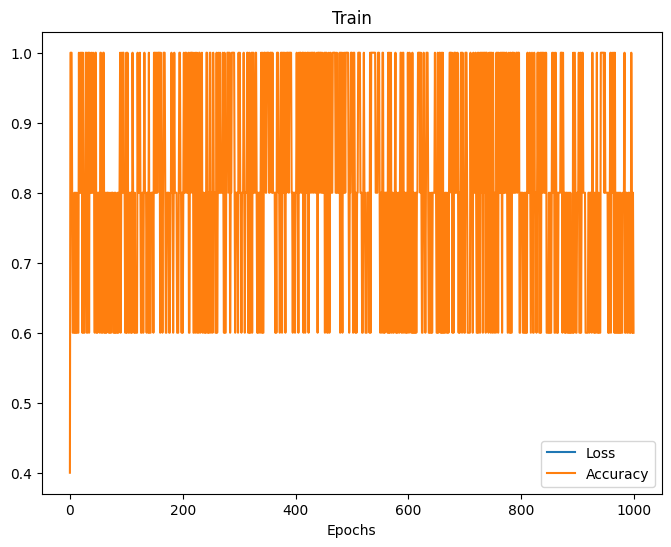

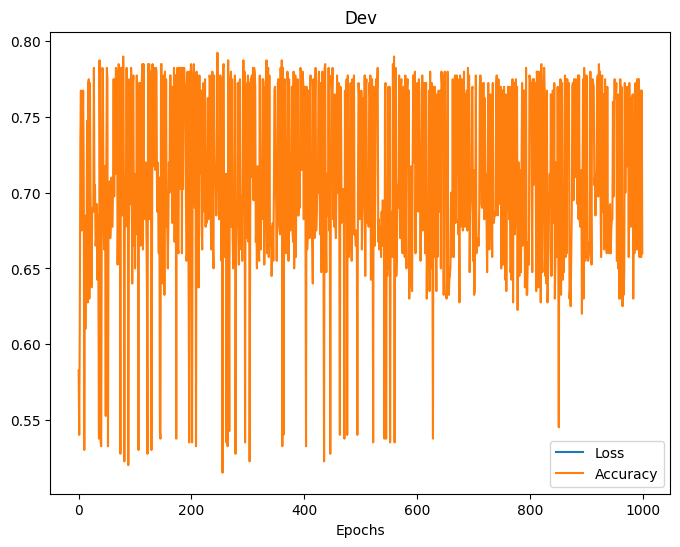


Training Model by learning rate: 1000
Epoch 10/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7750
Epoch 20/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6775
Epoch 30/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7350
Epoch 40/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7200
Epoch 50/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7175
Epoch 60/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.5400
Epoch 70/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7800
Epoch 80/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7825
Epoch 90/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7875
Epoch 100/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7175
Epoch 110/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.5225
Epoch 120/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.712

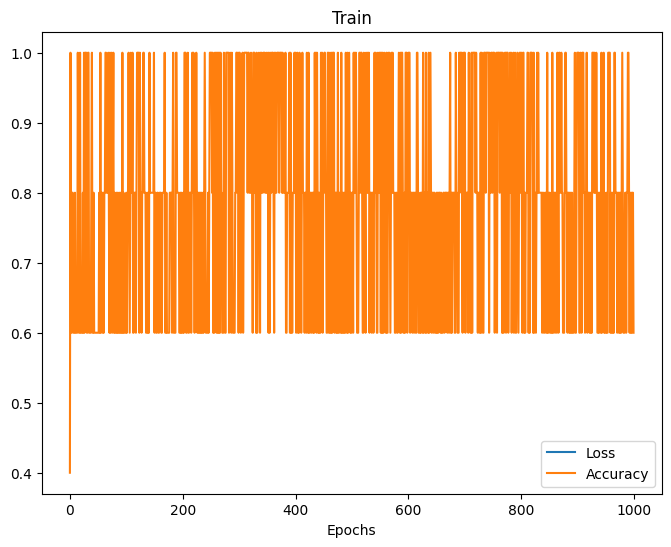

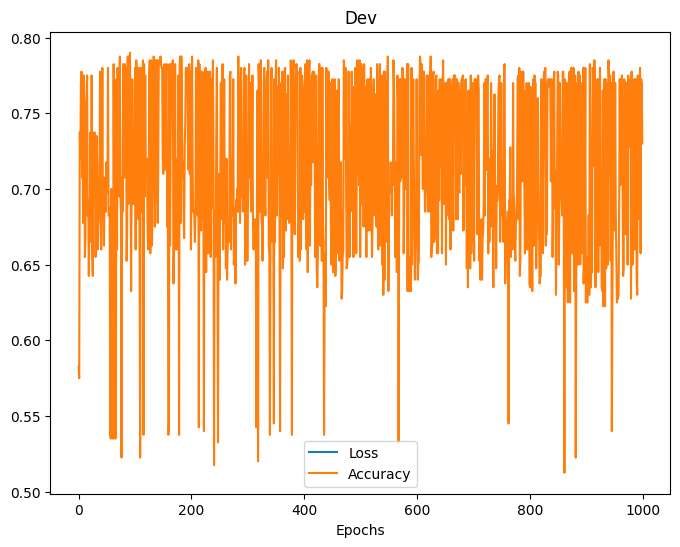


Training Model by learning rate: 100
Epoch 10/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6700
Epoch 20/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.6025
Epoch 30/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6975
Epoch 40/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7900
Epoch 50/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7800
Epoch 60/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6525
Epoch 70/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7075
Epoch 80/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7225
Epoch 90/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7925
Epoch 100/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7850
Epoch 110/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6900
Epoch 120/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7825

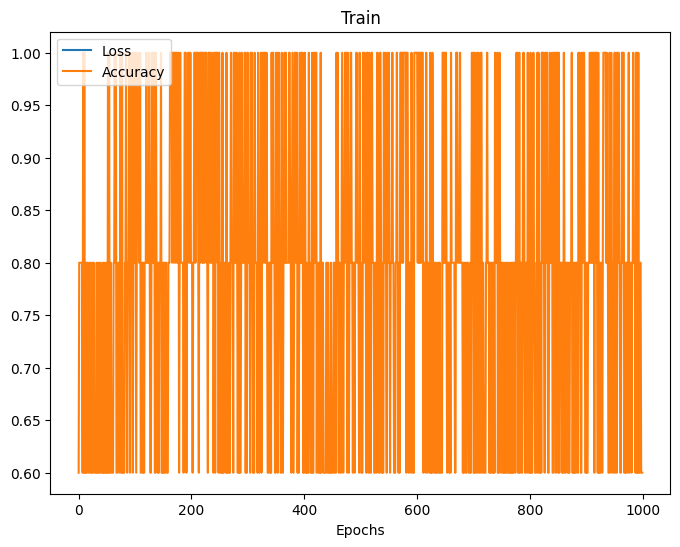

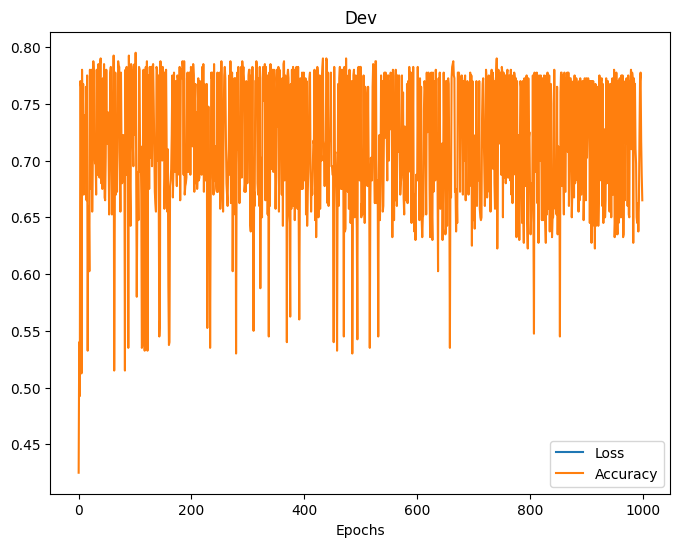


Training Model by learning rate: 10
Epoch 10/1000, Loss: 2.2208, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6950
Epoch 20/1000, Loss: 2.8036, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7100
Epoch 30/1000, Loss: 3.3337, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7150
Epoch 40/1000, Loss: 3.5303, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7025
Epoch 50/1000, Loss: 1.3989, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7650
Epoch 60/1000, Loss: 3.5565, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7200
Epoch 70/1000, Loss: 2.7246, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7225
Epoch 80/1000, Loss: 0.0003, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7000
Epoch 90/1000, Loss: 1.0700, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7900
Epoch 100/1000, Loss: 0.9592, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7900
Epoch 110/1000, Loss: 0.9822, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7875
Epoch 120/1000, Loss: 1.3950, Accuracy: 0.8000, 

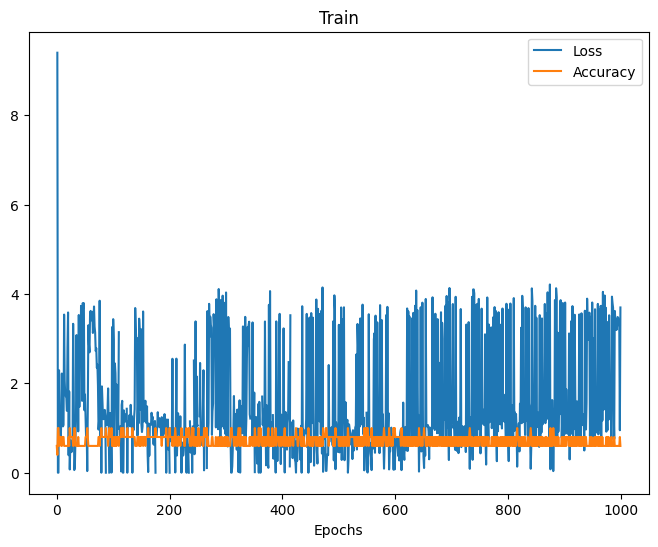

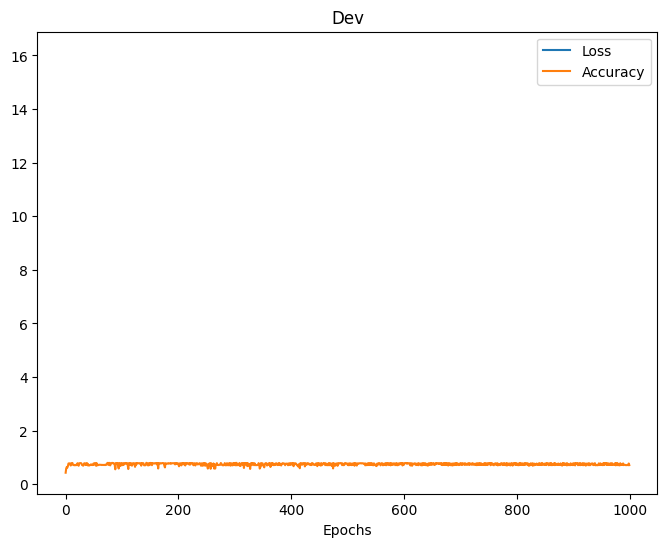


Training Model by learning rate: 1
Epoch 10/1000, Loss: 0.2281, Accuracy: 1.0000, Dev Loss: 0.5333, Dev Accuracy: 0.7650
Epoch 20/1000, Loss: 0.2031, Accuracy: 1.0000, Dev Loss: 0.5536, Dev Accuracy: 0.7575
Epoch 30/1000, Loss: 0.2041, Accuracy: 1.0000, Dev Loss: 0.5595, Dev Accuracy: 0.7500
Epoch 40/1000, Loss: 0.2048, Accuracy: 1.0000, Dev Loss: 0.5638, Dev Accuracy: 0.7475
Epoch 50/1000, Loss: 0.2045, Accuracy: 1.0000, Dev Loss: 0.5668, Dev Accuracy: 0.7525
Epoch 60/1000, Loss: 0.2037, Accuracy: 1.0000, Dev Loss: 0.5688, Dev Accuracy: 0.7475
Epoch 70/1000, Loss: 0.2027, Accuracy: 1.0000, Dev Loss: 0.5700, Dev Accuracy: 0.7450
Epoch 80/1000, Loss: 0.2017, Accuracy: 1.0000, Dev Loss: 0.5707, Dev Accuracy: 0.7450
Epoch 90/1000, Loss: 0.2007, Accuracy: 1.0000, Dev Loss: 0.5711, Dev Accuracy: 0.7450
Epoch 100/1000, Loss: 0.1998, Accuracy: 1.0000, Dev Loss: 0.5712, Dev Accuracy: 0.7450
Epoch 110/1000, Loss: 0.1990, Accuracy: 1.0000, Dev Loss: 0.5713, Dev Accuracy: 0.7475
Epoch 120/1000, 

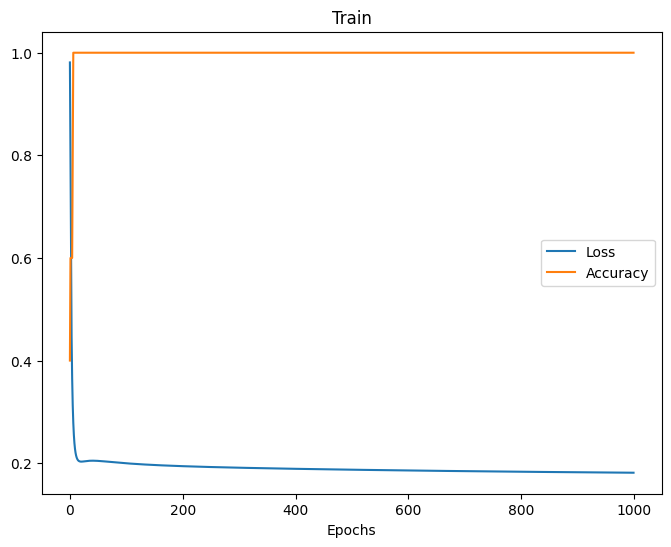

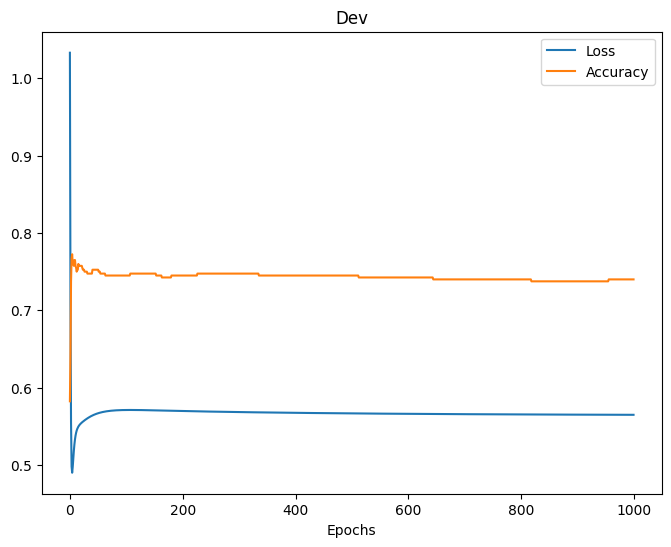


Training Model by learning rate: 0.01
Epoch 10/1000, Loss: 0.6296, Accuracy: 0.6000, Dev Loss: 0.6470, Dev Accuracy: 0.6300
Epoch 20/1000, Loss: 0.5937, Accuracy: 0.6000, Dev Loss: 0.6214, Dev Accuracy: 0.7150
Epoch 30/1000, Loss: 0.5667, Accuracy: 0.6000, Dev Loss: 0.6019, Dev Accuracy: 0.7475
Epoch 40/1000, Loss: 0.5457, Accuracy: 0.6000, Dev Loss: 0.5866, Dev Accuracy: 0.7650
Epoch 50/1000, Loss: 0.5288, Accuracy: 0.6000, Dev Loss: 0.5743, Dev Accuracy: 0.7600
Epoch 60/1000, Loss: 0.5149, Accuracy: 0.6000, Dev Loss: 0.5643, Dev Accuracy: 0.7675
Epoch 70/1000, Loss: 0.5031, Accuracy: 0.6000, Dev Loss: 0.5559, Dev Accuracy: 0.7675
Epoch 80/1000, Loss: 0.4930, Accuracy: 0.6000, Dev Loss: 0.5489, Dev Accuracy: 0.7725
Epoch 90/1000, Loss: 0.4840, Accuracy: 0.6000, Dev Loss: 0.5428, Dev Accuracy: 0.7700
Epoch 100/1000, Loss: 0.4761, Accuracy: 0.6000, Dev Loss: 0.5376, Dev Accuracy: 0.7700
Epoch 110/1000, Loss: 0.4689, Accuracy: 0.6000, Dev Loss: 0.5330, Dev Accuracy: 0.7700
Epoch 120/100

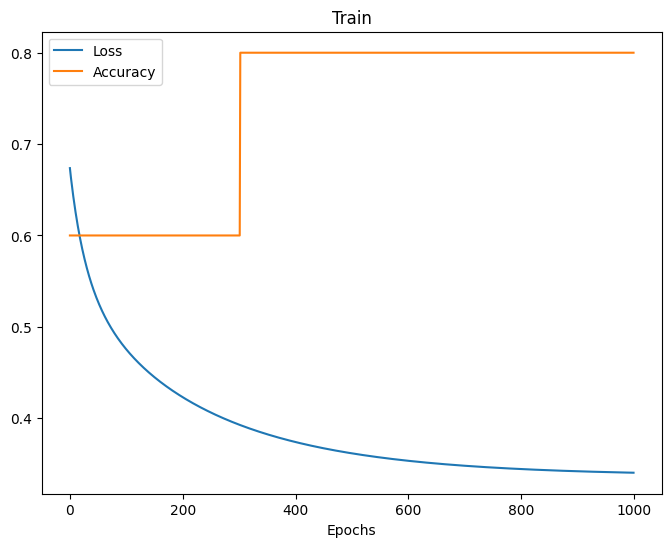

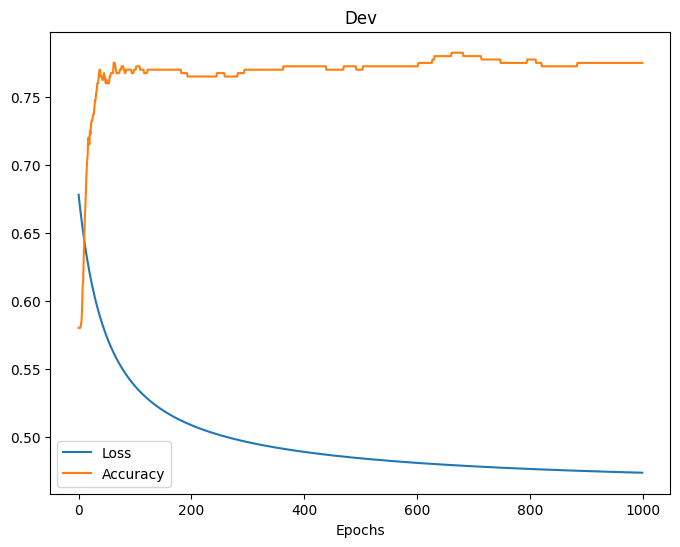


Training Model by learning rate: 0.001
Epoch 10/1000, Loss: 0.6726, Accuracy: 0.6000, Dev Loss: 0.6777, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6667, Accuracy: 0.6000, Dev Loss: 0.6736, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6614, Accuracy: 0.6000, Dev Loss: 0.6698, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6563, Accuracy: 0.6000, Dev Loss: 0.6662, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6513, Accuracy: 0.6000, Dev Loss: 0.6626, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6466, Accuracy: 0.6000, Dev Loss: 0.6592, Dev Accuracy: 0.5850
Epoch 70/1000, Loss: 0.6419, Accuracy: 0.6000, Dev Loss: 0.6559, Dev Accuracy: 0.5925
Epoch 80/1000, Loss: 0.6375, Accuracy: 0.6000, Dev Loss: 0.6527, Dev Accuracy: 0.6000
Epoch 90/1000, Loss: 0.6331, Accuracy: 0.6000, Dev Loss: 0.6496, Dev Accuracy: 0.6125
Epoch 100/1000, Loss: 0.6289, Accuracy: 0.6000, Dev Loss: 0.6466, Dev Accuracy: 0.6175
Epoch 110/1000, Loss: 0.6249, Accuracy: 0.6000, Dev Loss: 0.6437, Dev Accuracy: 0.6300
Epoch 120/10

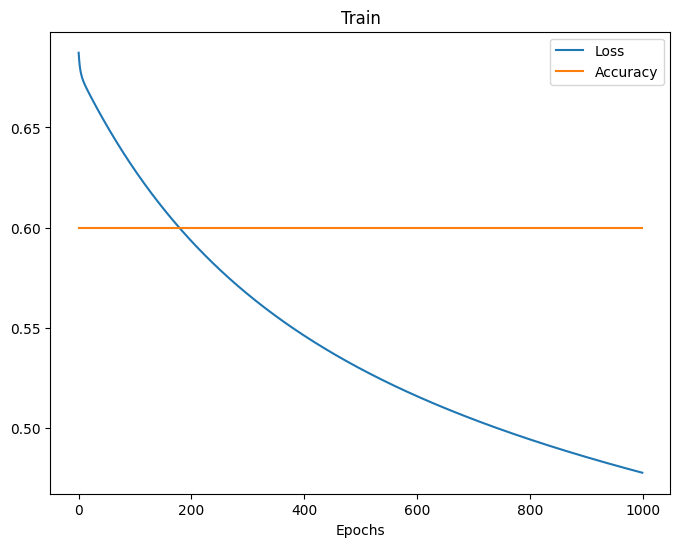

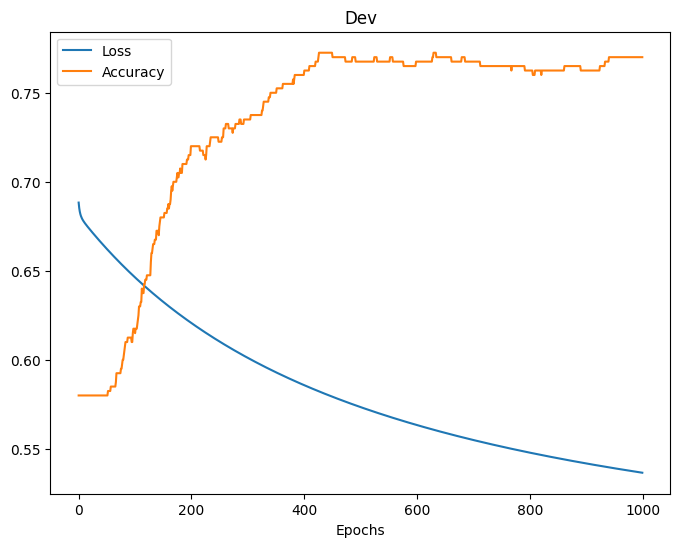


Training Model by learning rate: 0.0001
Epoch 10/1000, Loss: 0.6872, Accuracy: 0.6000, Dev Loss: 0.6883, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6832, Accuracy: 0.6000, Dev Loss: 0.6853, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6805, Accuracy: 0.6000, Dev Loss: 0.6833, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6786, Accuracy: 0.6000, Dev Loss: 0.6819, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6771, Accuracy: 0.6000, Dev Loss: 0.6808, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6759, Accuracy: 0.6000, Dev Loss: 0.6800, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6749, Accuracy: 0.6000, Dev Loss: 0.6793, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6740, Accuracy: 0.6000, Dev Loss: 0.6787, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6732, Accuracy: 0.6000, Dev Loss: 0.6782, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6725, Accuracy: 0.6000, Dev Loss: 0.6777, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6719, Accuracy: 0.6000, Dev Loss: 0.6772, Dev Accuracy: 0.5800
Epoch 120/1

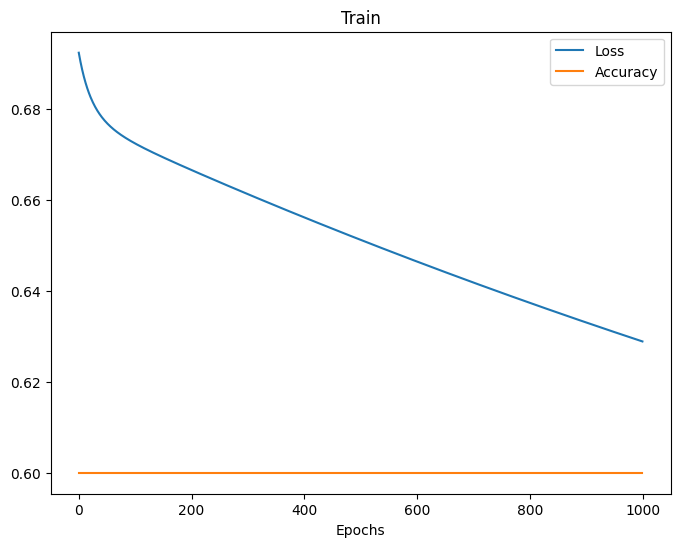

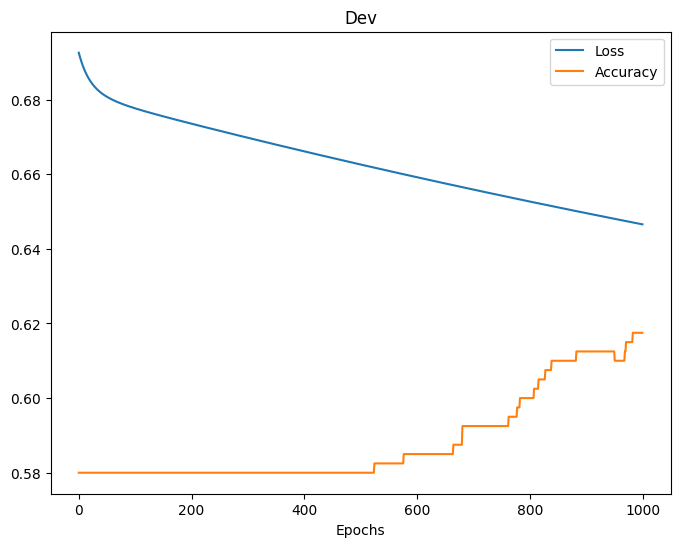


Training Model by learning rate: 1e-05
Epoch 10/1000, Loss: 0.6924, Accuracy: 0.6000, Dev Loss: 0.6926, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6917, Accuracy: 0.6000, Dev Loss: 0.6920, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6911, Accuracy: 0.6000, Dev Loss: 0.6914, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6904, Accuracy: 0.6000, Dev Loss: 0.6909, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6898, Accuracy: 0.6000, Dev Loss: 0.6904, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6893, Accuracy: 0.6000, Dev Loss: 0.6900, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6887, Accuracy: 0.6000, Dev Loss: 0.6895, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6882, Accuracy: 0.6000, Dev Loss: 0.6891, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6877, Accuracy: 0.6000, Dev Loss: 0.6887, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6872, Accuracy: 0.6000, Dev Loss: 0.6883, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6867, Accuracy: 0.6000, Dev Loss: 0.6880, Dev Accuracy: 0.5800
Epoch 120/10

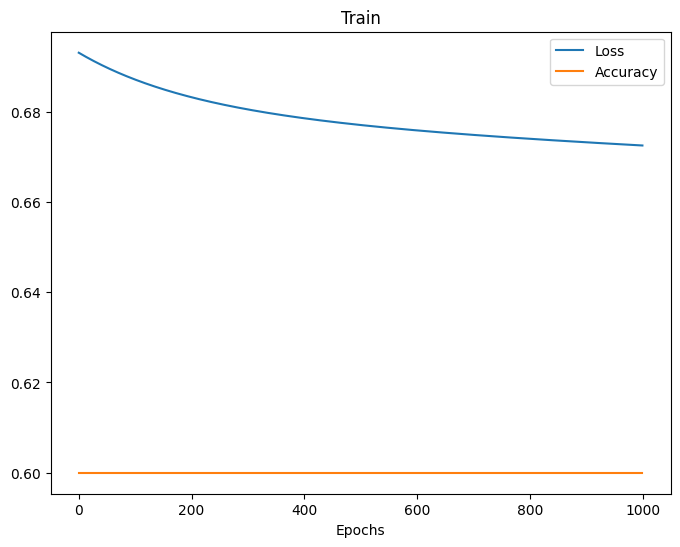

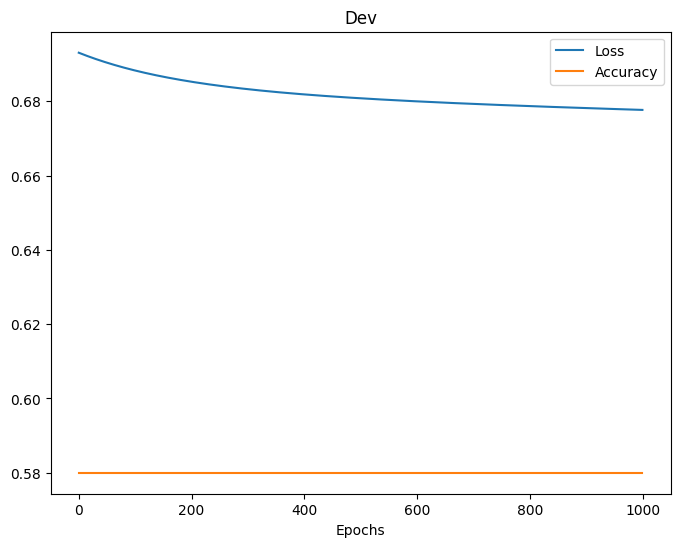

In [ ]:
learning_rates = [10000, 1000, 100, 10, 1, 0.01, 0.001, 0.0001, 0.00001]
bests, train_accuracies, train_losses , dev_accuracies, dev_losses = [], [], [], [], []

# train model by learning rates
for lr in learning_rates:
  print(f"\nTraining Model by learning rate: {lr}")
  best = logistic_regression_classifier(train, dev, batch_size = 16, epochs = 1000, learning_rate = lr)

  bests.append(best)
  train_accuracies.append(best["Train Acc"])
  train_losses.append(best["Train Loss"])
  dev_accuracies.append(best["Dev Acc"])
  dev_losses.append(best["Dev Loss"])


In [ ]:
results = {
    "Learning Rate": learning_rates,
    "Train Acc": [train_accuracies[i][-1] for i in range(len(learning_rates))],
    "Train Loss": [train_losses[i][-1] for i in range(len(learning_rates))],
    "Dev Acc": [dev_accuracies[i][-1] for i in range(len(learning_rates))],
    "Dev Loss": [dev_losses[i][-1] for i in range(len(learning_rates))],
    "Best Dev Acc": [bests[i]["best_dev_acc"] for i in range(len(learning_rates))],
    # lr is overflow when loss is NAN
    "Overflow": [1 if np.isnan(train_losses[i][-1]) or np.isnan(dev_losses[i][-1]) else 0 for i in range(len(learning_rates))]
}

# checking the acc and loss results by last parameters and Best acc.
pd.DataFrame(results)

Learning Rate  Train Acc  Train Loss  Dev Acc  Dev Loss  Best Dev Acc  \
0    10000.00000        0.6         NaN   0.6600       NaN        0.7925   
1     1000.00000        0.6         NaN   0.7300       NaN        0.7900   
2      100.00000        0.6         NaN   0.6650       NaN        0.7950   
3       10.00000        0.6    3.699501   0.7125       NaN        0.7975   
4        1.00000        1.0    0.181386   0.7400  0.565034        0.7725   
5        0.01000        0.8    0.340350   0.7750  0.473440        0.7825   
6        0.00100        0.6    0.477677   0.7700  0.536608        0.7725   
7        0.00010        0.6    0.628895   0.6175  0.646562        0.6175   
8        0.00001        0.6    0.672518   0.5800  0.677688        0.5800   

   Overflow  
0         1  
1         1  
2         1  
3         1  
4         0  
5         0  
6         0  
7         0  
8         0

## small learning rate with more iterations

Epoch 10/10000, Loss: 0.6872, Accuracy: 0.6000, Dev Loss: 0.6883, Dev Accuracy: 0.5800
Epoch 20/10000, Loss: 0.6832, Accuracy: 0.6000, Dev Loss: 0.6853, Dev Accuracy: 0.5800
Epoch 30/10000, Loss: 0.6805, Accuracy: 0.6000, Dev Loss: 0.6833, Dev Accuracy: 0.5800
Epoch 40/10000, Loss: 0.6786, Accuracy: 0.6000, Dev Loss: 0.6819, Dev Accuracy: 0.5800
Epoch 50/10000, Loss: 0.6771, Accuracy: 0.6000, Dev Loss: 0.6808, Dev Accuracy: 0.5800
Epoch 60/10000, Loss: 0.6759, Accuracy: 0.6000, Dev Loss: 0.6800, Dev Accuracy: 0.5800
Epoch 70/10000, Loss: 0.6749, Accuracy: 0.6000, Dev Loss: 0.6793, Dev Accuracy: 0.5800
Epoch 80/10000, Loss: 0.6740, Accuracy: 0.6000, Dev Loss: 0.6787, Dev Accuracy: 0.5800
Epoch 90/10000, Loss: 0.6732, Accuracy: 0.6000, Dev Loss: 0.6782, Dev Accuracy: 0.5800
Epoch 100/10000, Loss: 0.6725, Accuracy: 0.6000, Dev Loss: 0.6777, Dev Accuracy: 0.5800
Epoch 110/10000, Loss: 0.6719, Accuracy: 0.6000, Dev Loss: 0.6772, Dev Accuracy: 0.5800
Epoch 120/10000, Loss: 0.6712, Accuracy: 

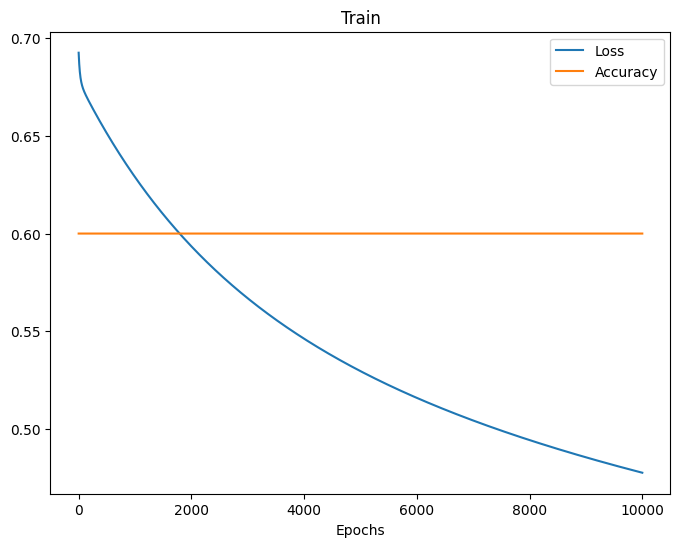

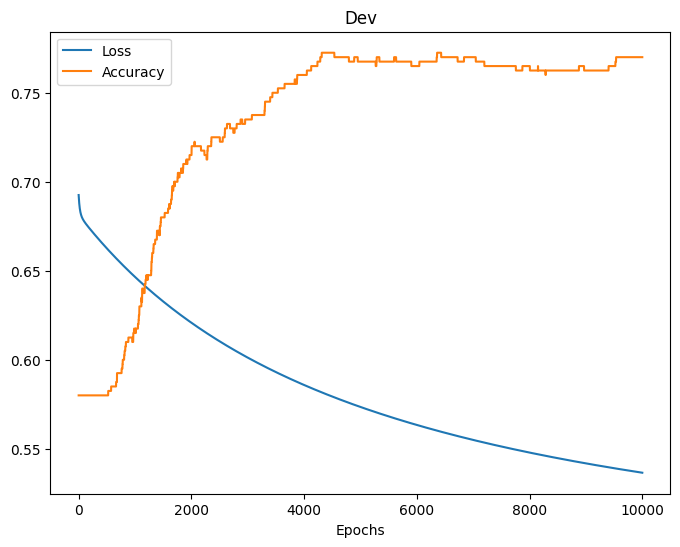

{'best_dev_acc': 0.7725,
 'dev_loss': 0.5816879204048279,
 'best_epoch': 4312,
 'best_batch_size': 16,
 'best_lr': 0.0001,
 'best_lambda': 0,
 'best_weights': array([-0.22368337,  1.59208138, -0.83358827,  0.35893   ,  0.70119208,
        -0.03192688, -0.54276771, -0.18056485,  0.12401963,  0.205189  ,
         0.22957388,  0.35444266,  0.01388464, -0.2659391 , -0.30675587,
        -0.35497246,  0.26608627,  0.32612012, -0.29181464, -0.23937595,
         0.00817136,  0.85726489, -0.20010124,  0.34587288,  0.45446816,
        -0.05697834, -0.48801681, -0.81274311, -0.46859858, -0.22870457,
         0.3299071 ,  0.42454065,  0.11050523, -0.11316053,  0.47497542,
        -0.07293556, -0.71388242,  0.58228938, -0.38384527,  0.02216648,
         0.78383724,  0.28660924, -0.39705015, -0.61275221,  0.31173939,
         0.72481216,  0.15468124, -0.6807141 , -0.97205998,  0.18752346]),
 'best_bias': 0.03047725441492564,
 'Train Acc': [0.6,
  0.6,
  0.6,
  0.6,
  0.6,
  0.6,
  0.6,
  0.6,
  0.6,

In [ ]:
# Try to use 10000 iterations for the learning rate 0.0001
logistic_regression_classifier(train, dev, batch_size = 16, epochs = 10000, learning_rate = 0.0001)
# Best Validation Accuracy: 0.7725 achieved at Epoch 4312 using lr=0.0001 and batch_size=16

## Plot the training accuracy, the validation accuracy of your model by lr


Training Model by learning rate: 100


<ipython-input-8-c1927be7dc8c>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-1 * (f_wb))) # sigmoid
<ipython-input-8-c1927be7dc8c>:13: RuntimeWarning: divide by zero encountered in log
  loss = -1 * np.mean((y * np.log(y_pred)) + (1 - y) * np.log(1 - y_pred))
<ipython-input-8-c1927be7dc8c>:13: RuntimeWarning: invalid value encountered in multiply
  loss = -1 * np.mean((y * np.log(y_pred)) + (1 - y) * np.log(1 - y_pred))


Epoch 10/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6700
Epoch 20/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.6025
Epoch 30/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6975
Epoch 40/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7900
Epoch 50/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7800
Epoch 60/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6525
Epoch 70/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7075
Epoch 80/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7225
Epoch 90/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7925
Epoch 100/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7850
Epoch 110/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6900
Epoch 120/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7825
Epoch 130/1000, Loss: nan, Accuracy: 

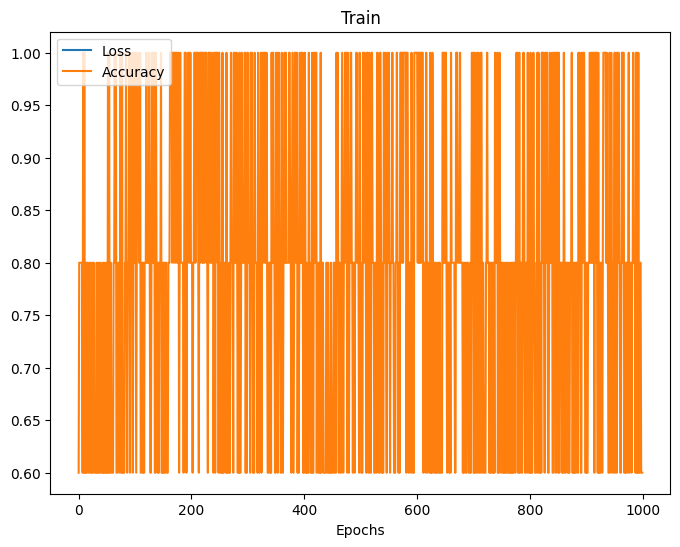

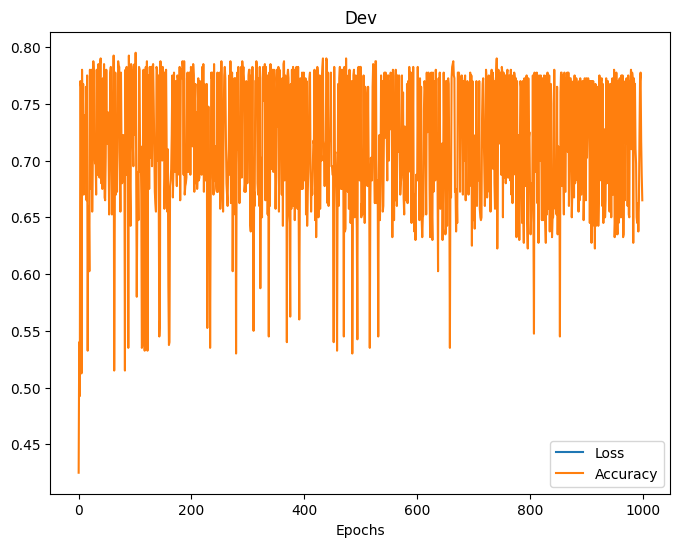


Training Model by learning rate: 0.1
Epoch 10/1000, Loss: 0.4666, Accuracy: 0.6000, Dev Loss: 0.5504, Dev Accuracy: 0.7400
Epoch 20/1000, Loss: 0.4134, Accuracy: 0.6000, Dev Loss: 0.5229, Dev Accuracy: 0.7550
Epoch 30/1000, Loss: 0.3849, Accuracy: 0.8000, Dev Loss: 0.5098, Dev Accuracy: 0.7550
Epoch 40/1000, Loss: 0.3670, Accuracy: 0.8000, Dev Loss: 0.5019, Dev Accuracy: 0.7625
Epoch 50/1000, Loss: 0.3552, Accuracy: 0.8000, Dev Loss: 0.4967, Dev Accuracy: 0.7675
Epoch 60/1000, Loss: 0.3474, Accuracy: 0.8000, Dev Loss: 0.4929, Dev Accuracy: 0.7725
Epoch 70/1000, Loss: 0.3422, Accuracy: 0.8000, Dev Loss: 0.4901, Dev Accuracy: 0.7725
Epoch 80/1000, Loss: 0.3386, Accuracy: 0.8000, Dev Loss: 0.4879, Dev Accuracy: 0.7750
Epoch 90/1000, Loss: 0.3361, Accuracy: 0.8000, Dev Loss: 0.4863, Dev Accuracy: 0.7750
Epoch 100/1000, Loss: 0.3344, Accuracy: 0.8000, Dev Loss: 0.4850, Dev Accuracy: 0.7725
Epoch 110/1000, Loss: 0.3333, Accuracy: 0.8000, Dev Loss: 0.4840, Dev Accuracy: 0.7775
Epoch 120/1000

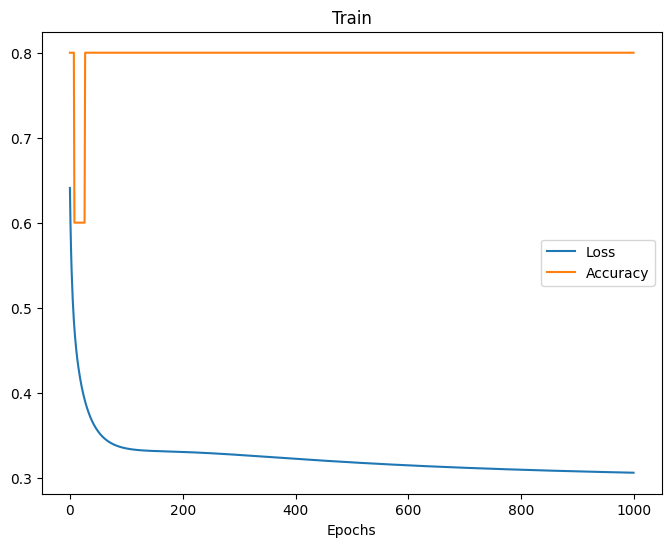

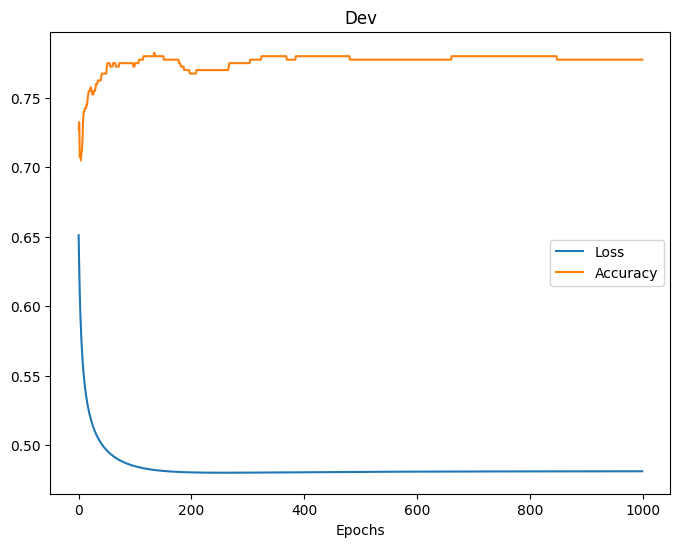


Training Model by learning rate: 0.001
Epoch 10/1000, Loss: 0.6726, Accuracy: 0.6000, Dev Loss: 0.6777, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6667, Accuracy: 0.6000, Dev Loss: 0.6736, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6614, Accuracy: 0.6000, Dev Loss: 0.6698, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6563, Accuracy: 0.6000, Dev Loss: 0.6662, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6513, Accuracy: 0.6000, Dev Loss: 0.6626, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6466, Accuracy: 0.6000, Dev Loss: 0.6592, Dev Accuracy: 0.5850
Epoch 70/1000, Loss: 0.6419, Accuracy: 0.6000, Dev Loss: 0.6559, Dev Accuracy: 0.5925
Epoch 80/1000, Loss: 0.6375, Accuracy: 0.6000, Dev Loss: 0.6527, Dev Accuracy: 0.6000
Epoch 90/1000, Loss: 0.6331, Accuracy: 0.6000, Dev Loss: 0.6496, Dev Accuracy: 0.6125
Epoch 100/1000, Loss: 0.6289, Accuracy: 0.6000, Dev Loss: 0.6466, Dev Accuracy: 0.6175
Epoch 110/1000, Loss: 0.6249, Accuracy: 0.6000, Dev Loss: 0.6437, Dev Accuracy: 0.6300
Epoch 120/10

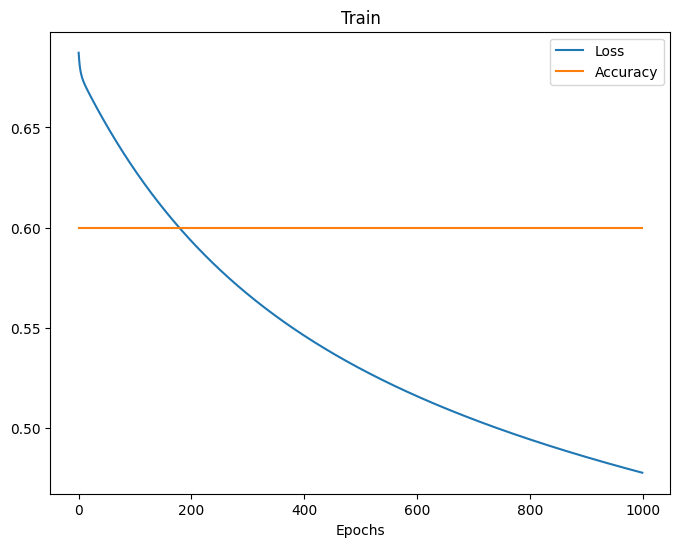

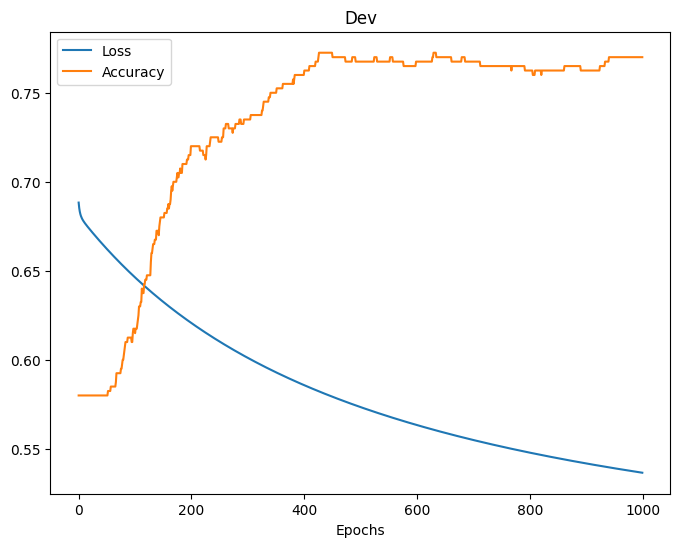


Training Model by learning rate: 1e-05
Epoch 10/1000, Loss: 0.6924, Accuracy: 0.6000, Dev Loss: 0.6926, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6917, Accuracy: 0.6000, Dev Loss: 0.6920, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6911, Accuracy: 0.6000, Dev Loss: 0.6914, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6904, Accuracy: 0.6000, Dev Loss: 0.6909, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6898, Accuracy: 0.6000, Dev Loss: 0.6904, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6893, Accuracy: 0.6000, Dev Loss: 0.6900, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6887, Accuracy: 0.6000, Dev Loss: 0.6895, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6882, Accuracy: 0.6000, Dev Loss: 0.6891, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6877, Accuracy: 0.6000, Dev Loss: 0.6887, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6872, Accuracy: 0.6000, Dev Loss: 0.6883, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6867, Accuracy: 0.6000, Dev Loss: 0.6880, Dev Accuracy: 0.5800
Epoch 120/10

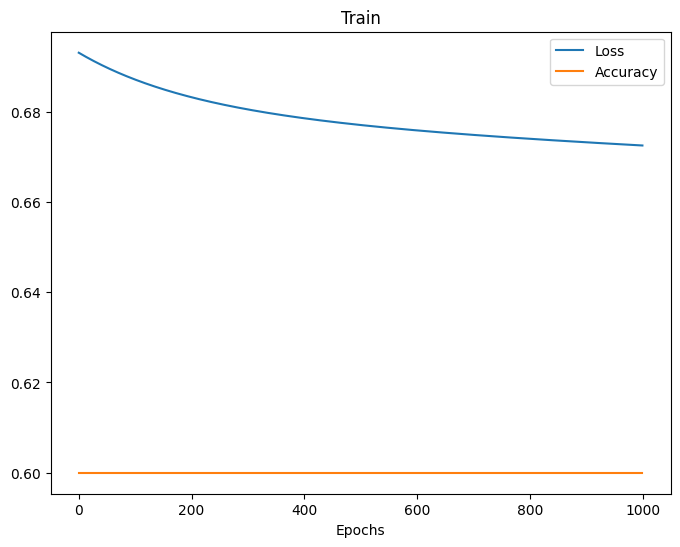

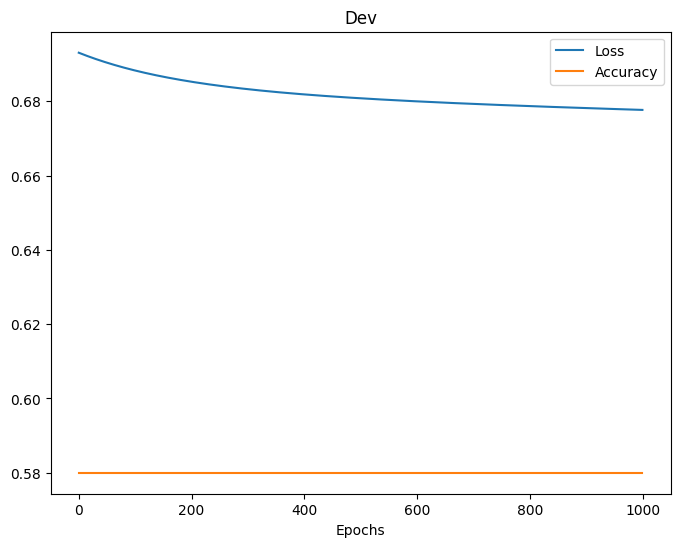

In [ ]:
learning_rates = [100, 0.1, 0.001, 0.00001]
bests, train_accuracies, train_losses , dev_accuracies, dev_losses = [], [], [], [], []

# train model by learning rates
for lr in learning_rates:
  print(f"\nTraining Model by learning rate: {lr}")
  best = logistic_regression_classifier(train, dev, batch_size = 16, epochs = 1000, learning_rate = lr)

  bests.append(best)
  train_accuracies.append(best["Train Acc"])
  train_losses.append(best["Train Loss"])
  dev_accuracies.append(best["Dev Acc"])
  dev_losses.append(best["Dev Loss"])

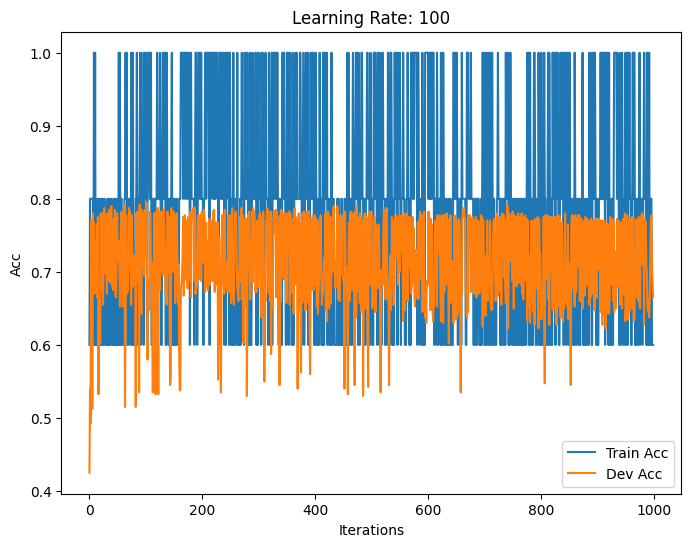

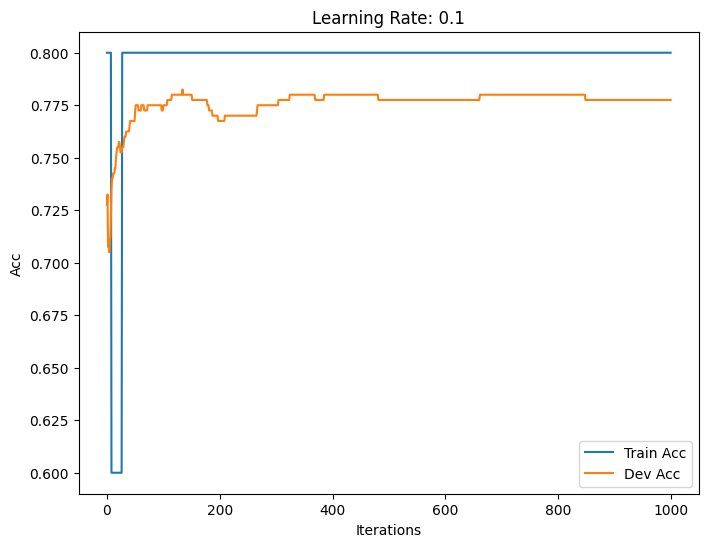

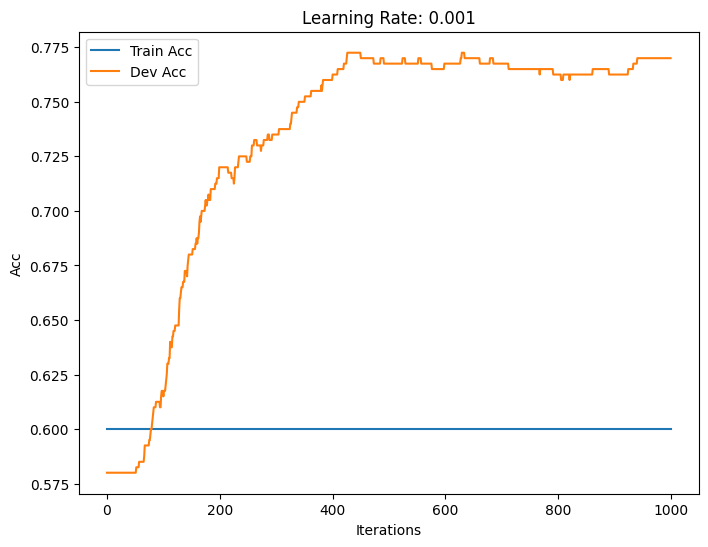

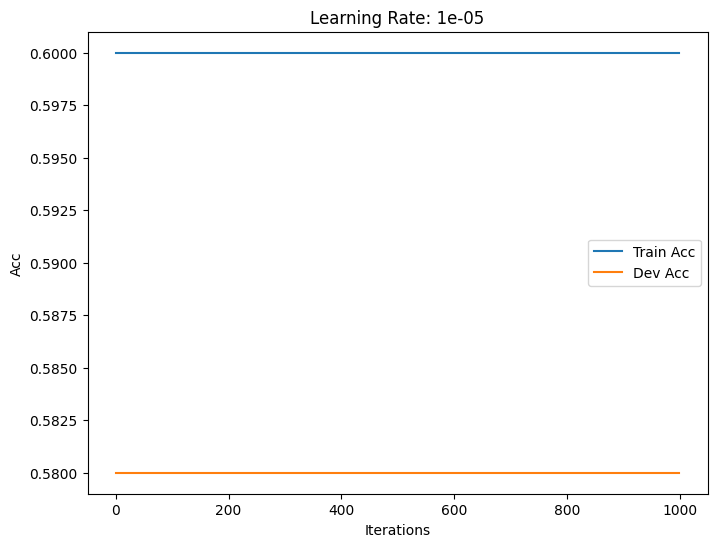

In [ ]:
results_Q2 = {
    "Learning Rate": learning_rates,
    "Train Acc": 100 * train_accuracies,
    "Dev Acc": 100 * dev_accuracies,
}

# plotting train and dev acc per lr
for i in range(len(learning_rates)):
  plt.figure(figsize=(8, 6))
  for acc in ["Train Acc", "Dev Acc"]:
      plt.plot(results_Q2[acc][i], label=acc)
  plt.xlabel("Iterations")
  plt.ylabel("Acc")
  plt.title(str(f"Learning Rate: {learning_rates[i]}"))
  plt.legend()
  plt.show()

## Plot the training loss, the validation loss of your model by lr


Training Model by learning rate: 100


<ipython-input-8-c1927be7dc8c>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-1 * (f_wb))) # sigmoid
<ipython-input-8-c1927be7dc8c>:13: RuntimeWarning: divide by zero encountered in log
  loss = -1 * np.mean((y * np.log(y_pred)) + (1 - y) * np.log(1 - y_pred))
<ipython-input-8-c1927be7dc8c>:13: RuntimeWarning: invalid value encountered in multiply
  loss = -1 * np.mean((y * np.log(y_pred)) + (1 - y) * np.log(1 - y_pred))


Epoch 10/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6700
Epoch 20/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.6025
Epoch 30/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6975
Epoch 40/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7900
Epoch 50/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7800
Epoch 60/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6525
Epoch 70/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7075
Epoch 80/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.7225
Epoch 90/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7925
Epoch 100/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7850
Epoch 110/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6900
Epoch 120/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7825
Epoch 130/1000, Loss: nan, Accuracy: 

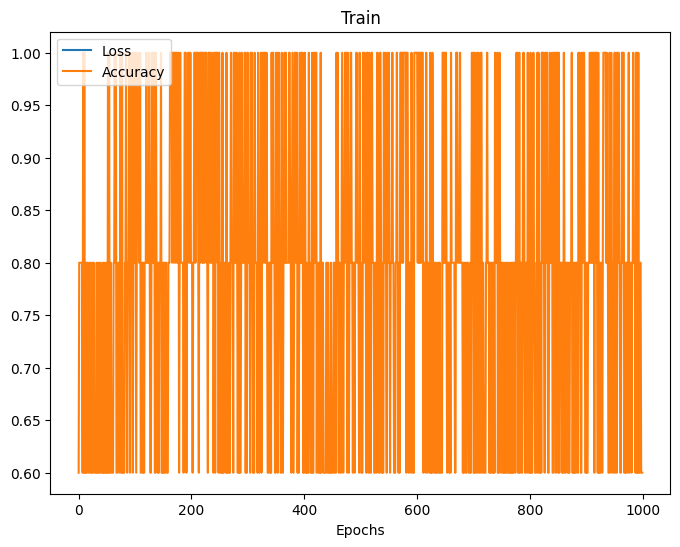

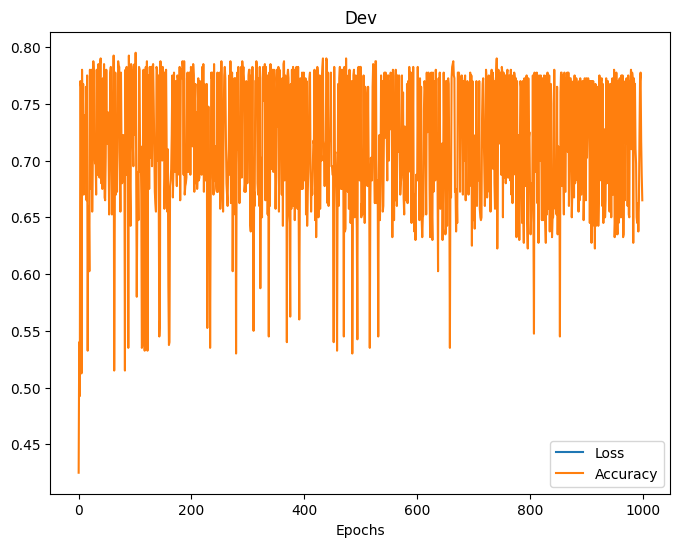


Training Model by learning rate: 0.1
Epoch 10/1000, Loss: 0.4666, Accuracy: 0.6000, Dev Loss: 0.5504, Dev Accuracy: 0.7400
Epoch 20/1000, Loss: 0.4134, Accuracy: 0.6000, Dev Loss: 0.5229, Dev Accuracy: 0.7550
Epoch 30/1000, Loss: 0.3849, Accuracy: 0.8000, Dev Loss: 0.5098, Dev Accuracy: 0.7550
Epoch 40/1000, Loss: 0.3670, Accuracy: 0.8000, Dev Loss: 0.5019, Dev Accuracy: 0.7625
Epoch 50/1000, Loss: 0.3552, Accuracy: 0.8000, Dev Loss: 0.4967, Dev Accuracy: 0.7675
Epoch 60/1000, Loss: 0.3474, Accuracy: 0.8000, Dev Loss: 0.4929, Dev Accuracy: 0.7725
Epoch 70/1000, Loss: 0.3422, Accuracy: 0.8000, Dev Loss: 0.4901, Dev Accuracy: 0.7725
Epoch 80/1000, Loss: 0.3386, Accuracy: 0.8000, Dev Loss: 0.4879, Dev Accuracy: 0.7750
Epoch 90/1000, Loss: 0.3361, Accuracy: 0.8000, Dev Loss: 0.4863, Dev Accuracy: 0.7750
Epoch 100/1000, Loss: 0.3344, Accuracy: 0.8000, Dev Loss: 0.4850, Dev Accuracy: 0.7725
Epoch 110/1000, Loss: 0.3333, Accuracy: 0.8000, Dev Loss: 0.4840, Dev Accuracy: 0.7775
Epoch 120/1000

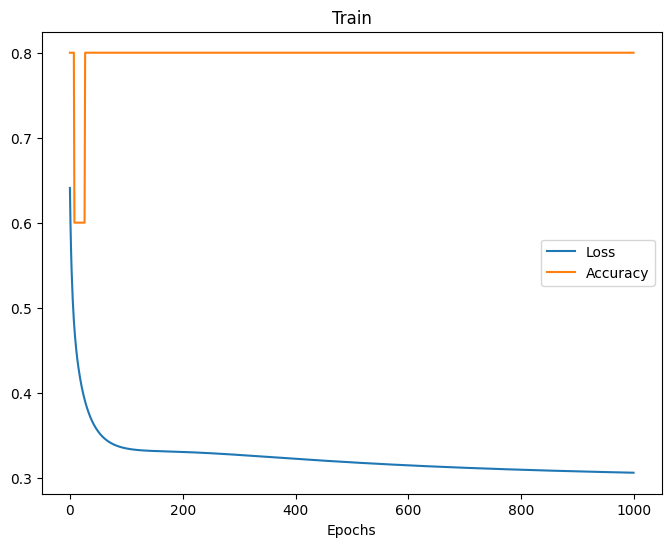

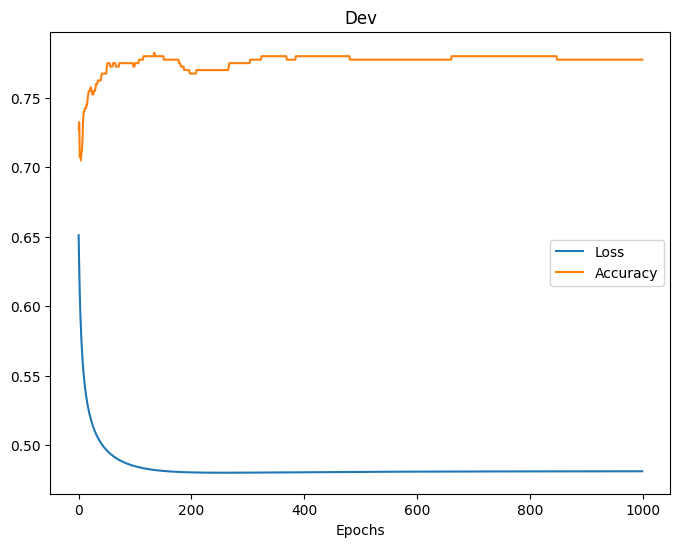


Training Model by learning rate: 0.001
Epoch 10/1000, Loss: 0.6726, Accuracy: 0.6000, Dev Loss: 0.6777, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6667, Accuracy: 0.6000, Dev Loss: 0.6736, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6614, Accuracy: 0.6000, Dev Loss: 0.6698, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6563, Accuracy: 0.6000, Dev Loss: 0.6662, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6513, Accuracy: 0.6000, Dev Loss: 0.6626, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6466, Accuracy: 0.6000, Dev Loss: 0.6592, Dev Accuracy: 0.5850
Epoch 70/1000, Loss: 0.6419, Accuracy: 0.6000, Dev Loss: 0.6559, Dev Accuracy: 0.5925
Epoch 80/1000, Loss: 0.6375, Accuracy: 0.6000, Dev Loss: 0.6527, Dev Accuracy: 0.6000
Epoch 90/1000, Loss: 0.6331, Accuracy: 0.6000, Dev Loss: 0.6496, Dev Accuracy: 0.6125
Epoch 100/1000, Loss: 0.6289, Accuracy: 0.6000, Dev Loss: 0.6466, Dev Accuracy: 0.6175
Epoch 110/1000, Loss: 0.6249, Accuracy: 0.6000, Dev Loss: 0.6437, Dev Accuracy: 0.6300
Epoch 120/10

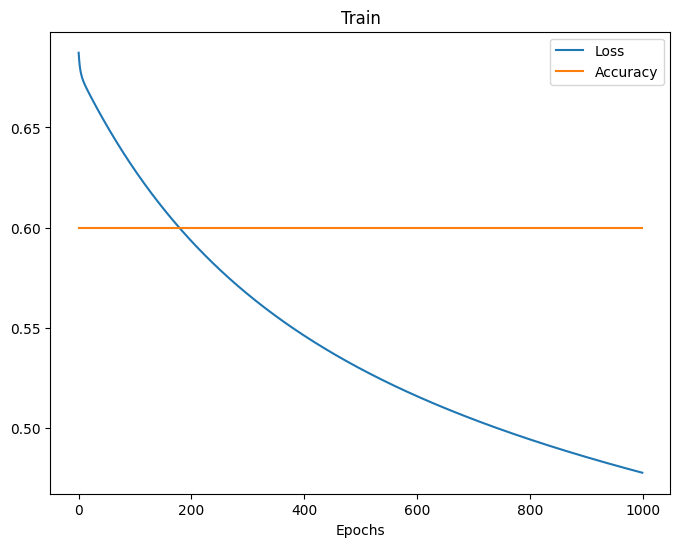

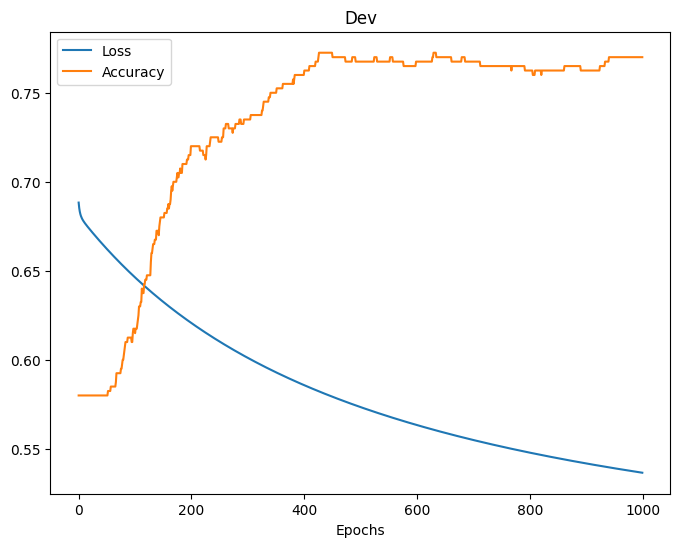


Training Model by learning rate: 1e-05
Epoch 10/1000, Loss: 0.6924, Accuracy: 0.6000, Dev Loss: 0.6926, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6917, Accuracy: 0.6000, Dev Loss: 0.6920, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6911, Accuracy: 0.6000, Dev Loss: 0.6914, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6904, Accuracy: 0.6000, Dev Loss: 0.6909, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6898, Accuracy: 0.6000, Dev Loss: 0.6904, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6893, Accuracy: 0.6000, Dev Loss: 0.6900, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6887, Accuracy: 0.6000, Dev Loss: 0.6895, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6882, Accuracy: 0.6000, Dev Loss: 0.6891, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6877, Accuracy: 0.6000, Dev Loss: 0.6887, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6872, Accuracy: 0.6000, Dev Loss: 0.6883, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6867, Accuracy: 0.6000, Dev Loss: 0.6880, Dev Accuracy: 0.5800
Epoch 120/10

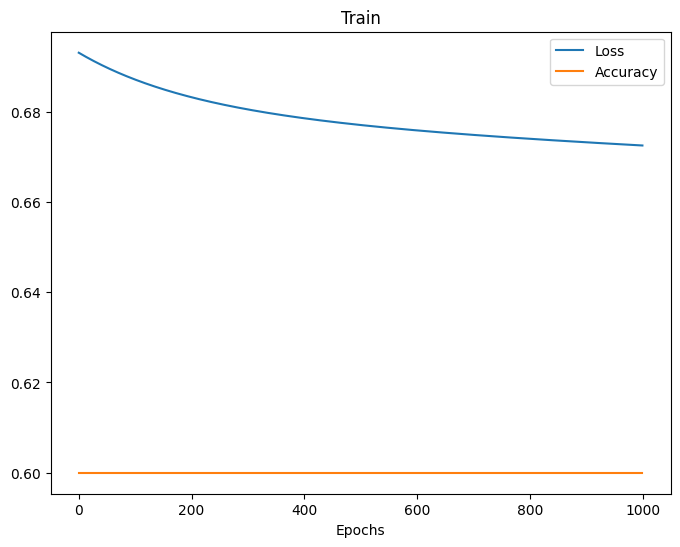

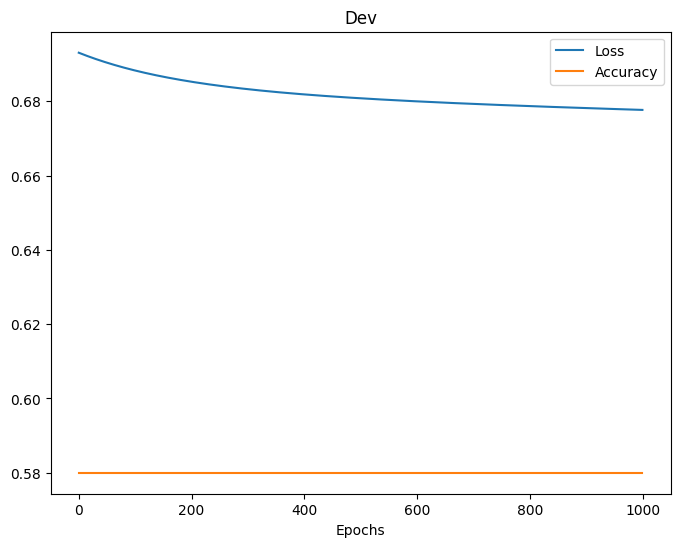

In [ ]:
learning_rates = [100, 0.1, 0.001, 0.00001]
bests, train_accuracies, train_losses , dev_accuracies, dev_losses = [], [], [], [], []

# train model by learning rates
for lr in learning_rates:
  print(f"\nTraining Model by learning rate: {lr}")
  best = logistic_regression_classifier(train, dev, batch_size = 16, epochs = 1000, learning_rate = lr)

  bests.append(best)
  train_accuracies.append(best["Train Acc"])
  train_losses.append(best["Train Loss"])
  dev_accuracies.append(best["Dev Acc"])
  dev_losses.append(best["Dev Loss"])

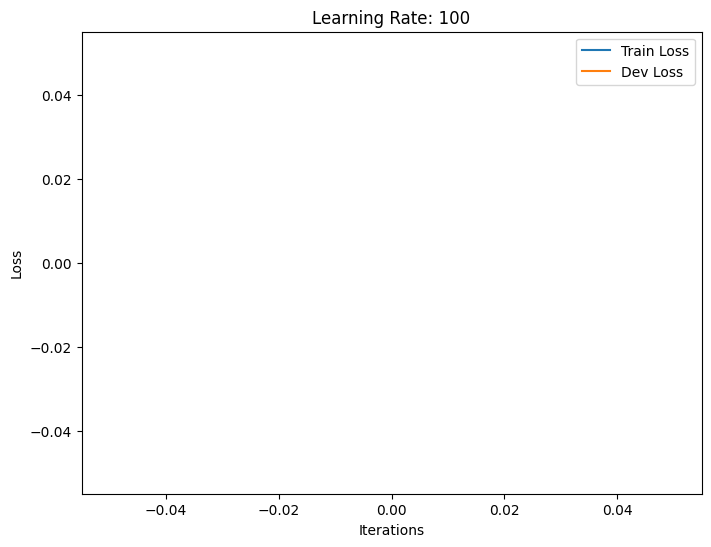

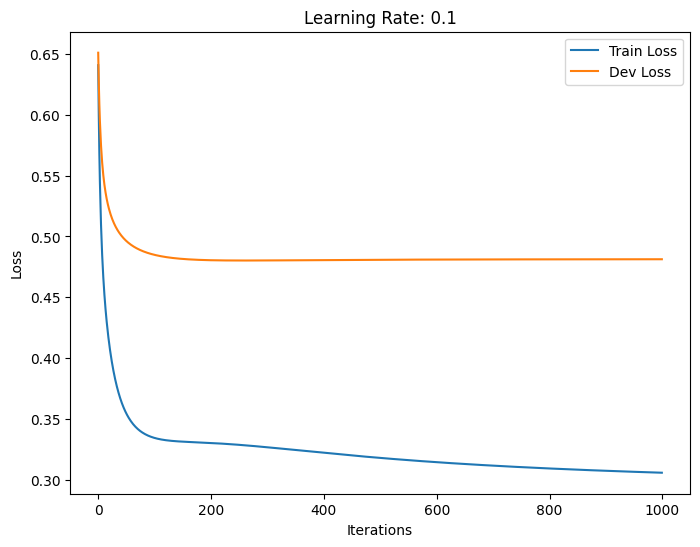

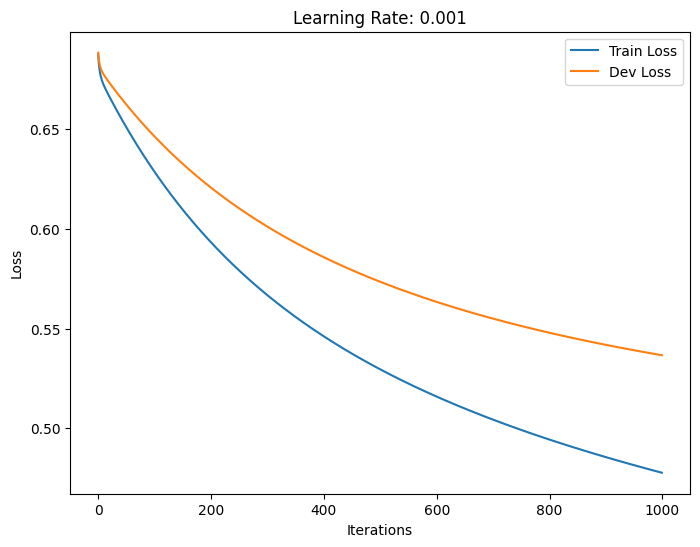

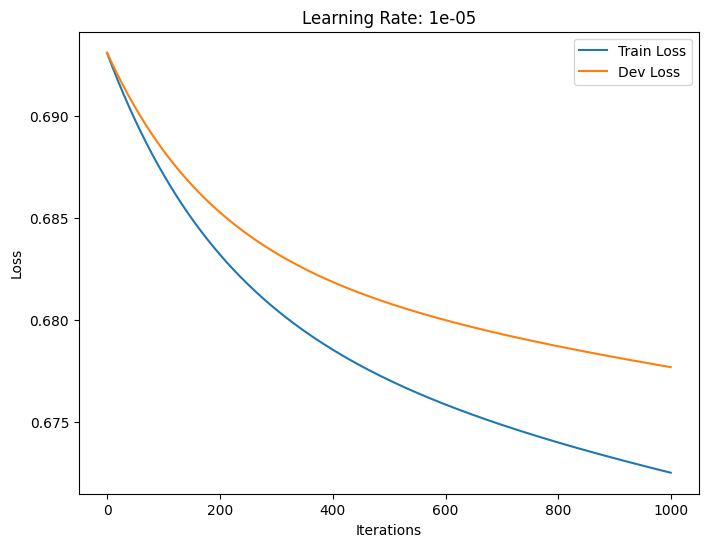

In [ ]:
results_Q3 = {
    "Learning Rate": learning_rates,
    "Train Loss": train_losses,
    "Dev Loss": dev_losses,
}

# plotting train and dev loss per lr
for i in range(len(learning_rates)):
  plt.figure(figsize=(8, 6))
  for loss in ["Train Loss", "Dev Loss"]:
      plt.plot(results_Q3[loss][i], label=loss)
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.title(str(f"Learning Rate: {learning_rates[i]}"))
  plt.legend()
  plt.show()

## Best lr by validation acc


Training Model by learning rate: 1
Epoch 10/1000, Loss: 0.2281, Accuracy: 1.0000, Dev Loss: 0.5333, Dev Accuracy: 0.7650
Epoch 20/1000, Loss: 0.2031, Accuracy: 1.0000, Dev Loss: 0.5536, Dev Accuracy: 0.7575
Epoch 30/1000, Loss: 0.2041, Accuracy: 1.0000, Dev Loss: 0.5595, Dev Accuracy: 0.7500
Epoch 40/1000, Loss: 0.2048, Accuracy: 1.0000, Dev Loss: 0.5638, Dev Accuracy: 0.7475
Epoch 50/1000, Loss: 0.2045, Accuracy: 1.0000, Dev Loss: 0.5668, Dev Accuracy: 0.7525
Epoch 60/1000, Loss: 0.2037, Accuracy: 1.0000, Dev Loss: 0.5688, Dev Accuracy: 0.7475
Epoch 70/1000, Loss: 0.2027, Accuracy: 1.0000, Dev Loss: 0.5700, Dev Accuracy: 0.7450
Epoch 80/1000, Loss: 0.2017, Accuracy: 1.0000, Dev Loss: 0.5707, Dev Accuracy: 0.7450
Epoch 90/1000, Loss: 0.2007, Accuracy: 1.0000, Dev Loss: 0.5711, Dev Accuracy: 0.7450
Epoch 100/1000, Loss: 0.1998, Accuracy: 1.0000, Dev Loss: 0.5712, Dev Accuracy: 0.7450
Epoch 110/1000, Loss: 0.1990, Accuracy: 1.0000, Dev Loss: 0.5713, Dev Accuracy: 0.7475
Epoch 120/1000, 

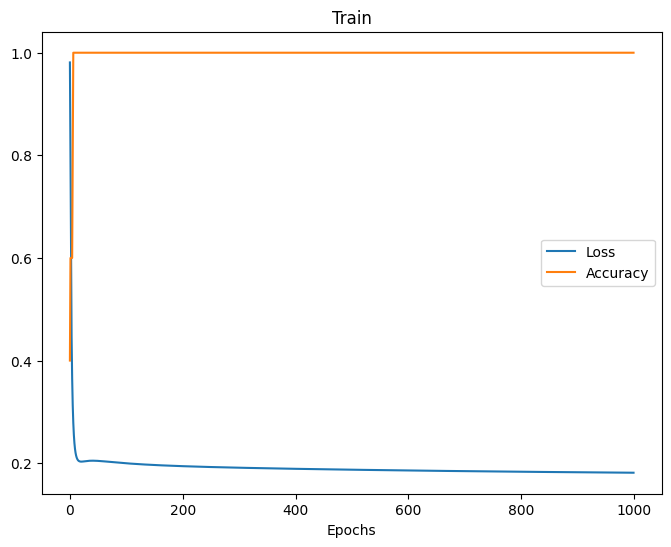

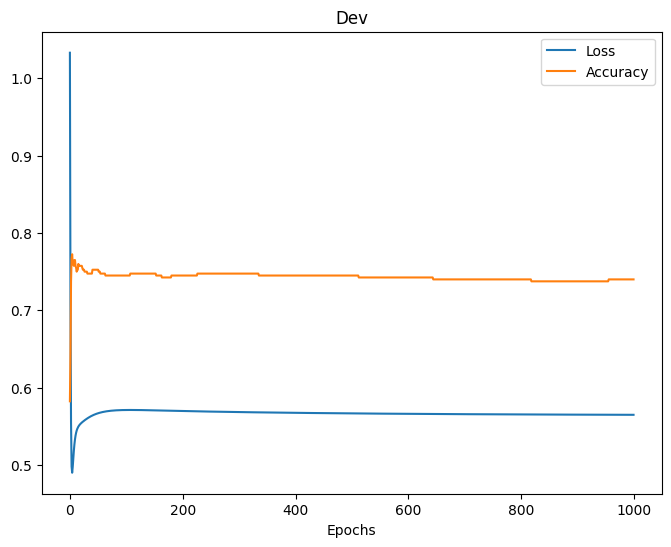


Training Model by learning rate: 0.01
Epoch 10/1000, Loss: 0.6296, Accuracy: 0.6000, Dev Loss: 0.6470, Dev Accuracy: 0.6300
Epoch 20/1000, Loss: 0.5937, Accuracy: 0.6000, Dev Loss: 0.6214, Dev Accuracy: 0.7150
Epoch 30/1000, Loss: 0.5667, Accuracy: 0.6000, Dev Loss: 0.6019, Dev Accuracy: 0.7475
Epoch 40/1000, Loss: 0.5457, Accuracy: 0.6000, Dev Loss: 0.5866, Dev Accuracy: 0.7650
Epoch 50/1000, Loss: 0.5288, Accuracy: 0.6000, Dev Loss: 0.5743, Dev Accuracy: 0.7600
Epoch 60/1000, Loss: 0.5149, Accuracy: 0.6000, Dev Loss: 0.5643, Dev Accuracy: 0.7675
Epoch 70/1000, Loss: 0.5031, Accuracy: 0.6000, Dev Loss: 0.5559, Dev Accuracy: 0.7675
Epoch 80/1000, Loss: 0.4930, Accuracy: 0.6000, Dev Loss: 0.5489, Dev Accuracy: 0.7725
Epoch 90/1000, Loss: 0.4840, Accuracy: 0.6000, Dev Loss: 0.5428, Dev Accuracy: 0.7700
Epoch 100/1000, Loss: 0.4761, Accuracy: 0.6000, Dev Loss: 0.5376, Dev Accuracy: 0.7700
Epoch 110/1000, Loss: 0.4689, Accuracy: 0.6000, Dev Loss: 0.5330, Dev Accuracy: 0.7700
Epoch 120/100

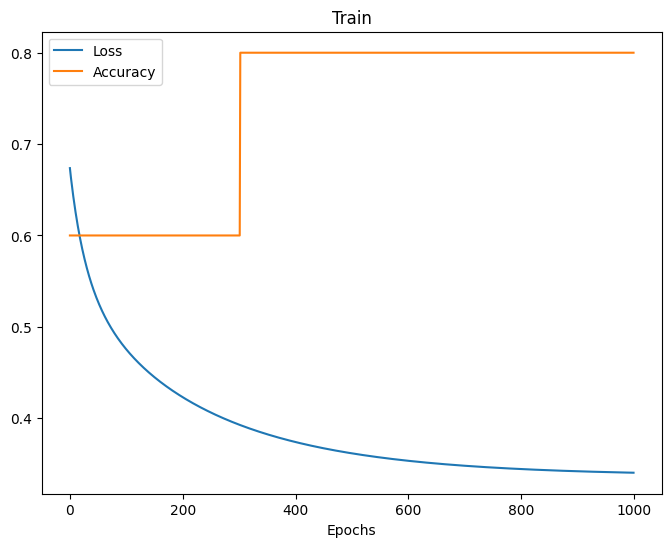

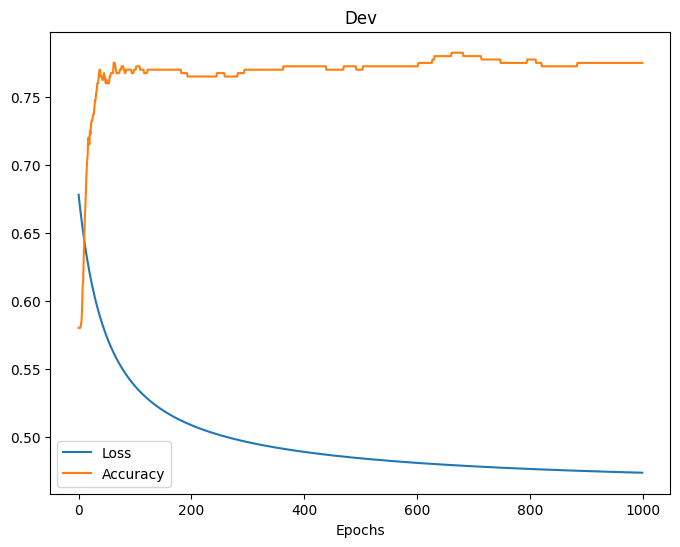


Training Model by learning rate: 0.001
Epoch 10/1000, Loss: 0.6726, Accuracy: 0.6000, Dev Loss: 0.6777, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6667, Accuracy: 0.6000, Dev Loss: 0.6736, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6614, Accuracy: 0.6000, Dev Loss: 0.6698, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6563, Accuracy: 0.6000, Dev Loss: 0.6662, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6513, Accuracy: 0.6000, Dev Loss: 0.6626, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6466, Accuracy: 0.6000, Dev Loss: 0.6592, Dev Accuracy: 0.5850
Epoch 70/1000, Loss: 0.6419, Accuracy: 0.6000, Dev Loss: 0.6559, Dev Accuracy: 0.5925
Epoch 80/1000, Loss: 0.6375, Accuracy: 0.6000, Dev Loss: 0.6527, Dev Accuracy: 0.6000
Epoch 90/1000, Loss: 0.6331, Accuracy: 0.6000, Dev Loss: 0.6496, Dev Accuracy: 0.6125
Epoch 100/1000, Loss: 0.6289, Accuracy: 0.6000, Dev Loss: 0.6466, Dev Accuracy: 0.6175
Epoch 110/1000, Loss: 0.6249, Accuracy: 0.6000, Dev Loss: 0.6437, Dev Accuracy: 0.6300
Epoch 120/10

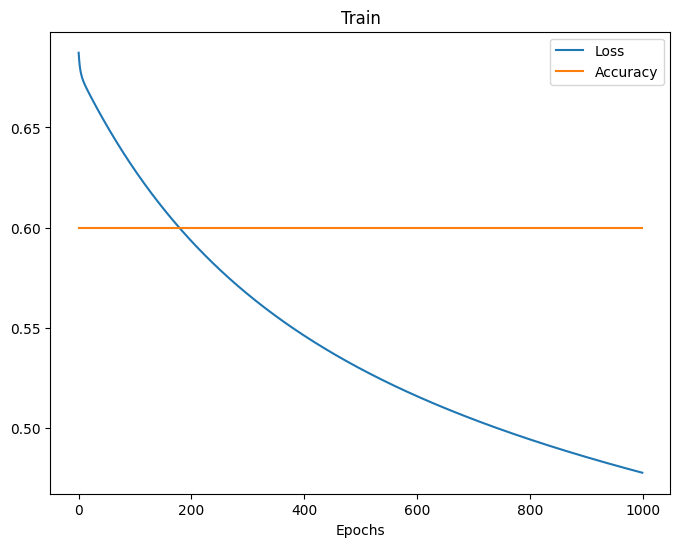

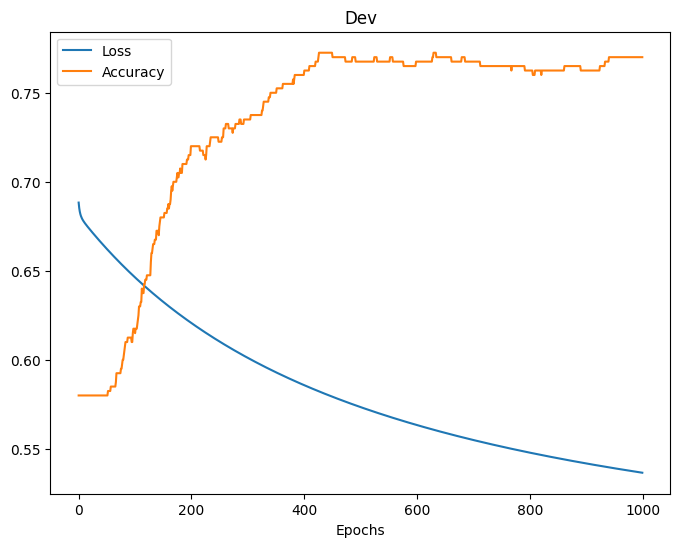


Training Model by learning rate: 0.0001
Epoch 10/1000, Loss: 0.6872, Accuracy: 0.6000, Dev Loss: 0.6883, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6832, Accuracy: 0.6000, Dev Loss: 0.6853, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6805, Accuracy: 0.6000, Dev Loss: 0.6833, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6786, Accuracy: 0.6000, Dev Loss: 0.6819, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6771, Accuracy: 0.6000, Dev Loss: 0.6808, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6759, Accuracy: 0.6000, Dev Loss: 0.6800, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6749, Accuracy: 0.6000, Dev Loss: 0.6793, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6740, Accuracy: 0.6000, Dev Loss: 0.6787, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6732, Accuracy: 0.6000, Dev Loss: 0.6782, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6725, Accuracy: 0.6000, Dev Loss: 0.6777, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6719, Accuracy: 0.6000, Dev Loss: 0.6772, Dev Accuracy: 0.5800
Epoch 120/1

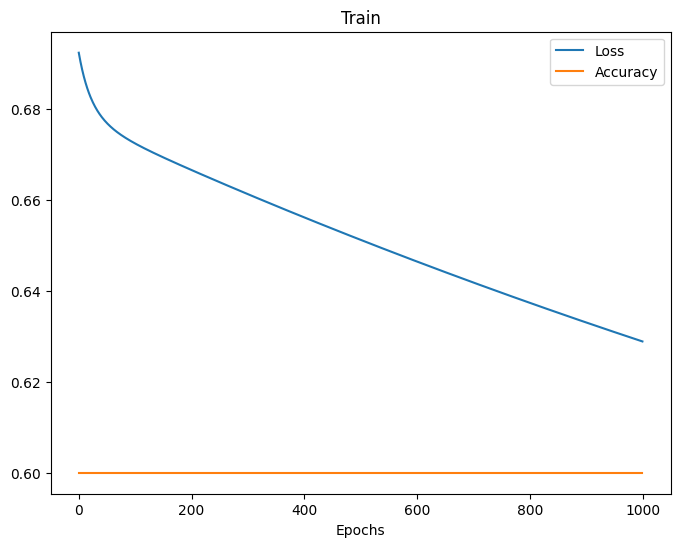

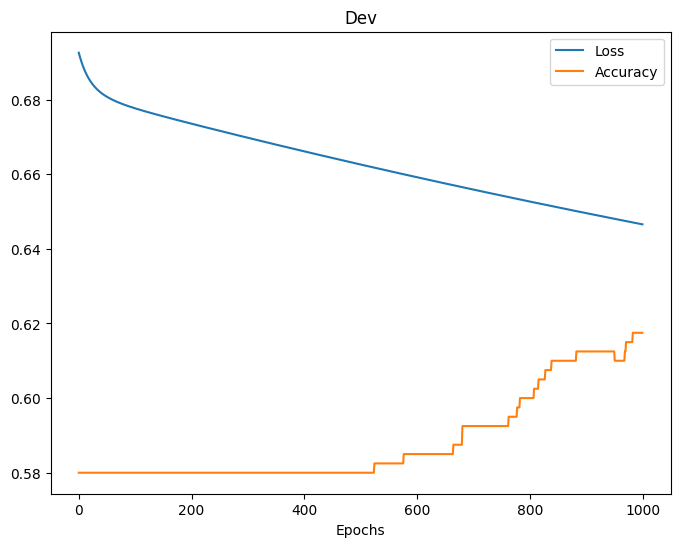


Training Model by learning rate: 1e-05
Epoch 10/1000, Loss: 0.6924, Accuracy: 0.6000, Dev Loss: 0.6926, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6917, Accuracy: 0.6000, Dev Loss: 0.6920, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6911, Accuracy: 0.6000, Dev Loss: 0.6914, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6904, Accuracy: 0.6000, Dev Loss: 0.6909, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6898, Accuracy: 0.6000, Dev Loss: 0.6904, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6893, Accuracy: 0.6000, Dev Loss: 0.6900, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6887, Accuracy: 0.6000, Dev Loss: 0.6895, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6882, Accuracy: 0.6000, Dev Loss: 0.6891, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6877, Accuracy: 0.6000, Dev Loss: 0.6887, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6872, Accuracy: 0.6000, Dev Loss: 0.6883, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6867, Accuracy: 0.6000, Dev Loss: 0.6880, Dev Accuracy: 0.5800
Epoch 120/10

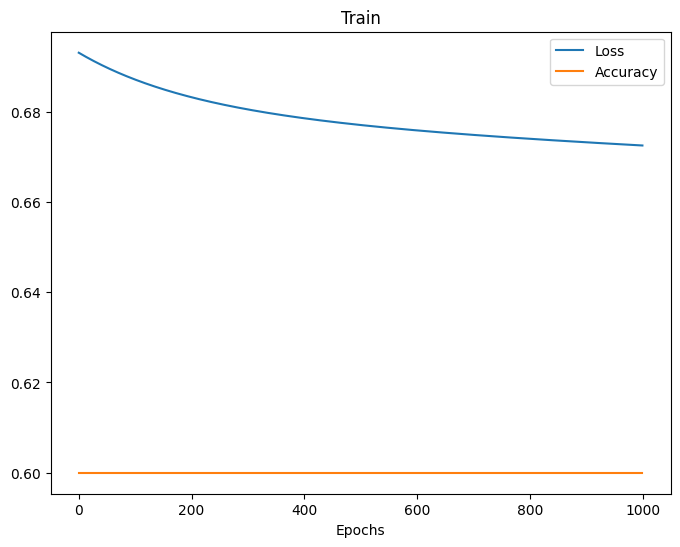

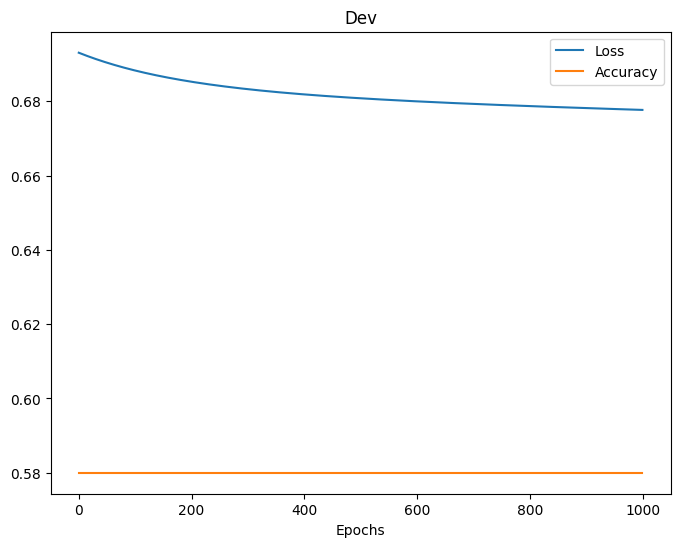

In [ ]:
learning_rates = [1, 0.01, 0.001, 0.0001, 0.00001]
bests, train_accuracies, train_losses , dev_accuracies, dev_losses = [], [], [], [], []

# train model by learning rates
for lr in learning_rates:
  print(f"\nTraining Model by learning rate: {lr}")
  best = logistic_regression_classifier(train, dev, batch_size = 16, epochs = 1000, learning_rate = lr)

  bests.append(best)
  train_accuracies.append(best["Train Acc"])
  train_losses.append(best["Train Loss"])
  dev_accuracies.append(best["Dev Acc"])
  dev_losses.append(best["Dev Loss"])

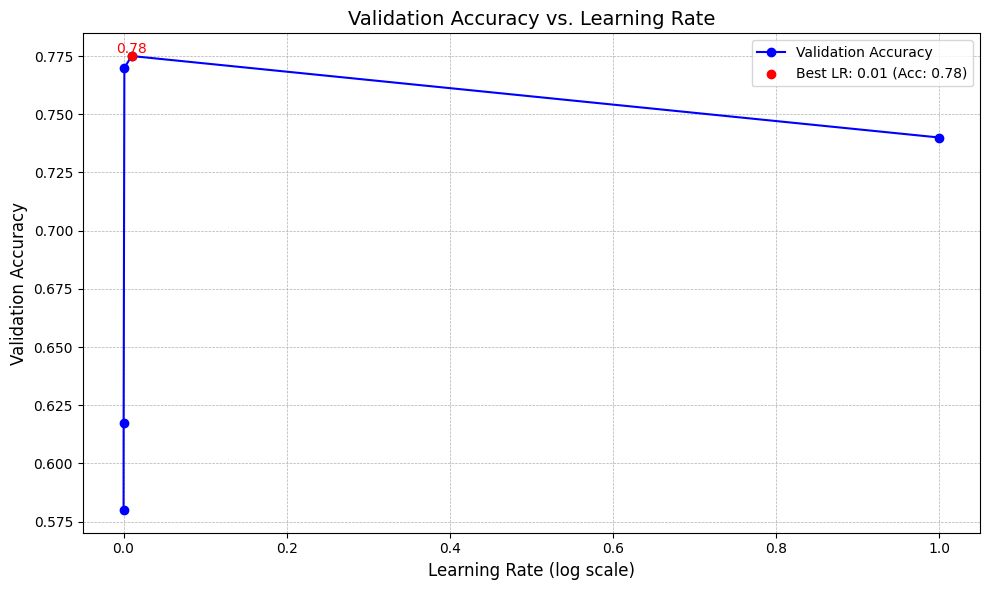

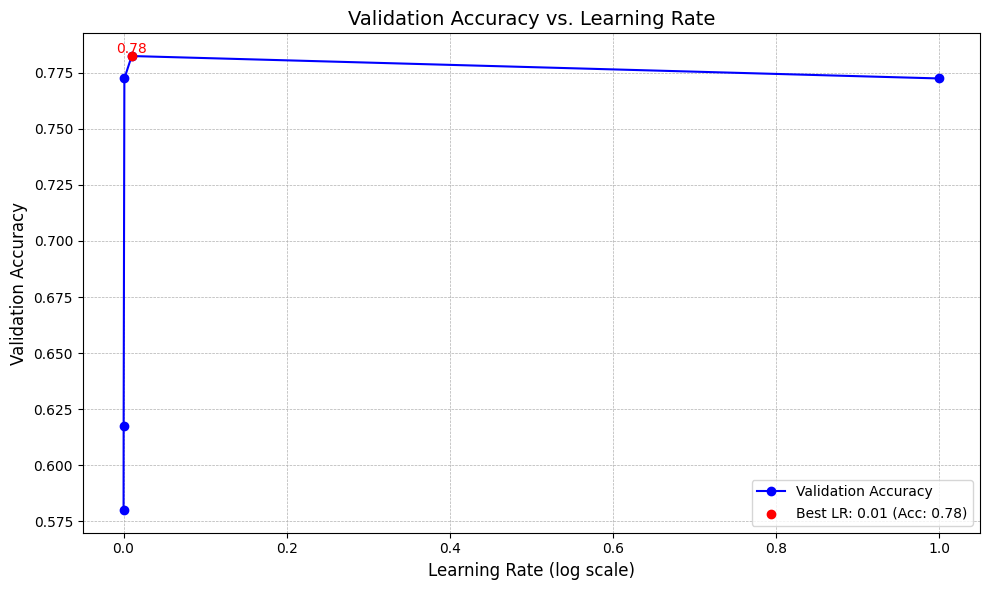

In [ ]:
def best_lr_by_dev_acc(learning_rates, dev_accuracies):
  plt.figure(figsize=(10, 6))
  plt.plot(learning_rates, dev_accuracies, marker="o", color="blue", label="Validation Accuracy")

  best_index = np.argmax(dev_accuracies)
  best_lr = learning_rates[best_index]
  best_acc = dev_accuracies[best_index]

  plt.scatter(best_lr, best_acc, color="red", zorder=5, label=f"Best LR: {best_lr} (Acc: {best_acc:.2f})")
  plt.text(best_lr, best_acc, f"{best_acc:.2f}", ha="center", va="bottom", color="red", fontsize=10)
  plt.xlabel("Learning Rate (log scale)", fontsize=12)
  plt.ylabel("Validation Accuracy", fontsize=12)
  plt.title("Validation Accuracy vs. Learning Rate", fontsize=14)
  plt.grid(True, which="both", linestyle="--", linewidth=0.5)
  plt.legend()
  plt.tight_layout()
  plt.show()

  return best_lr

results_Q4 = {
    "Learning Rate": learning_rates,
    "Dev Acc": [dev_accuracies[i][-1] for i in range(len(learning_rates))],
    "Best Dev Acc": [bests[i]["best_dev_acc"] for i in range(len(learning_rates))]
}

# plotting and get best lr by dev acc
best_learning_rate = best_lr_by_dev_acc(results_Q4["Learning Rate"], results_Q4["Dev Acc"])
best_learning_rate = best_lr_by_dev_acc(results_Q4["Learning Rate"], results_Q4["Best Dev Acc"])


## Testing Acc

In [ ]:
# preparing best model
# best_learning_rate = 0.01 from last Q5 section
best_model = next((entry for entry in bests if entry["best_lr"] == best_learning_rate), None)
best_w = best_model["best_weights"]
best_b = best_model["best_bias"]


# preparing datasets
y_test = get_binary_label(test["sentiment"])
test_embeddings, train_embeddings = [ get_dataset_embeddings(dataset["review"]) for dataset in [test, train]]
test_norm_embeddings = normalize(test_embeddings, train_embeddings)


test_model(test_norm_embeddings, y_test, best_w, best_b)


Test Accuracy: 79.00%


0.79

##  Experiment with different batch sizes (4, 8, 16, 32, 64)


Training Model by batch size: 4
Epoch 10/1000, Loss: 0.7088, Accuracy: 0.0000, Dev Loss: 0.5944, Dev Accuracy: 0.7225
Epoch 20/1000, Loss: 0.7208, Accuracy: 0.0000, Dev Loss: 0.5570, Dev Accuracy: 0.7400
Epoch 30/1000, Loss: 0.7405, Accuracy: 0.0000, Dev Loss: 0.5372, Dev Accuracy: 0.7475
Epoch 40/1000, Loss: 0.7576, Accuracy: 0.0000, Dev Loss: 0.5249, Dev Accuracy: 0.7525
Epoch 50/1000, Loss: 0.7714, Accuracy: 0.0000, Dev Loss: 0.5165, Dev Accuracy: 0.7600
Epoch 60/1000, Loss: 0.7826, Accuracy: 0.0000, Dev Loss: 0.5103, Dev Accuracy: 0.7650
Epoch 70/1000, Loss: 0.7919, Accuracy: 0.0000, Dev Loss: 0.5056, Dev Accuracy: 0.7675
Epoch 80/1000, Loss: 0.7998, Accuracy: 0.0000, Dev Loss: 0.5018, Dev Accuracy: 0.7725
Epoch 90/1000, Loss: 0.8065, Accuracy: 0.0000, Dev Loss: 0.4988, Dev Accuracy: 0.7700
Epoch 100/1000, Loss: 0.8124, Accuracy: 0.0000, Dev Loss: 0.4962, Dev Accuracy: 0.7700
Epoch 110/1000, Loss: 0.8176, Accuracy: 0.0000, Dev Loss: 0.4940, Dev Accuracy: 0.7750
Epoch 120/1000, Los

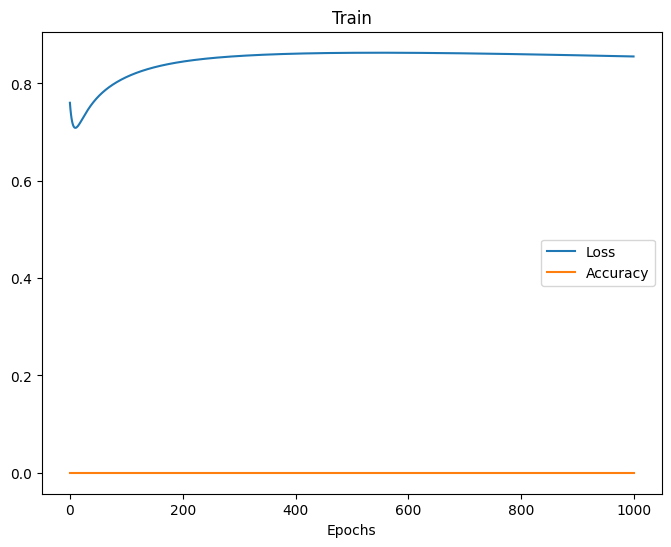

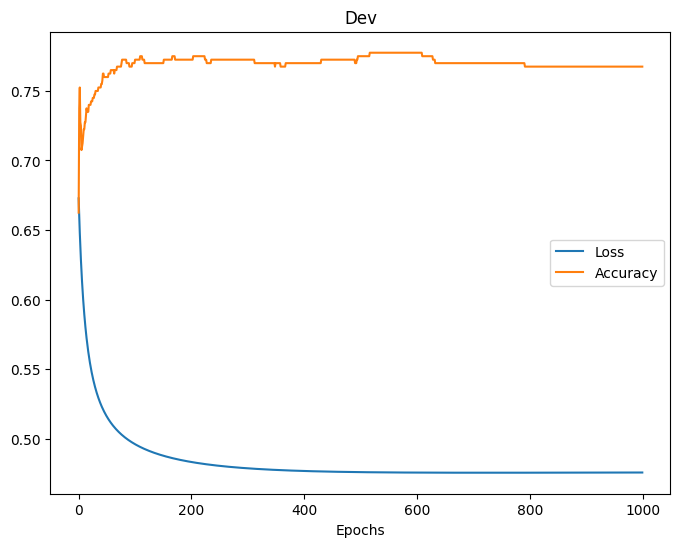


Training Model by batch size: 8
Epoch 10/1000, Loss: 0.5974, Accuracy: 0.6000, Dev Loss: 0.6229, Dev Accuracy: 0.7325
Epoch 20/1000, Loss: 0.5506, Accuracy: 0.6000, Dev Loss: 0.5884, Dev Accuracy: 0.7600
Epoch 30/1000, Loss: 0.5209, Accuracy: 0.6000, Dev Loss: 0.5662, Dev Accuracy: 0.7550
Epoch 40/1000, Loss: 0.5002, Accuracy: 0.6000, Dev Loss: 0.5508, Dev Accuracy: 0.7575
Epoch 50/1000, Loss: 0.4846, Accuracy: 0.6000, Dev Loss: 0.5396, Dev Accuracy: 0.7575
Epoch 60/1000, Loss: 0.4720, Accuracy: 0.6000, Dev Loss: 0.5310, Dev Accuracy: 0.7600
Epoch 70/1000, Loss: 0.4616, Accuracy: 0.6000, Dev Loss: 0.5243, Dev Accuracy: 0.7625
Epoch 80/1000, Loss: 0.4526, Accuracy: 0.6000, Dev Loss: 0.5188, Dev Accuracy: 0.7625
Epoch 90/1000, Loss: 0.4446, Accuracy: 0.6000, Dev Loss: 0.5143, Dev Accuracy: 0.7625
Epoch 100/1000, Loss: 0.4376, Accuracy: 0.6000, Dev Loss: 0.5105, Dev Accuracy: 0.7650
Epoch 110/1000, Loss: 0.4312, Accuracy: 0.6000, Dev Loss: 0.5073, Dev Accuracy: 0.7675
Epoch 120/1000, Los

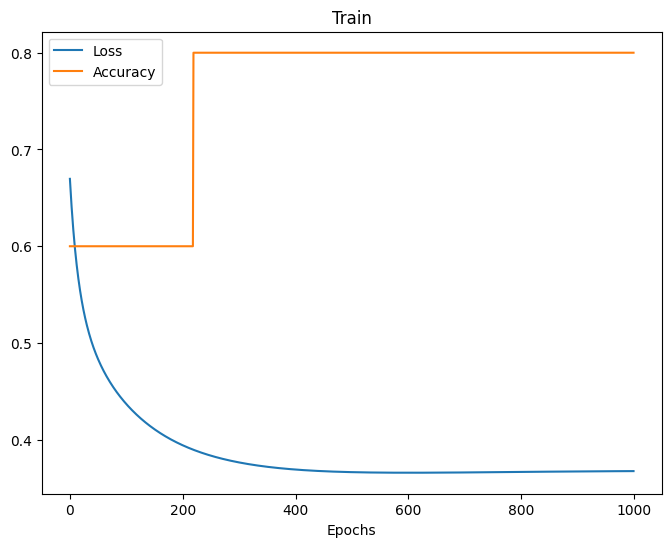

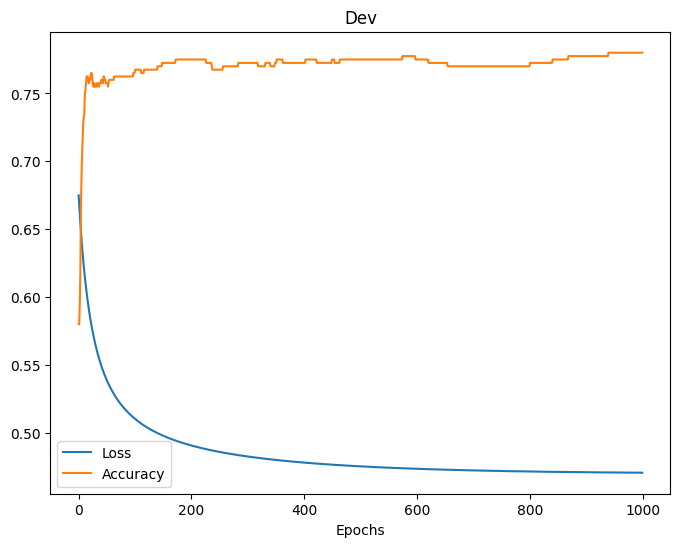


Training Model by batch size: 16
Epoch 10/1000, Loss: 0.6296, Accuracy: 0.6000, Dev Loss: 0.6470, Dev Accuracy: 0.6300
Epoch 20/1000, Loss: 0.5937, Accuracy: 0.6000, Dev Loss: 0.6214, Dev Accuracy: 0.7150
Epoch 30/1000, Loss: 0.5667, Accuracy: 0.6000, Dev Loss: 0.6019, Dev Accuracy: 0.7475
Epoch 40/1000, Loss: 0.5457, Accuracy: 0.6000, Dev Loss: 0.5866, Dev Accuracy: 0.7650
Epoch 50/1000, Loss: 0.5288, Accuracy: 0.6000, Dev Loss: 0.5743, Dev Accuracy: 0.7600
Epoch 60/1000, Loss: 0.5149, Accuracy: 0.6000, Dev Loss: 0.5643, Dev Accuracy: 0.7675
Epoch 70/1000, Loss: 0.5031, Accuracy: 0.6000, Dev Loss: 0.5559, Dev Accuracy: 0.7675
Epoch 80/1000, Loss: 0.4930, Accuracy: 0.6000, Dev Loss: 0.5489, Dev Accuracy: 0.7725
Epoch 90/1000, Loss: 0.4840, Accuracy: 0.6000, Dev Loss: 0.5428, Dev Accuracy: 0.7700
Epoch 100/1000, Loss: 0.4761, Accuracy: 0.6000, Dev Loss: 0.5376, Dev Accuracy: 0.7700
Epoch 110/1000, Loss: 0.4689, Accuracy: 0.6000, Dev Loss: 0.5330, Dev Accuracy: 0.7700
Epoch 120/1000, Lo

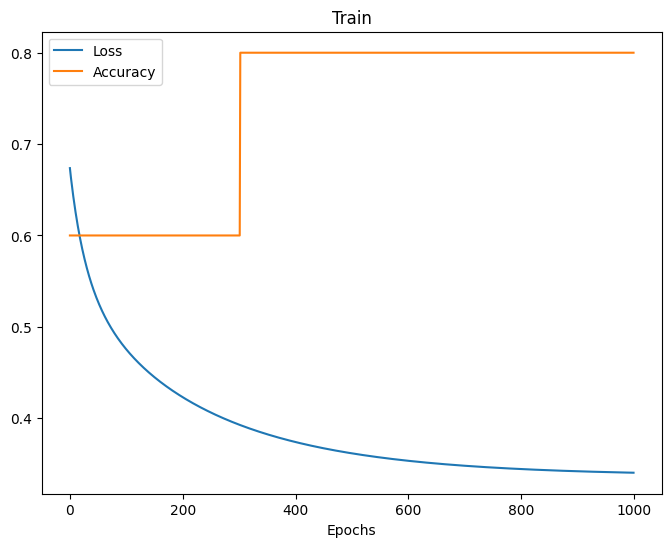

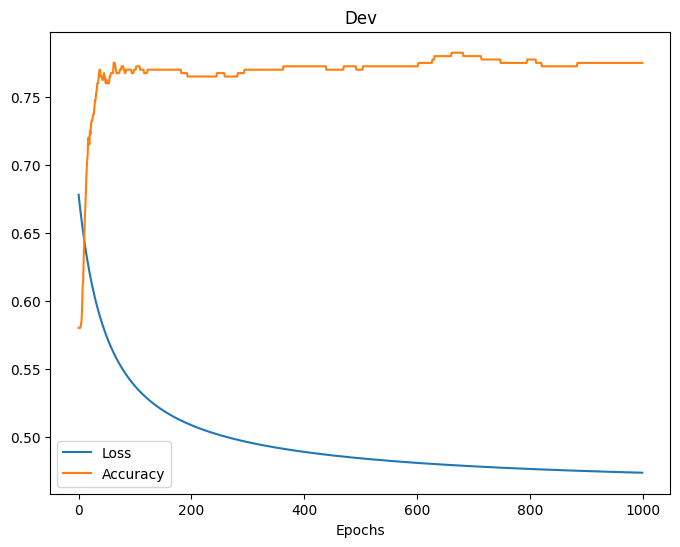


Training Model by batch size: 32
Epoch 10/1000, Loss: 0.6497, Accuracy: 0.6000, Dev Loss: 0.6624, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6254, Accuracy: 0.6000, Dev Loss: 0.6462, Dev Accuracy: 0.6175
Epoch 30/1000, Loss: 0.6047, Accuracy: 0.6000, Dev Loss: 0.6323, Dev Accuracy: 0.6875
Epoch 40/1000, Loss: 0.5868, Accuracy: 0.6000, Dev Loss: 0.6203, Dev Accuracy: 0.7175
Epoch 50/1000, Loss: 0.5712, Accuracy: 0.6000, Dev Loss: 0.6099, Dev Accuracy: 0.7325
Epoch 60/1000, Loss: 0.5575, Accuracy: 0.6000, Dev Loss: 0.6007, Dev Accuracy: 0.7350
Epoch 70/1000, Loss: 0.5454, Accuracy: 0.6000, Dev Loss: 0.5925, Dev Accuracy: 0.7625
Epoch 80/1000, Loss: 0.5346, Accuracy: 0.6000, Dev Loss: 0.5853, Dev Accuracy: 0.7675
Epoch 90/1000, Loss: 0.5248, Accuracy: 0.6000, Dev Loss: 0.5788, Dev Accuracy: 0.7625
Epoch 100/1000, Loss: 0.5159, Accuracy: 0.6000, Dev Loss: 0.5730, Dev Accuracy: 0.7675
Epoch 110/1000, Loss: 0.5078, Accuracy: 0.6000, Dev Loss: 0.5677, Dev Accuracy: 0.7625
Epoch 120/1000, Lo

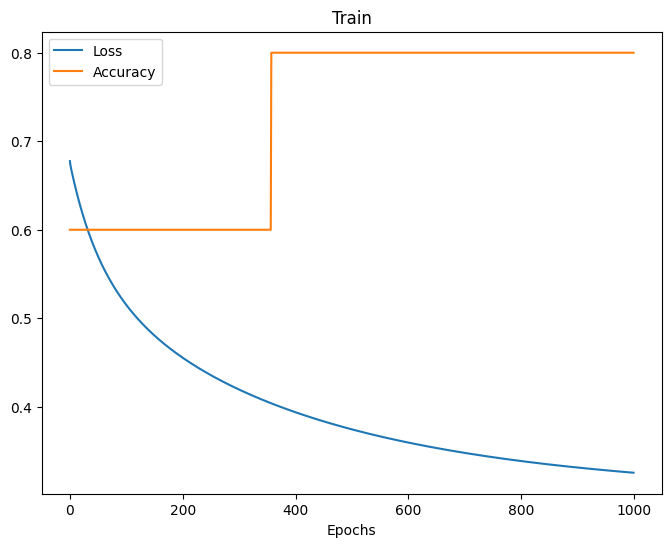

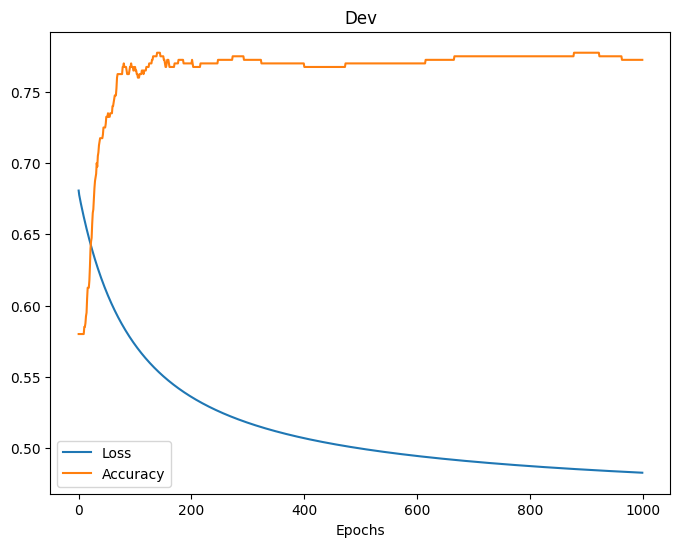


Training Model by batch size: 64
Epoch 10/1000, Loss: 0.6611, Accuracy: 0.6000, Dev Loss: 0.6711, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6453, Accuracy: 0.6000, Dev Loss: 0.6617, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6308, Accuracy: 0.6000, Dev Loss: 0.6531, Dev Accuracy: 0.5975
Epoch 40/1000, Loss: 0.6175, Accuracy: 0.6000, Dev Loss: 0.6452, Dev Accuracy: 0.6275
Epoch 50/1000, Loss: 0.6052, Accuracy: 0.6000, Dev Loss: 0.6378, Dev Accuracy: 0.6600
Epoch 60/1000, Loss: 0.5938, Accuracy: 0.6000, Dev Loss: 0.6311, Dev Accuracy: 0.6875
Epoch 70/1000, Loss: 0.5832, Accuracy: 0.6000, Dev Loss: 0.6248, Dev Accuracy: 0.7050
Epoch 80/1000, Loss: 0.5733, Accuracy: 0.6000, Dev Loss: 0.6189, Dev Accuracy: 0.7100
Epoch 90/1000, Loss: 0.5641, Accuracy: 0.6000, Dev Loss: 0.6134, Dev Accuracy: 0.7250
Epoch 100/1000, Loss: 0.5554, Accuracy: 0.6000, Dev Loss: 0.6083, Dev Accuracy: 0.7250
Epoch 110/1000, Loss: 0.5473, Accuracy: 0.6000, Dev Loss: 0.6035, Dev Accuracy: 0.7325
Epoch 120/1000, Lo

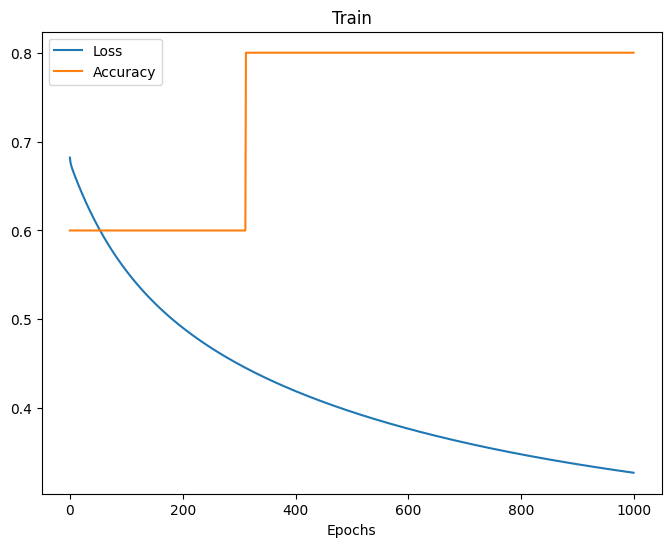

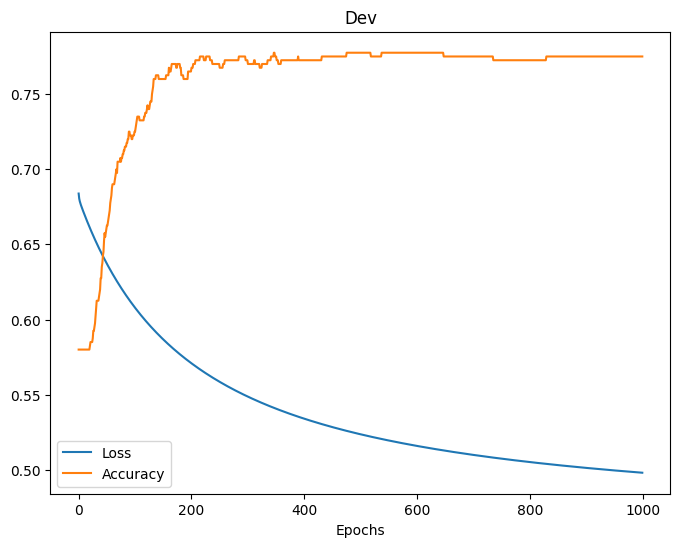

In [ ]:
batch_sizes = [4, 8, 16, 32, 64]
bests, train_accuracies, train_losses , dev_accuracies, dev_losses = [], [], [], [], []

# train model by batch size
for s in batch_sizes:
  print(f"\nTraining Model by batch size: {s}")
  best = logistic_regression_classifier(train, dev, batch_size = s, epochs = 1000, learning_rate = 0.01)

  bests.append(best)
  train_accuracies.append(best["Train Acc"])
  train_losses.append(best["Train Loss"])
  dev_accuracies.append(best["Dev Acc"])
  dev_losses.append(best["Dev Loss"])


In [ ]:
# best dev acc
[bests[i]["best_dev_acc"] for i in range(len(batch_sizes))]

[0.7775, 0.78, 0.7825, 0.7775, 0.7775]

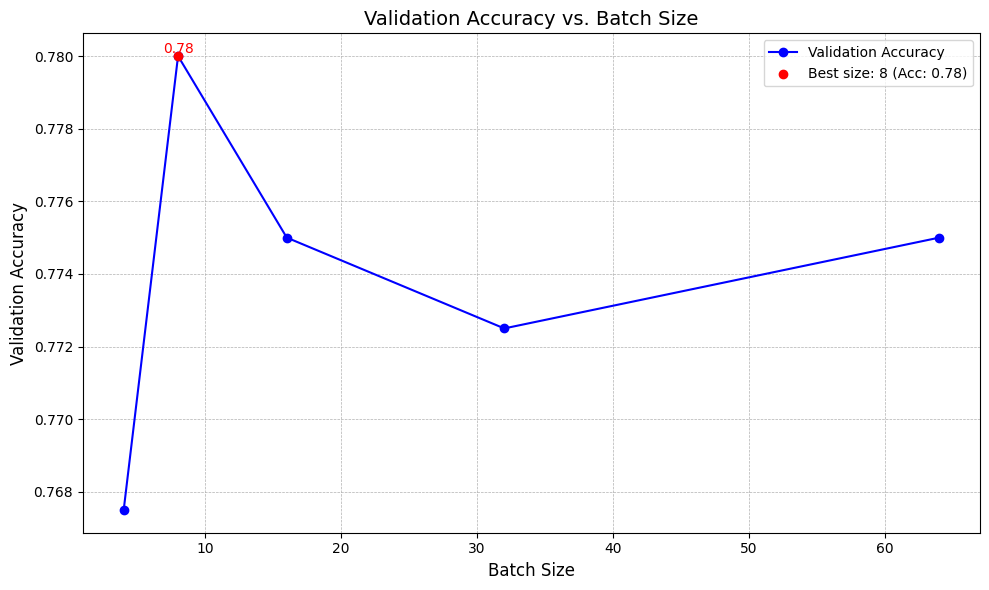

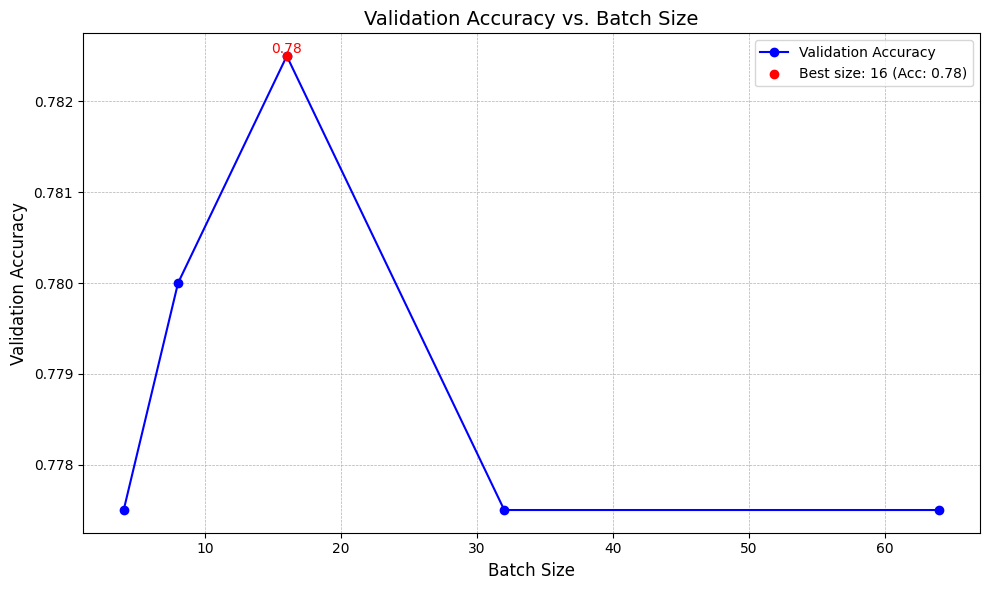

In [ ]:
def best_batch_size_by_dev_acc(batch_sizes, dev_accuracies):
  plt.figure(figsize=(10, 6))
  plt.plot(batch_sizes, dev_accuracies, marker="o", color="blue", label="Validation Accuracy")

  best_index = np.argmax(dev_accuracies)
  best_batch_size = batch_sizes[best_index]
  best_acc = dev_accuracies[best_index]

  plt.scatter(best_batch_size, best_acc, color="red", zorder=5, label=f"Best size: {best_batch_size} (Acc: {best_acc:.2f})")
  plt.text(best_batch_size, best_acc, f"{best_acc:.2f}", ha="center", va="bottom", color="red", fontsize=10)
  plt.xlabel("Batch Size", fontsize=12)
  plt.ylabel("Validation Accuracy", fontsize=12)
  plt.title("Validation Accuracy vs. Batch Size", fontsize=14)
  plt.grid(True, which="both", linestyle="--", linewidth=0.5)
  plt.legend()
  plt.tight_layout()
  plt.show()

  return best_batch_size

results_Q6 = {
    "Batch Size": batch_sizes,
    "Dev Acc": [dev_accuracies[i][-1] for i in range(len(batch_sizes))],
    "Best Dev Acc": [bests[i]["best_dev_acc"] for i in range(len(batch_sizes))]
}

# plotting and get best batch size by dev acc
best_batch_size = best_batch_size_by_dev_acc(results_Q6["Batch Size"], results_Q6["Dev Acc"])
best_batch_size = best_batch_size_by_dev_acc(results_Q6["Batch Size"], results_Q6["Best Dev Acc"])

## Experiment with  L2 regularization.


Training Model by lambda: 1e-05
Epoch 10/1000, Loss: 0.6759, Accuracy: 0.6000, Dev Loss: 0.6807, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6748, Accuracy: 0.6000, Dev Loss: 0.6801, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6743, Accuracy: 0.6000, Dev Loss: 0.6798, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6740, Accuracy: 0.6000, Dev Loss: 0.6797, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6739, Accuracy: 0.6000, Dev Loss: 0.6796, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6738, Accuracy: 0.6000, Dev Loss: 0.6796, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6738, Accuracy: 0.6000, Dev Loss: 0.6795, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6737, Accuracy: 0.6000, Dev Loss: 0.6795, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6737, Accuracy: 0.6000, Dev Loss: 0.6795, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6737, Accuracy: 0.6000, Dev Loss: 0.6795, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6737, Accuracy: 0.6000, Dev Loss: 0.6795, Dev Accuracy: 0.5800
Epoch 120/1000, Los

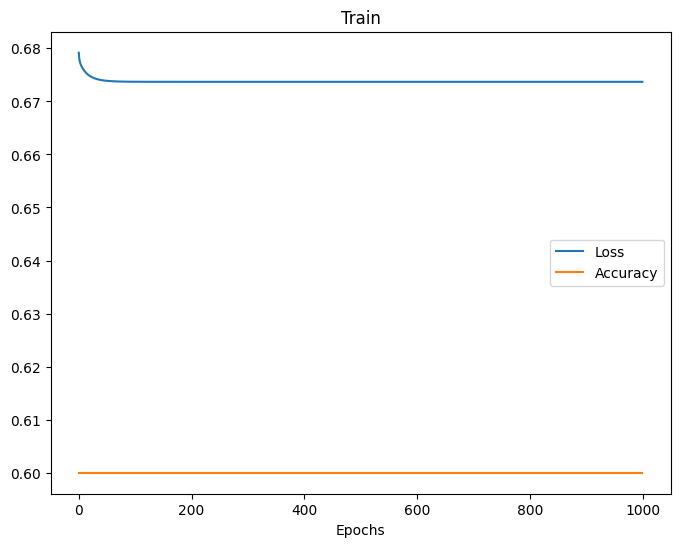

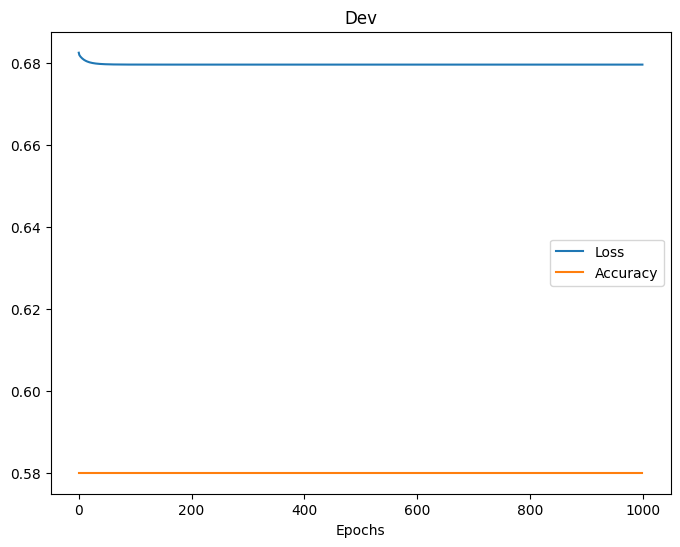


Training Model by lambda: 1e-05
Epoch 10/1000, Loss: 0.6525, Accuracy: 0.6000, Dev Loss: 0.6653, Dev Accuracy: 0.5925
Epoch 20/1000, Loss: 0.6476, Accuracy: 0.6000, Dev Loss: 0.6634, Dev Accuracy: 0.6175
Epoch 30/1000, Loss: 0.6465, Accuracy: 0.6000, Dev Loss: 0.6631, Dev Accuracy: 0.6225
Epoch 40/1000, Loss: 0.6461, Accuracy: 0.6000, Dev Loss: 0.6631, Dev Accuracy: 0.6300
Epoch 50/1000, Loss: 0.6460, Accuracy: 0.6000, Dev Loss: 0.6631, Dev Accuracy: 0.6300
Epoch 60/1000, Loss: 0.6459, Accuracy: 0.6000, Dev Loss: 0.6631, Dev Accuracy: 0.6300
Epoch 70/1000, Loss: 0.6459, Accuracy: 0.6000, Dev Loss: 0.6630, Dev Accuracy: 0.6300
Epoch 80/1000, Loss: 0.6458, Accuracy: 0.6000, Dev Loss: 0.6630, Dev Accuracy: 0.6300
Epoch 90/1000, Loss: 0.6458, Accuracy: 0.6000, Dev Loss: 0.6630, Dev Accuracy: 0.6325
Epoch 100/1000, Loss: 0.6458, Accuracy: 0.6000, Dev Loss: 0.6630, Dev Accuracy: 0.6325
Epoch 110/1000, Loss: 0.6457, Accuracy: 0.6000, Dev Loss: 0.6630, Dev Accuracy: 0.6325
Epoch 120/1000, Los

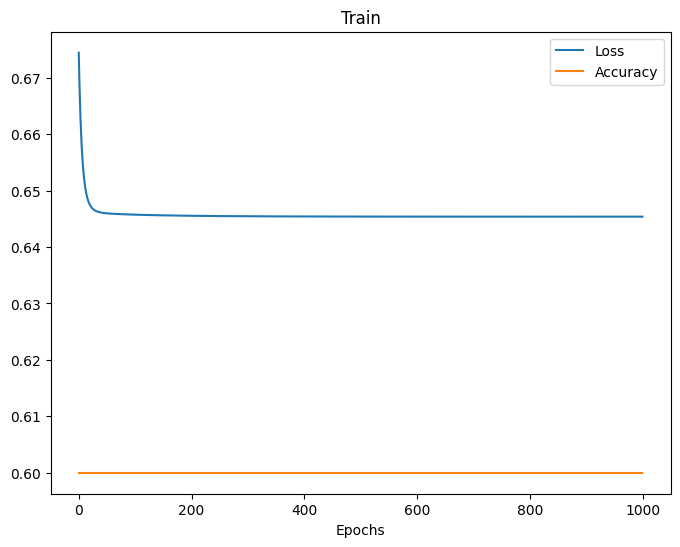

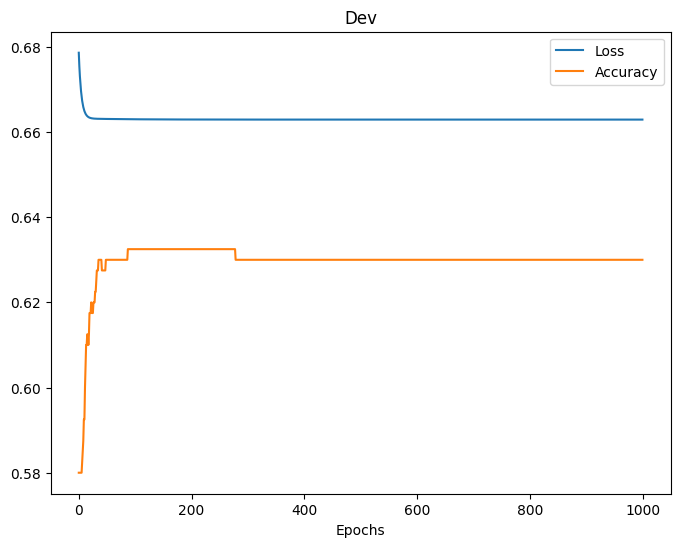


Training Model by lambda: 1e-05
Epoch 10/1000, Loss: 0.6331, Accuracy: 0.6000, Dev Loss: 0.6499, Dev Accuracy: 0.6175
Epoch 20/1000, Loss: 0.6045, Accuracy: 0.6000, Dev Loss: 0.6304, Dev Accuracy: 0.7225
Epoch 30/1000, Loss: 0.5862, Accuracy: 0.6000, Dev Loss: 0.6181, Dev Accuracy: 0.7325
Epoch 40/1000, Loss: 0.5740, Accuracy: 0.6000, Dev Loss: 0.6102, Dev Accuracy: 0.7575
Epoch 50/1000, Loss: 0.5656, Accuracy: 0.6000, Dev Loss: 0.6050, Dev Accuracy: 0.7725
Epoch 60/1000, Loss: 0.5597, Accuracy: 0.6000, Dev Loss: 0.6016, Dev Accuracy: 0.7725
Epoch 70/1000, Loss: 0.5553, Accuracy: 0.6000, Dev Loss: 0.5993, Dev Accuracy: 0.7675
Epoch 80/1000, Loss: 0.5521, Accuracy: 0.6000, Dev Loss: 0.5978, Dev Accuracy: 0.7700
Epoch 90/1000, Loss: 0.5496, Accuracy: 0.6000, Dev Loss: 0.5968, Dev Accuracy: 0.7725
Epoch 100/1000, Loss: 0.5476, Accuracy: 0.6000, Dev Loss: 0.5961, Dev Accuracy: 0.7675
Epoch 110/1000, Loss: 0.5459, Accuracy: 0.6000, Dev Loss: 0.5956, Dev Accuracy: 0.7625
Epoch 120/1000, Los

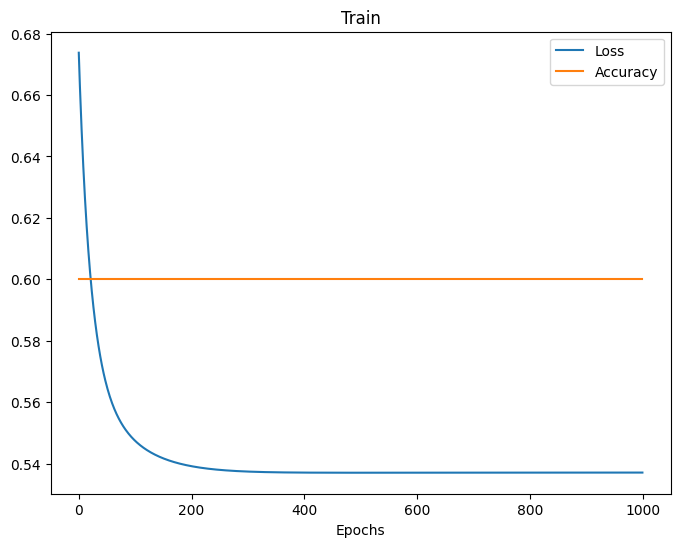

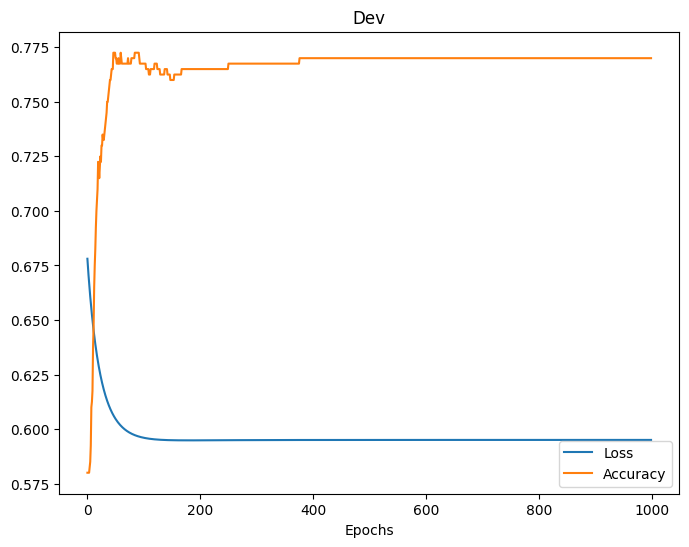


Training Model by lambda: 1e-05
Epoch 10/1000, Loss: 0.6300, Accuracy: 0.6000, Dev Loss: 0.6473, Dev Accuracy: 0.6300
Epoch 20/1000, Loss: 0.5949, Accuracy: 0.6000, Dev Loss: 0.6224, Dev Accuracy: 0.7150
Epoch 30/1000, Loss: 0.5690, Accuracy: 0.6000, Dev Loss: 0.6038, Dev Accuracy: 0.7475
Epoch 40/1000, Loss: 0.5491, Accuracy: 0.6000, Dev Loss: 0.5895, Dev Accuracy: 0.7700
Epoch 50/1000, Loss: 0.5334, Accuracy: 0.6000, Dev Loss: 0.5782, Dev Accuracy: 0.7625
Epoch 60/1000, Loss: 0.5206, Accuracy: 0.6000, Dev Loss: 0.5692, Dev Accuracy: 0.7675
Epoch 70/1000, Loss: 0.5100, Accuracy: 0.6000, Dev Loss: 0.5618, Dev Accuracy: 0.7675
Epoch 80/1000, Loss: 0.5010, Accuracy: 0.6000, Dev Loss: 0.5558, Dev Accuracy: 0.7700
Epoch 90/1000, Loss: 0.4932, Accuracy: 0.6000, Dev Loss: 0.5507, Dev Accuracy: 0.7700
Epoch 100/1000, Loss: 0.4864, Accuracy: 0.6000, Dev Loss: 0.5464, Dev Accuracy: 0.7675
Epoch 110/1000, Loss: 0.4803, Accuracy: 0.6000, Dev Loss: 0.5427, Dev Accuracy: 0.7725
Epoch 120/1000, Los

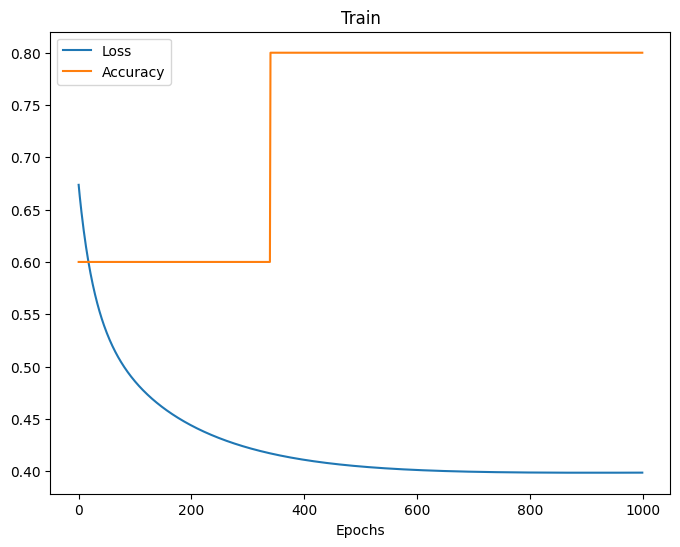

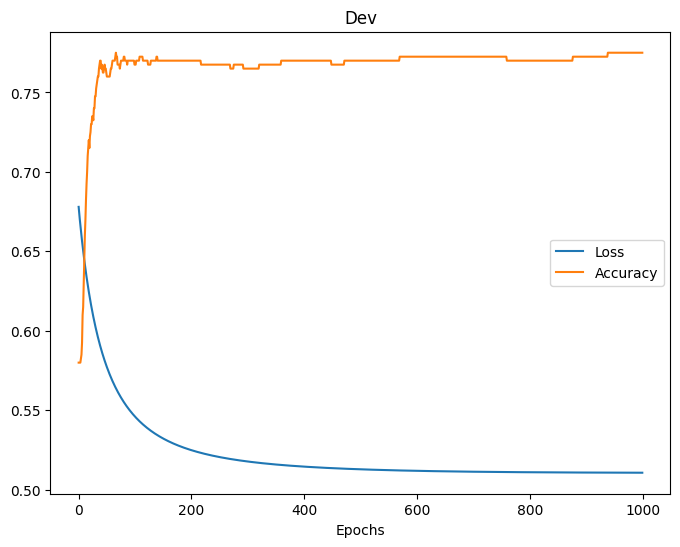


Training Model by lambda: 1e-05
Epoch 10/1000, Loss: 0.6296, Accuracy: 0.6000, Dev Loss: 0.6470, Dev Accuracy: 0.6300
Epoch 20/1000, Loss: 0.5938, Accuracy: 0.6000, Dev Loss: 0.6214, Dev Accuracy: 0.7150
Epoch 30/1000, Loss: 0.5668, Accuracy: 0.6000, Dev Loss: 0.6019, Dev Accuracy: 0.7475
Epoch 40/1000, Loss: 0.5457, Accuracy: 0.6000, Dev Loss: 0.5867, Dev Accuracy: 0.7650
Epoch 50/1000, Loss: 0.5289, Accuracy: 0.6000, Dev Loss: 0.5744, Dev Accuracy: 0.7600
Epoch 60/1000, Loss: 0.5150, Accuracy: 0.6000, Dev Loss: 0.5643, Dev Accuracy: 0.7675
Epoch 70/1000, Loss: 0.5032, Accuracy: 0.6000, Dev Loss: 0.5560, Dev Accuracy: 0.7675
Epoch 80/1000, Loss: 0.4931, Accuracy: 0.6000, Dev Loss: 0.5489, Dev Accuracy: 0.7725
Epoch 90/1000, Loss: 0.4841, Accuracy: 0.6000, Dev Loss: 0.5429, Dev Accuracy: 0.7700
Epoch 100/1000, Loss: 0.4762, Accuracy: 0.6000, Dev Loss: 0.5377, Dev Accuracy: 0.7700
Epoch 110/1000, Loss: 0.4690, Accuracy: 0.6000, Dev Loss: 0.5331, Dev Accuracy: 0.7700
Epoch 120/1000, Los

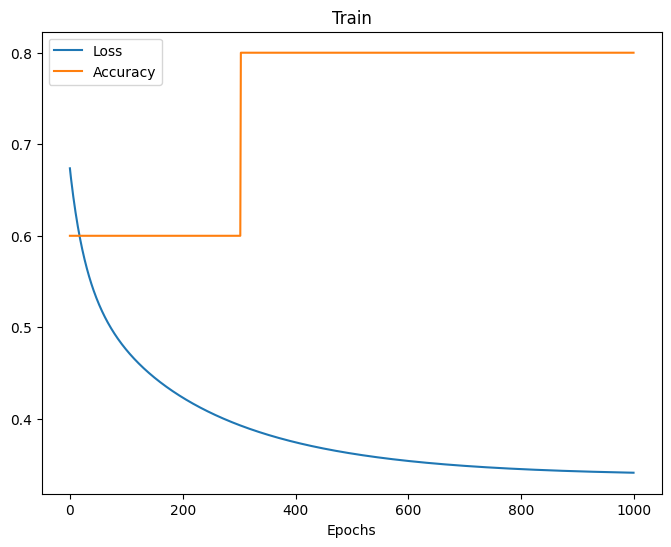

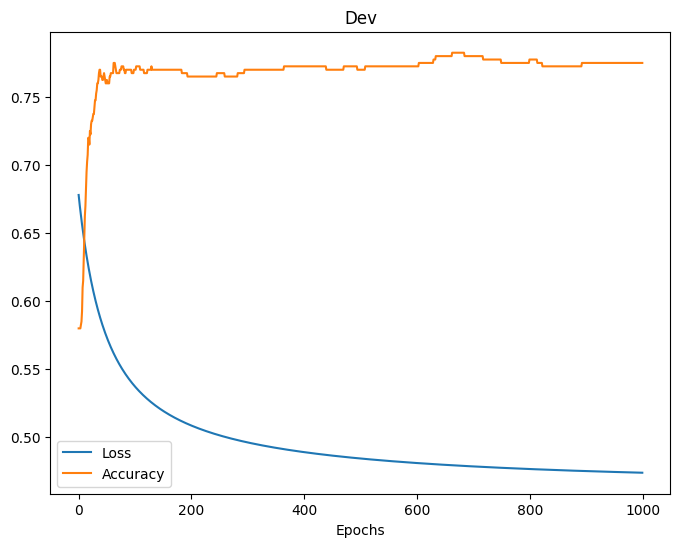

In [ ]:
lambdas = [ 1, 0.1, 0.01, 0.001, 0.00001]
bests, train_accuracies, train_losses , dev_accuracies, dev_losses = [], [], [], [], []

# train by lambd value with best batch size and learning rate values
for l in lambdas:
  print(f"\nTraining Model by lambda: {lr}")
  best = logistic_regression_classifier(train, dev, batch_size = 16, epochs = 1000, learning_rate = 0.01, lambda_l2_reg = l)

  bests.append(best)
  train_accuracies.append(best["Train Acc"])
  train_losses.append(best["Train Loss"])
  dev_accuracies.append(best["Dev Acc"])
  dev_losses.append(best["Dev Loss"])

In [ ]:
results_Q7 = {
    "Lambdas": lambdas,
    "Train Acc": [train_accuracies[i][-1] for i in range(len(lambdas))],
    "Train Loss": [train_losses[i][-1] for i in range(len(lambdas))],
    "Dev Acc": [dev_accuracies[i][-1] for i in range(len(lambdas))],
    "Dev Loss": [dev_losses[i][-1] for i in range(len(lambdas))],
    "Best Dev Acc": [bests[i]["best_dev_acc"] for i in range(len(lambdas))],
    "Overflow": [1 if np.isnan(train_losses[i][-1]) or np.isnan(dev_losses[i][-1]) else 0 for i in range(len(lambdas))]
}

# display acc/loss per datasets and best dev acc
pd.DataFrame(results_Q7)

Lambdas  Train Acc  Train Loss  Dev Acc  Dev Loss  Best Dev Acc  Overflow
0  1.00000        0.6    0.673689    0.580  0.679509        0.5800         0
1  0.10000        0.6    0.645393    0.630  0.662924        0.6325         0
2  0.01000        0.6    0.537056    0.770  0.595033        0.7725         0
3  0.00100        0.8    0.398591    0.775  0.510729        0.7750         0
4  0.00001        0.8    0.341148    0.775  0.473964        0.7825         0

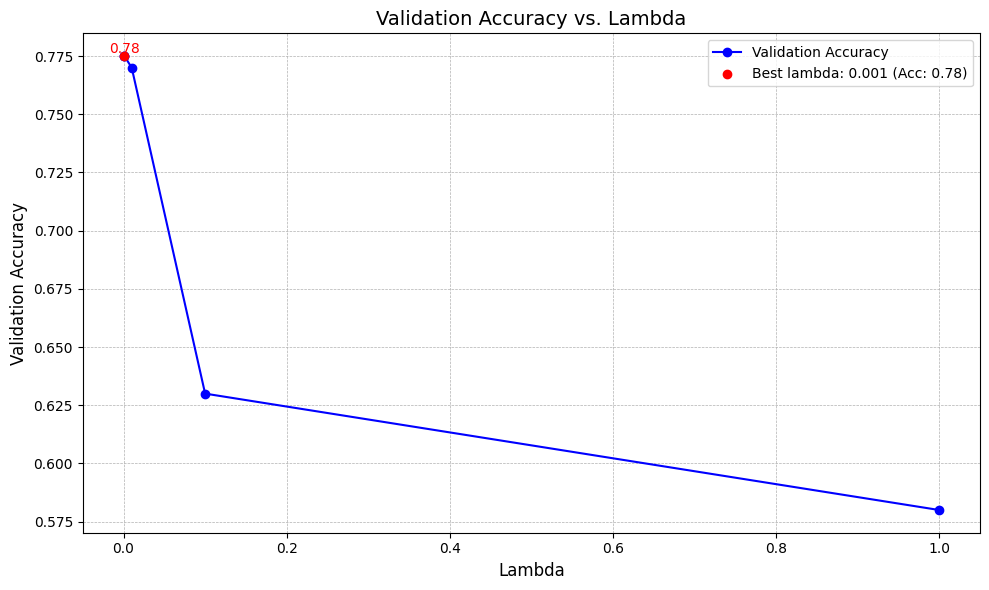

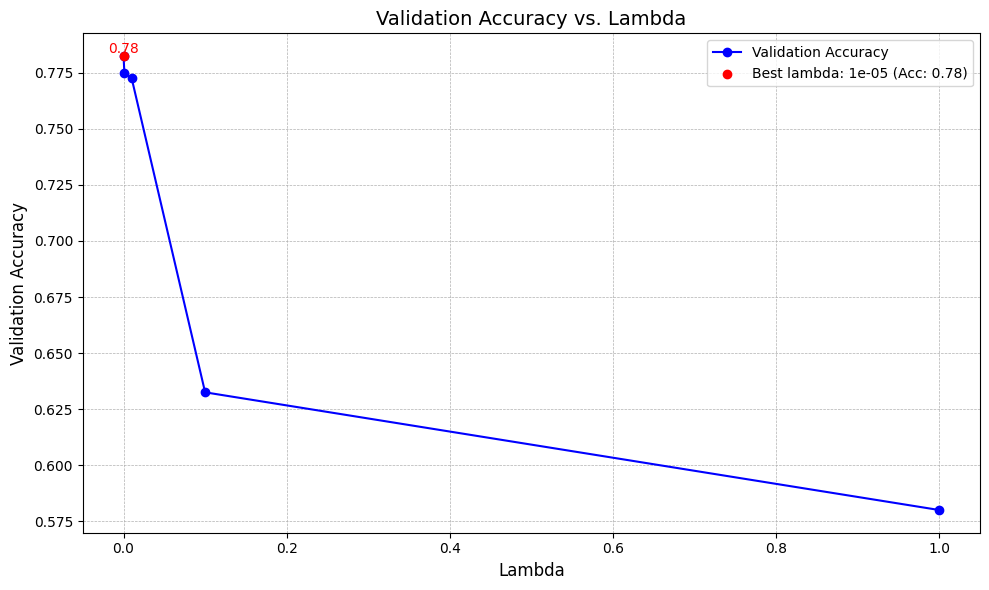

In [ ]:
def best_lambda_by_dev_acc(lambdas, dev_accuracies):
  plt.figure(figsize=(10, 6))
  plt.plot(lambdas, dev_accuracies, marker="o", color="blue", label="Validation Accuracy")

  best_index = np.argmax(dev_accuracies)
  best_lambda = lambdas[best_index]
  best_acc = dev_accuracies[best_index]

  plt.scatter(best_lambda, best_acc, color="red", zorder=5, label=f"Best lambda: {best_lambda} (Acc: {best_acc:.2f})")
  plt.text(best_lambda, best_acc, f"{best_acc:.2f}", ha="center", va="bottom", color="red", fontsize=10)
  plt.xlabel("Lambda", fontsize=12)
  plt.ylabel("Validation Accuracy", fontsize=12)
  plt.title("Validation Accuracy vs. Lambda", fontsize=14)
  plt.grid(True, which="both", linestyle="--", linewidth=0.5)
  plt.legend()
  plt.tight_layout()
  plt.show()

  return best_lambda

# plotting and get best lambdas by dev acc
best_lambda = best_lambda_by_dev_acc(results_Q7["Lambdas"], results_Q7["Dev Acc"])
best_lambda = best_lambda_by_dev_acc(results_Q7["Lambdas"], results_Q7["Best Dev Acc"])


In [ ]:
# preparing best model by best lambda
best_model = next((entry for entry in bests if entry["best_lambda"] == best_lambda), None)
best_w = best_model["best_weights"]
best_b = best_model["best_bias"]

test_model(test_norm_embeddings, y_test, best_w, best_b)


Test Accuracy: 79.00%


0.79

## Disable Normalization

### Train without normalization and L2



Training Model by learning rate: 10000
disable norm 
Epoch 10/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6150
Epoch 20/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7800
Epoch 30/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.5750


<ipython-input-20-c1927be7dc8c>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-1 * (f_wb))) # sigmoid
<ipython-input-20-c1927be7dc8c>:13: RuntimeWarning: divide by zero encountered in log
  loss = -1 * np.mean((y * np.log(y_pred)) + (1 - y) * np.log(1 - y_pred))
<ipython-input-20-c1927be7dc8c>:13: RuntimeWarning: invalid value encountered in multiply
  loss = -1 * np.mean((y * np.log(y_pred)) + (1 - y) * np.log(1 - y_pred))


Epoch 40/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6650
Epoch 50/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7750
Epoch 60/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6850
Epoch 70/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.5100
Epoch 80/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7550
Epoch 90/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6875
Epoch 100/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7150
Epoch 110/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7625
Epoch 120/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6700
Epoch 130/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6800
Epoch 140/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7325
Epoch 150/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7600
Epoch 160/1000, Loss: nan, Accurac

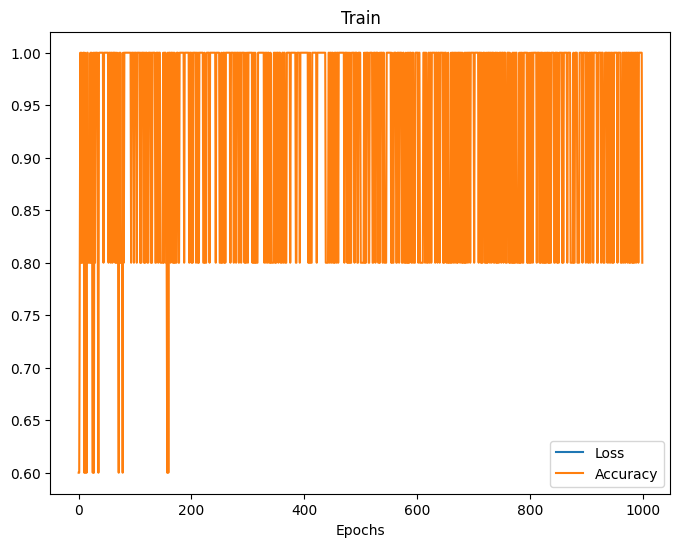

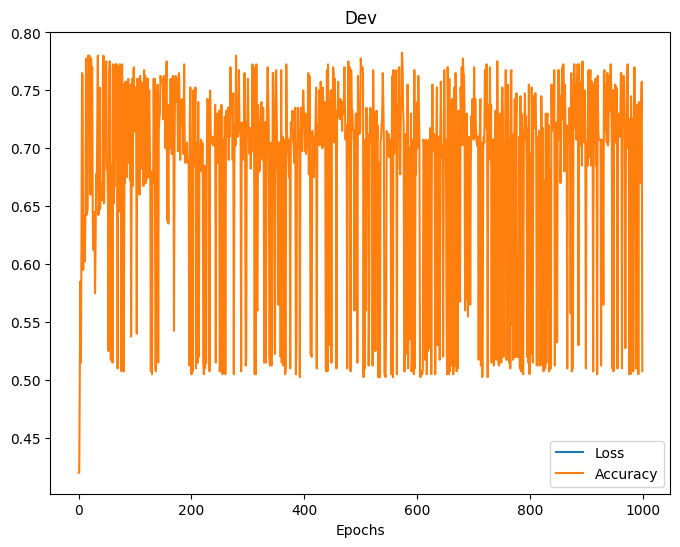


Training Model by learning rate: 1000
disable norm 
Epoch 10/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6550
Epoch 20/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7750
Epoch 30/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6475
Epoch 40/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7675
Epoch 50/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7800
Epoch 60/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.5250
Epoch 70/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6650
Epoch 80/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6425
Epoch 90/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7600
Epoch 100/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7075
Epoch 110/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6700
Epoch 120/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev A

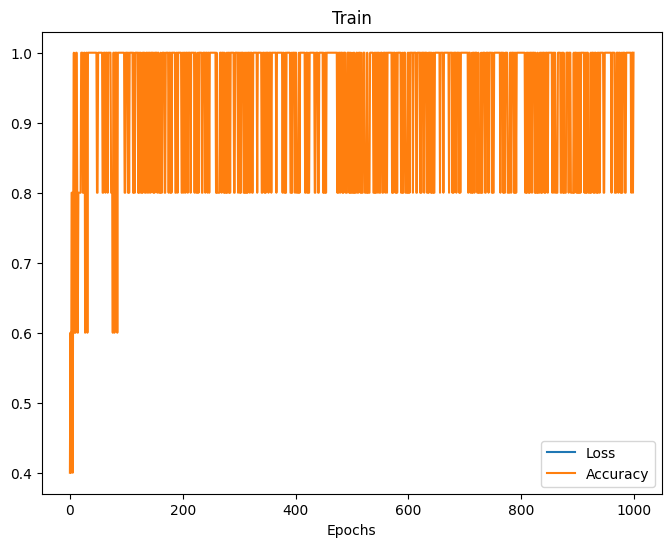

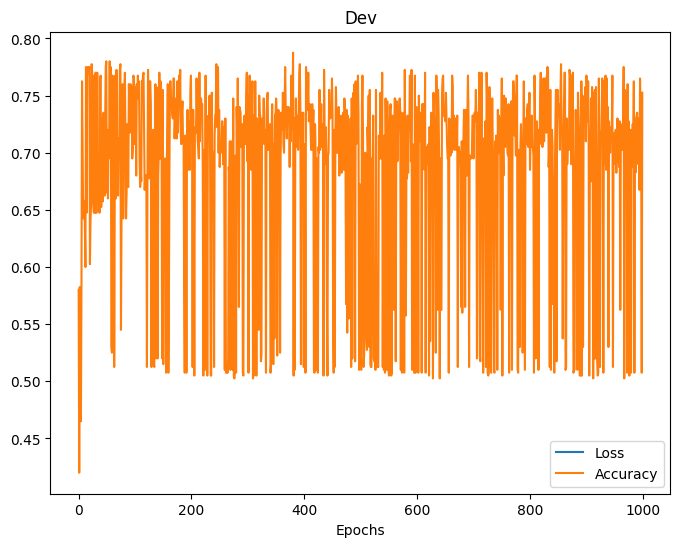


Training Model by learning rate: 100
disable norm 
Epoch 10/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7575
Epoch 20/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7825
Epoch 30/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6650
Epoch 40/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7525
Epoch 50/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7625
Epoch 60/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6400
Epoch 70/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6700
Epoch 80/1000, Loss: nan, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6475
Epoch 90/1000, Loss: nan, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.5100
Epoch 100/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6975
Epoch 110/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7550
Epoch 120/1000, Loss: nan, Accuracy: 1.0000, Dev Loss: nan, Dev Ac

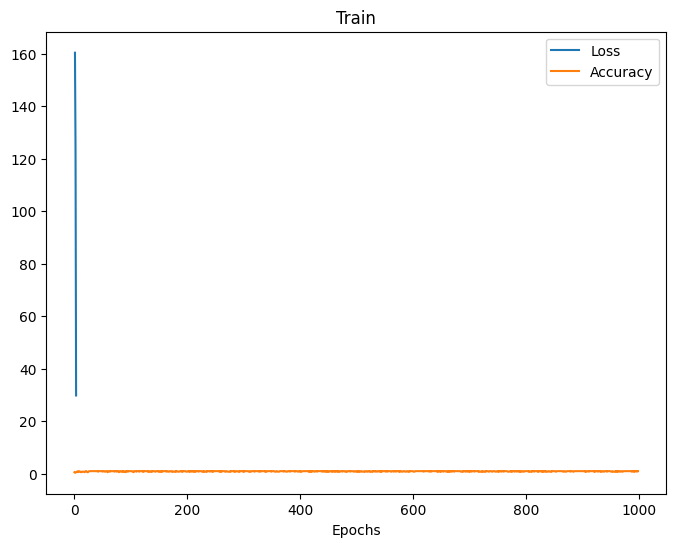

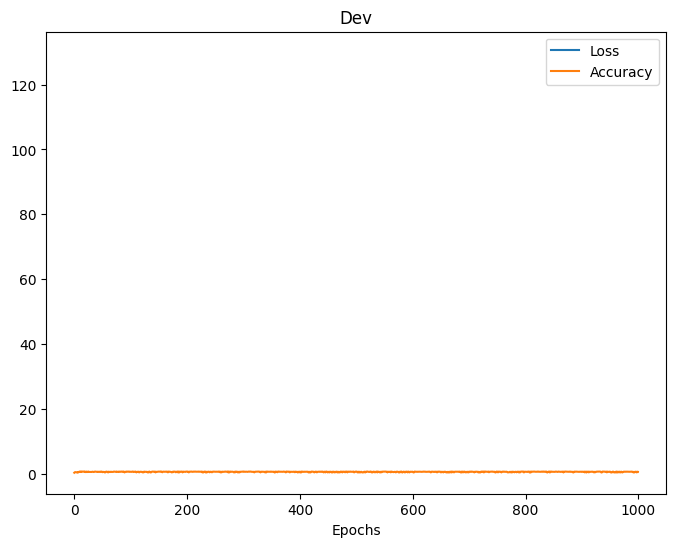


Training Model by learning rate: 10
disable norm 
Epoch 10/1000, Loss: 0.2792, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7675
Epoch 20/1000, Loss: 1.0808, Accuracy: 0.6000, Dev Loss: nan, Dev Accuracy: 0.6925
Epoch 30/1000, Loss: 0.5103, Accuracy: 0.8000, Dev Loss: nan, Dev Accuracy: 0.7775
Epoch 40/1000, Loss: 0.1064, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7550
Epoch 50/1000, Loss: 0.0207, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6875
Epoch 60/1000, Loss: 0.0056, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.6900
Epoch 70/1000, Loss: 0.0291, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7250
Epoch 80/1000, Loss: 0.0207, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7150
Epoch 90/1000, Loss: 0.0131, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7325
Epoch 100/1000, Loss: 0.0256, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7175
Epoch 110/1000, Loss: 0.0051, Accuracy: 1.0000, Dev Loss: nan, Dev Accuracy: 0.7300
Epoch 120/1000, Loss: 0.0019, Accu

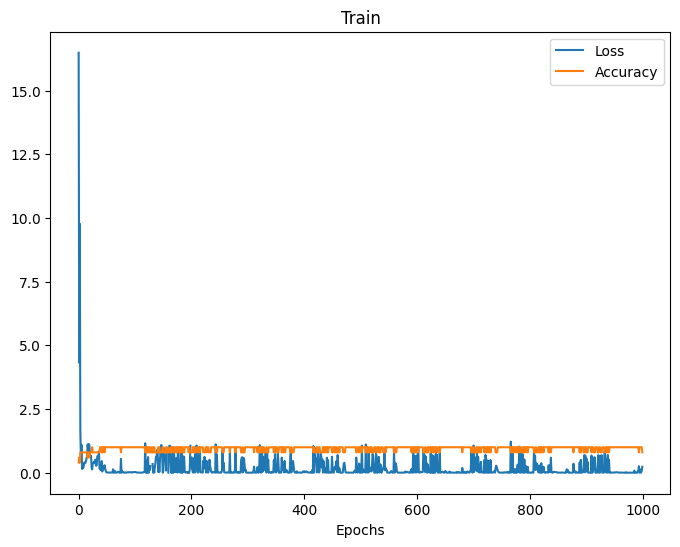

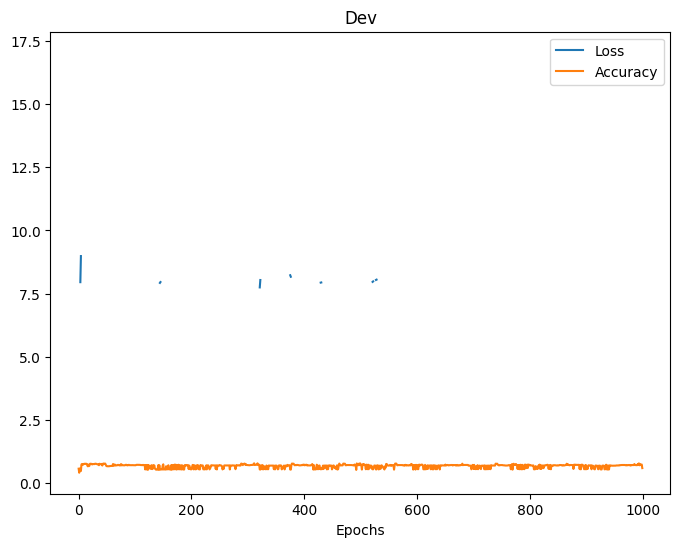


Training Model by learning rate: 1
disable norm 
Epoch 10/1000, Loss: 0.2759, Accuracy: 1.0000, Dev Loss: 0.5084, Dev Accuracy: 0.7450
Epoch 20/1000, Loss: 0.1950, Accuracy: 1.0000, Dev Loss: 0.5690, Dev Accuracy: 0.7225
Epoch 30/1000, Loss: 0.1926, Accuracy: 1.0000, Dev Loss: 0.5834, Dev Accuracy: 0.7125
Epoch 40/1000, Loss: 0.1987, Accuracy: 1.0000, Dev Loss: 0.5876, Dev Accuracy: 0.7100
Epoch 50/1000, Loss: 0.2050, Accuracy: 1.0000, Dev Loss: 0.5897, Dev Accuracy: 0.7125
Epoch 60/1000, Loss: 0.2103, Accuracy: 1.0000, Dev Loss: 0.5914, Dev Accuracy: 0.7200
Epoch 70/1000, Loss: 0.2146, Accuracy: 1.0000, Dev Loss: 0.5931, Dev Accuracy: 0.7200
Epoch 80/1000, Loss: 0.2181, Accuracy: 1.0000, Dev Loss: 0.5949, Dev Accuracy: 0.7225
Epoch 90/1000, Loss: 0.2210, Accuracy: 1.0000, Dev Loss: 0.5966, Dev Accuracy: 0.7225
Epoch 100/1000, Loss: 0.2234, Accuracy: 1.0000, Dev Loss: 0.5983, Dev Accuracy: 0.7225
Epoch 110/1000, Loss: 0.2255, Accuracy: 1.0000, Dev Loss: 0.5998, Dev Accuracy: 0.7200
Ep

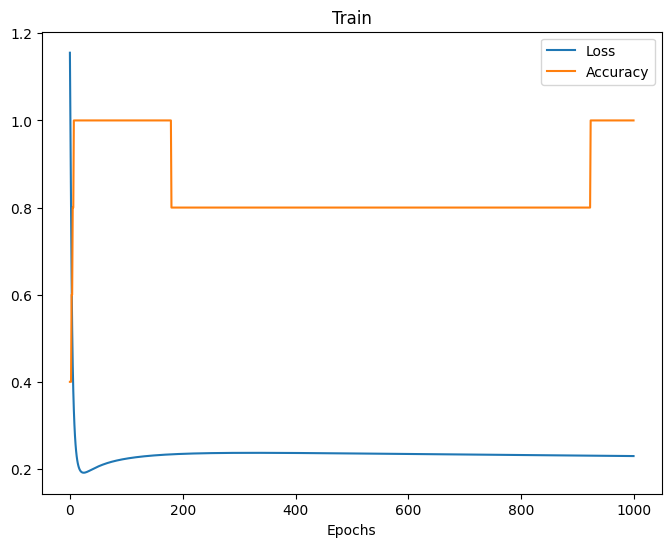

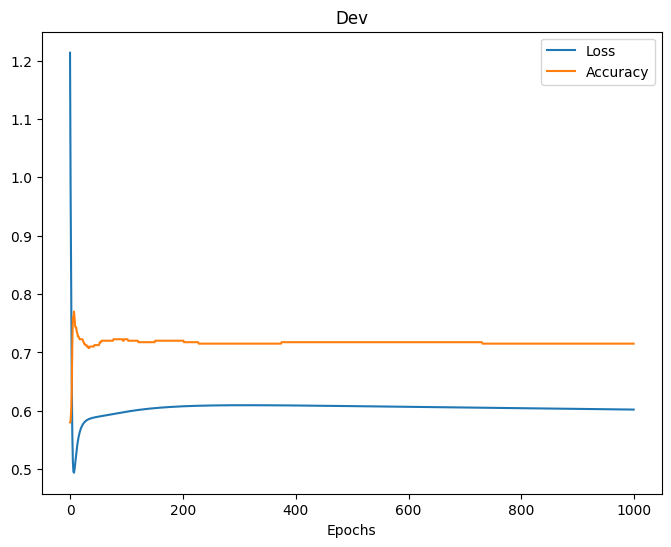


Training Model by learning rate: 0.01
disable norm 
Epoch 10/1000, Loss: 0.6543, Accuracy: 0.6000, Dev Loss: 0.6655, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6357, Accuracy: 0.6000, Dev Loss: 0.6535, Dev Accuracy: 0.5950
Epoch 30/1000, Loss: 0.6196, Accuracy: 0.6000, Dev Loss: 0.6430, Dev Accuracy: 0.6450
Epoch 40/1000, Loss: 0.6055, Accuracy: 0.6000, Dev Loss: 0.6337, Dev Accuracy: 0.6725
Epoch 50/1000, Loss: 0.5931, Accuracy: 0.6000, Dev Loss: 0.6255, Dev Accuracy: 0.7025
Epoch 60/1000, Loss: 0.5821, Accuracy: 0.6000, Dev Loss: 0.6180, Dev Accuracy: 0.7150
Epoch 70/1000, Loss: 0.5722, Accuracy: 0.8000, Dev Loss: 0.6113, Dev Accuracy: 0.7300
Epoch 80/1000, Loss: 0.5632, Accuracy: 0.8000, Dev Loss: 0.6052, Dev Accuracy: 0.7425
Epoch 90/1000, Loss: 0.5551, Accuracy: 0.8000, Dev Loss: 0.5996, Dev Accuracy: 0.7250
Epoch 100/1000, Loss: 0.5476, Accuracy: 0.8000, Dev Loss: 0.5944, Dev Accuracy: 0.7225
Epoch 110/1000, Loss: 0.5407, Accuracy: 0.8000, Dev Loss: 0.5896, Dev Accuracy: 0.7225

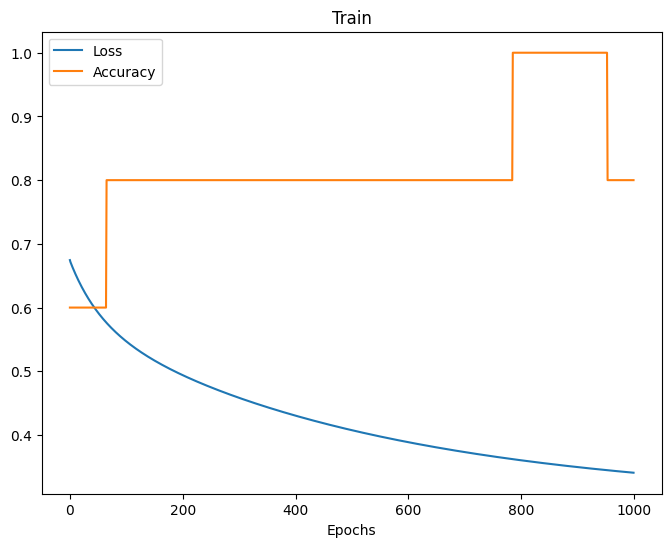

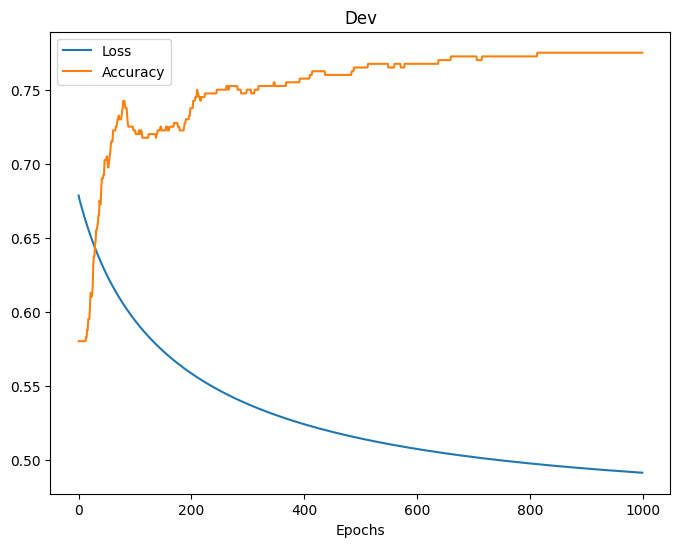


Training Model by learning rate: 0.001
disable norm 
Epoch 10/1000, Loss: 0.6738, Accuracy: 0.6000, Dev Loss: 0.6783, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6708, Accuracy: 0.6000, Dev Loss: 0.6763, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6685, Accuracy: 0.6000, Dev Loss: 0.6748, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6663, Accuracy: 0.6000, Dev Loss: 0.6734, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6641, Accuracy: 0.6000, Dev Loss: 0.6720, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6620, Accuracy: 0.6000, Dev Loss: 0.6706, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6599, Accuracy: 0.6000, Dev Loss: 0.6693, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6578, Accuracy: 0.6000, Dev Loss: 0.6679, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6557, Accuracy: 0.6000, Dev Loss: 0.6666, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6537, Accuracy: 0.6000, Dev Loss: 0.6653, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6518, Accuracy: 0.6000, Dev Loss: 0.6640, Dev Accuracy: 0.580

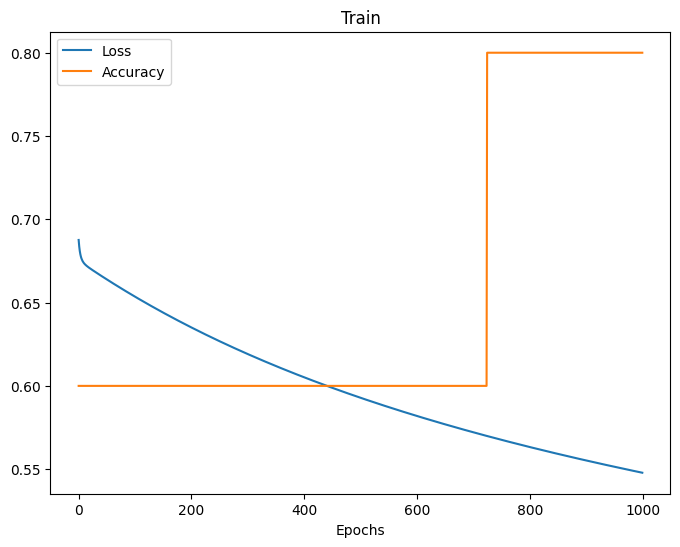

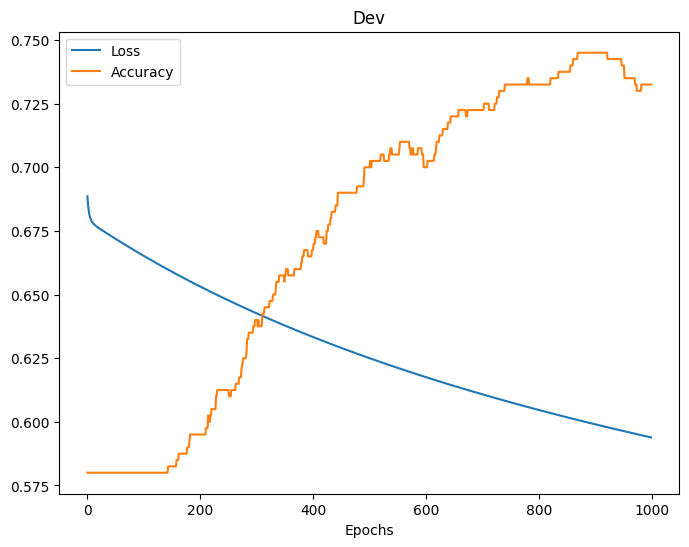


Training Model by learning rate: 0.0001
disable norm 
Epoch 10/1000, Loss: 0.6875, Accuracy: 0.6000, Dev Loss: 0.6886, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6836, Accuracy: 0.6000, Dev Loss: 0.6856, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6809, Accuracy: 0.6000, Dev Loss: 0.6835, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6789, Accuracy: 0.6000, Dev Loss: 0.6820, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6775, Accuracy: 0.6000, Dev Loss: 0.6809, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6764, Accuracy: 0.6000, Dev Loss: 0.6801, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6755, Accuracy: 0.6000, Dev Loss: 0.6795, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6749, Accuracy: 0.6000, Dev Loss: 0.6790, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6743, Accuracy: 0.6000, Dev Loss: 0.6786, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6738, Accuracy: 0.6000, Dev Loss: 0.6783, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6734, Accuracy: 0.6000, Dev Loss: 0.6780, Dev Accuracy: 0.58

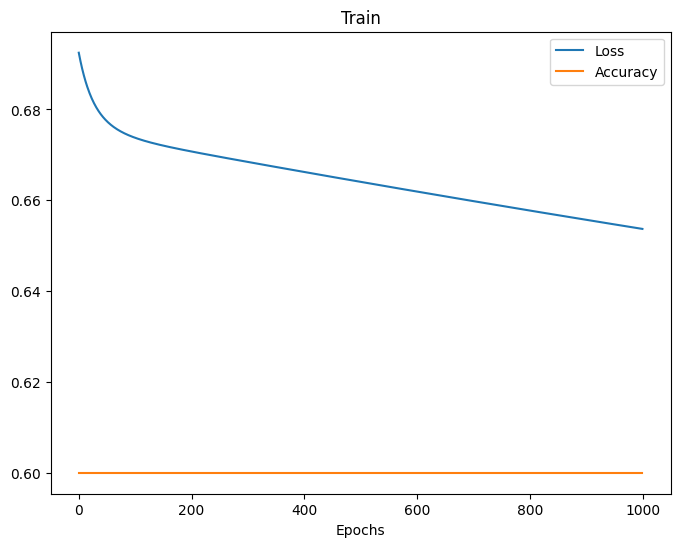

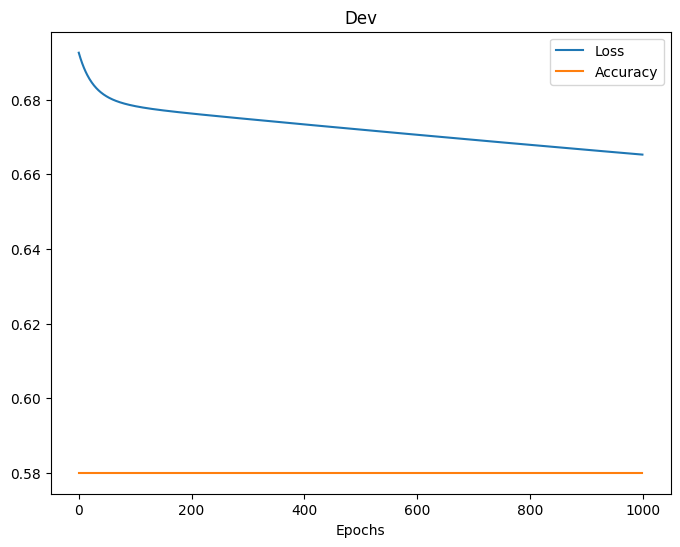


Training Model by learning rate: 1e-05
disable norm 
Epoch 10/1000, Loss: 0.6925, Accuracy: 0.6000, Dev Loss: 0.6926, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6918, Accuracy: 0.6000, Dev Loss: 0.6921, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6912, Accuracy: 0.6000, Dev Loss: 0.6916, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6906, Accuracy: 0.6000, Dev Loss: 0.6911, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6900, Accuracy: 0.6000, Dev Loss: 0.6906, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6895, Accuracy: 0.6000, Dev Loss: 0.6902, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6890, Accuracy: 0.6000, Dev Loss: 0.6898, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6885, Accuracy: 0.6000, Dev Loss: 0.6894, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6880, Accuracy: 0.6000, Dev Loss: 0.6890, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6875, Accuracy: 0.6000, Dev Loss: 0.6886, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6870, Accuracy: 0.6000, Dev Loss: 0.6882, Dev Accuracy: 0.580

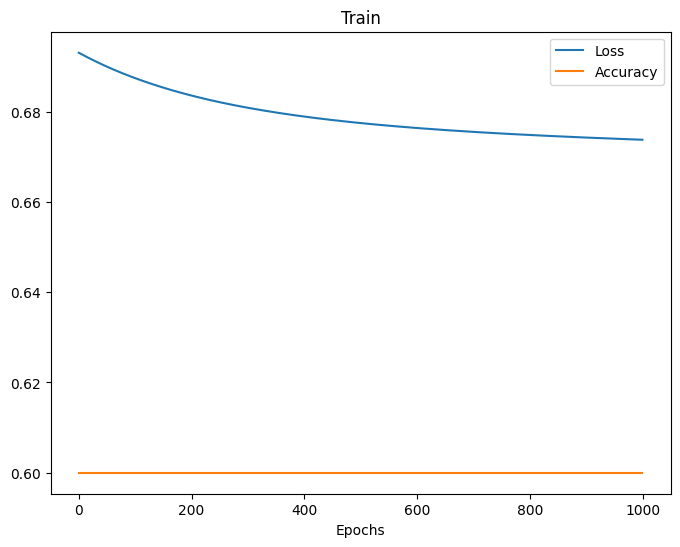

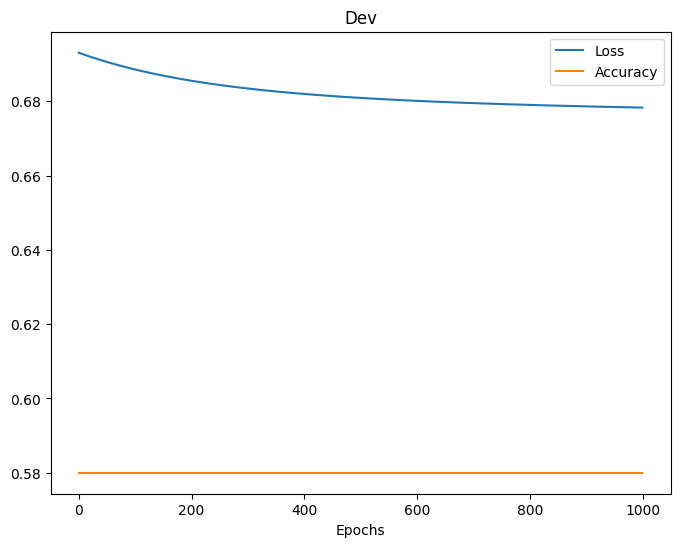

In [ ]:
learning_rates = [10000, 1000, 100, 10, 1, 0.01, 0.001, 0.0001, 0.00001]
bests, train_accuracies, train_losses , dev_accuracies, dev_losses = [], [], [], [], []

# train without normalization and L2
for lr in learning_rates:
  print(f"\nTraining Model by learning rate: {lr}")
  best = logistic_regression_classifier(train, dev, batch_size = 16, epochs = 1000, learning_rate = lr, norm = False)

  bests.append(best)
  train_accuracies.append(best["Train Acc"])
  train_losses.append(best["Train Loss"])
  dev_accuracies.append(best["Dev Acc"])
  dev_losses.append(best["Dev Loss"])

In [ ]:
results_Q8 = {
    "Learning Rate": learning_rates,
    "Train Acc": [train_accuracies[i][-1] for i in range(len(learning_rates))],
    "Train Loss": [train_losses[i][-1] for i in range(len(learning_rates))],
    "Dev Acc": [dev_accuracies[i][-1] for i in range(len(learning_rates))],
    "Dev Loss": [dev_losses[i][-1] for i in range(len(learning_rates))],
    "Best Dev Acc": [bests[i]["best_dev_acc"] for i in range(len(learning_rates))],
    "Overflow": [1 if np.isnan(train_losses[i][-1]) or np.isnan(dev_losses[i][-1]) else 0 for i in range(len(learning_rates))]
}

pd.DataFrame(results_Q8)

Learning Rate  Train Acc  Train Loss  Dev Acc  Dev Loss  Best Dev Acc  \
0    10000.00000        0.8         NaN   0.5075       NaN        0.7825   
1     1000.00000        1.0         NaN   0.7525       NaN        0.7875   
2      100.00000        1.0         NaN   0.6875       NaN        0.7825   
3       10.00000        0.8    0.235562   0.6025       NaN        0.7925   
4        1.00000        1.0    0.229577   0.7150  0.602038        0.7700   
5        0.01000        0.8    0.340782   0.7750  0.491079        0.7750   
6        0.00100        0.8    0.547868   0.7325  0.593883        0.7450   
7        0.00010        0.6    0.653692   0.5800  0.665291        0.5800   
8        0.00001        0.6    0.673794   0.5800  0.678313        0.5800   

   Overflow  
0         1  
1         1  
2         1  
3         1  
4         0  
5         0  
6         0  
7         0  
8         0

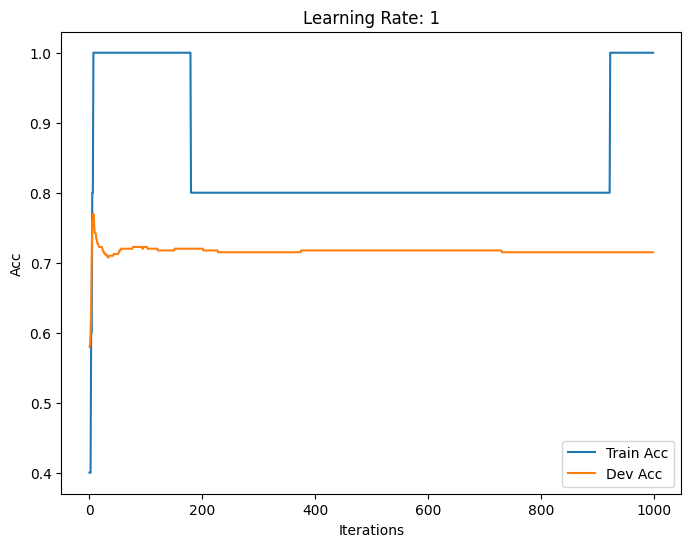

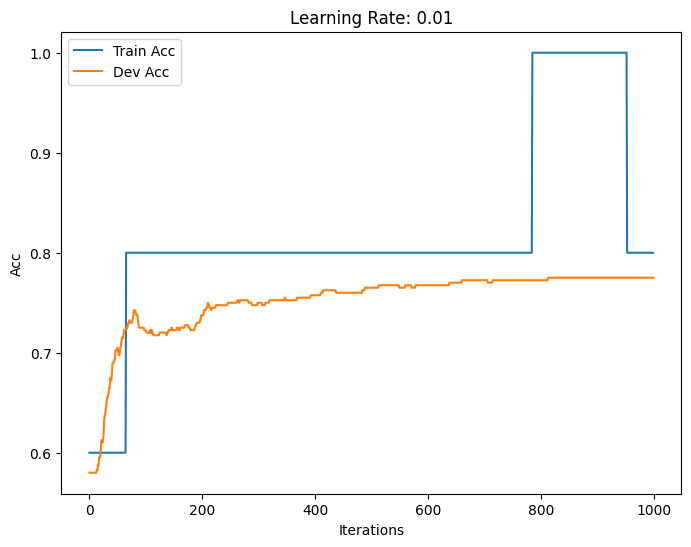

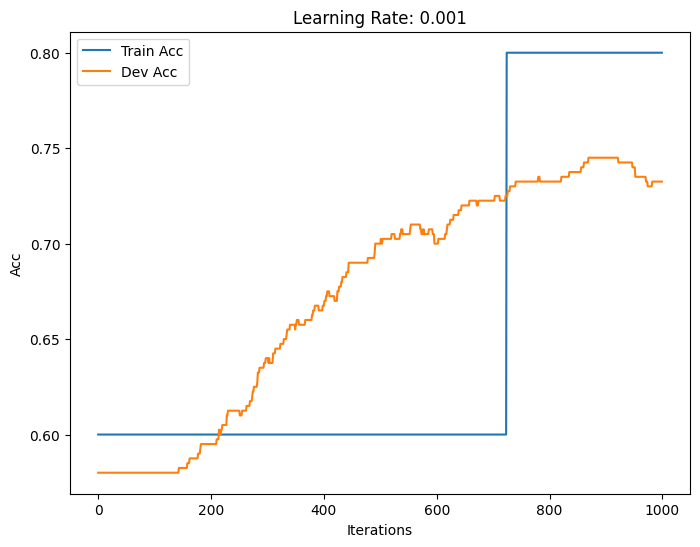

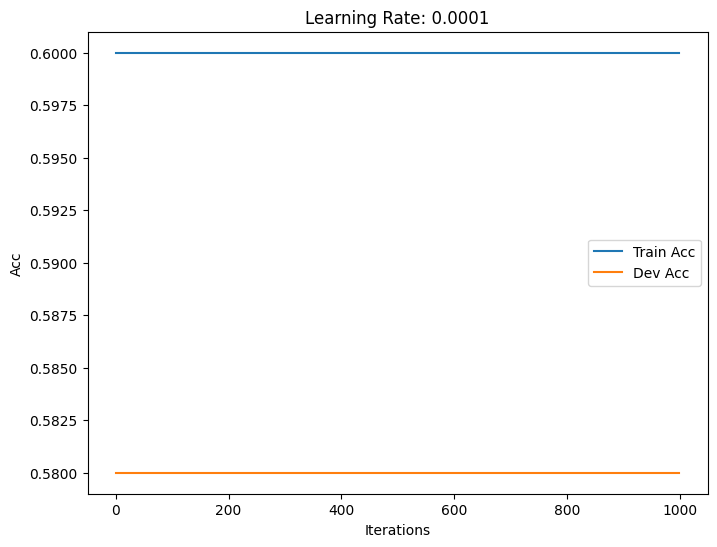

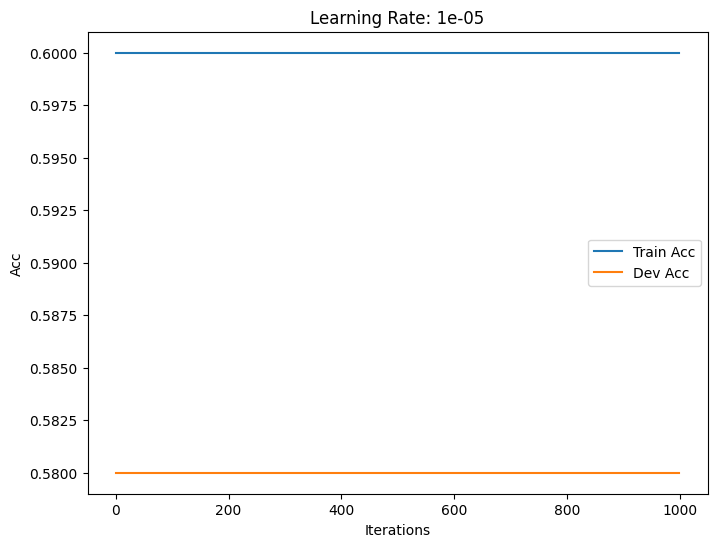

In [ ]:
for i in range(len(learning_rates)):
  if results_Q8["Overflow"][i] == 0:
    plt.figure(figsize=(8, 6))
    plt.plot(train_accuracies[i], label="Train Acc")
    plt.plot(dev_accuracies[i], label="Dev Acc")
    plt.xlabel("Iterations")
    plt.ylabel("Acc")
    plt.title(str(f"Learning Rate: {learning_rates[i]}"))
    plt.legend()
    plt.show()

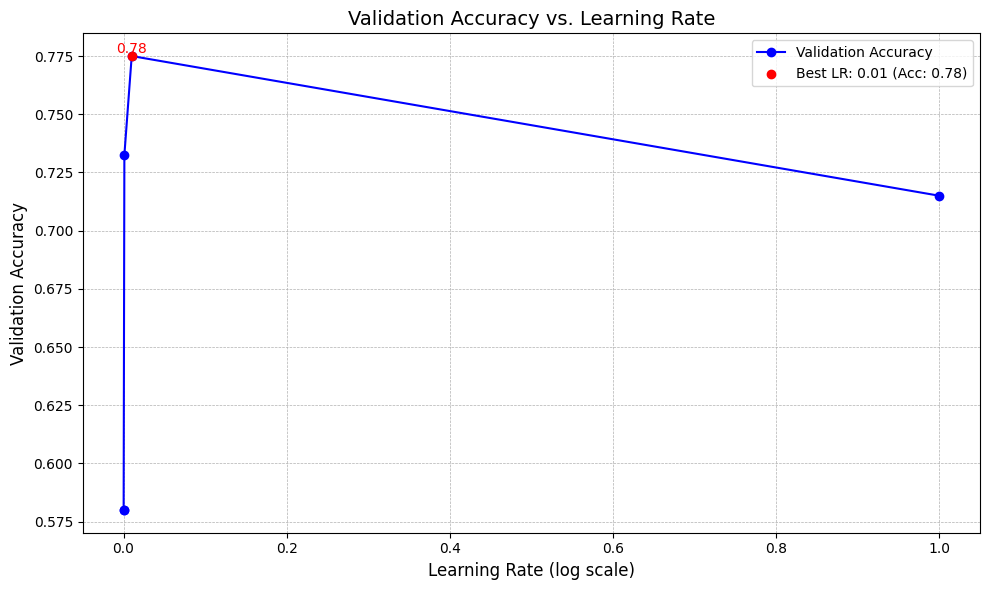

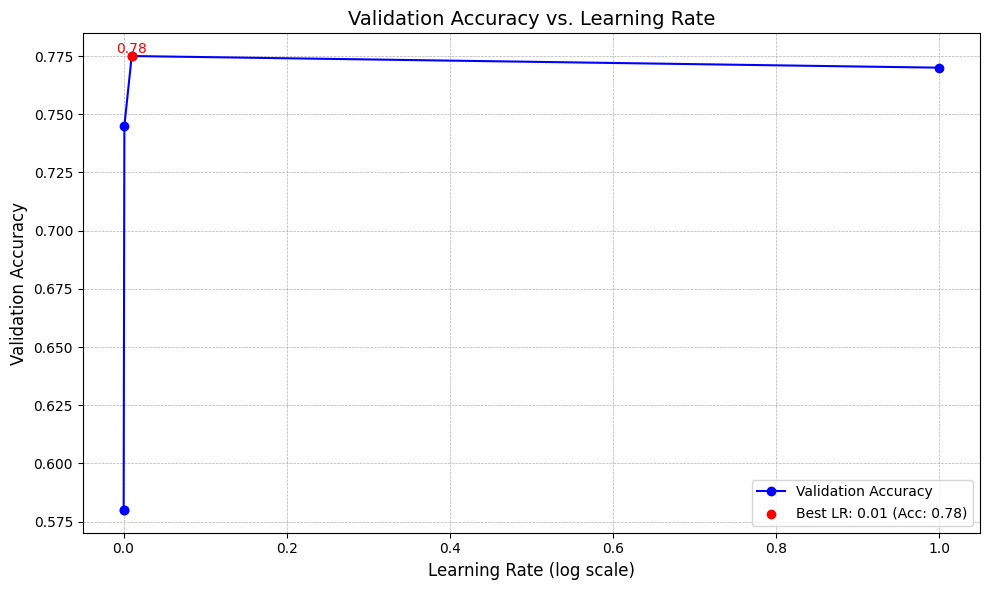

In [ ]:

best_learning_rate = best_lr_by_dev_acc(results_Q8["Learning Rate"][4:], results_Q8["Dev Acc"][4:])
best_learning_rate = best_lr_by_dev_acc(results_Q8["Learning Rate"][4:], results_Q8["Best Dev Acc"][4:])


In [ ]:
best_learning_rate

0.01

In [ ]:
# preparing best model
best_model = next((entry for entry in bests if entry["best_lr"] == best_learning_rate), None)
best_w = best_model["best_weights"]
best_b = best_model["best_bias"]


test_model(test_norm_embeddings, y_test, best_w, best_b)


Test Accuracy: 71.25%


0.7125

### Train without normalization, but with L2



Training Model by lambda: 1e-05
disable norm 
Epoch 10/1000, Loss: 0.6770, Accuracy: 0.6000, Dev Loss: 0.6812, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6763, Accuracy: 0.6000, Dev Loss: 0.6808, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6759, Accuracy: 0.6000, Dev Loss: 0.6807, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6758, Accuracy: 0.6000, Dev Loss: 0.6806, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6757, Accuracy: 0.6000, Dev Loss: 0.6806, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6757, Accuracy: 0.6000, Dev Loss: 0.6806, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6757, Accuracy: 0.6000, Dev Loss: 0.6805, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6756, Accuracy: 0.6000, Dev Loss: 0.6805, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6756, Accuracy: 0.6000, Dev Loss: 0.6805, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6756, Accuracy: 0.6000, Dev Loss: 0.6805, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6756, Accuracy: 0.6000, Dev Loss: 0.6805, Dev Accuracy: 0.5800
Epoch

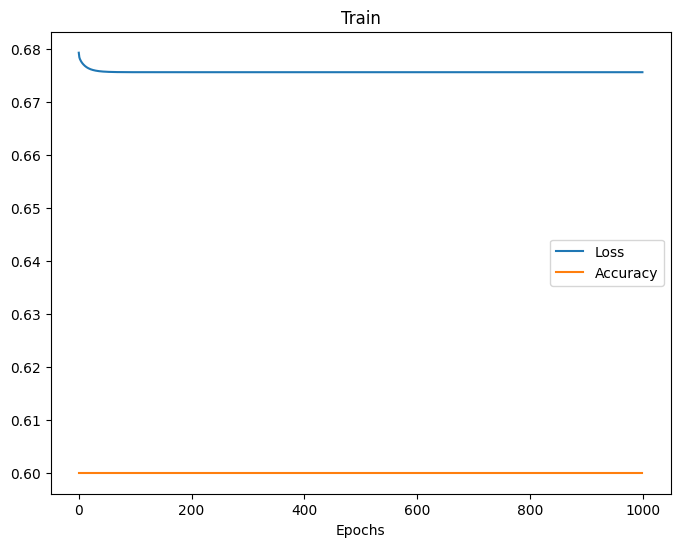

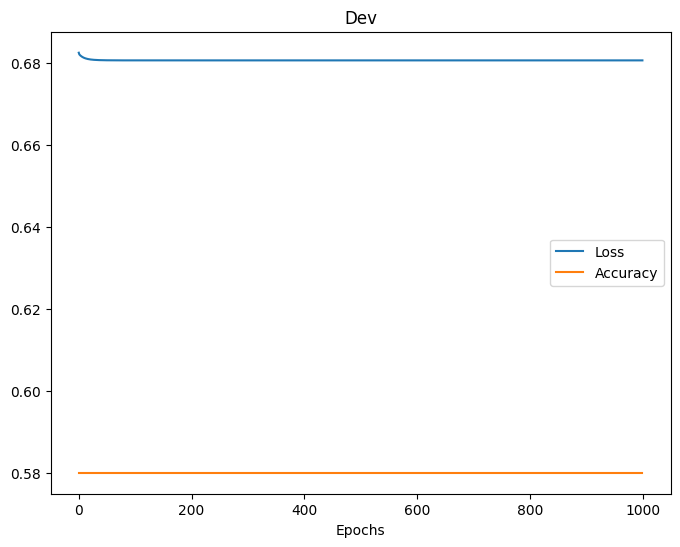


Training Model by lambda: 1e-05
disable norm 
Epoch 10/1000, Loss: 0.6649, Accuracy: 0.6000, Dev Loss: 0.6735, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6622, Accuracy: 0.6000, Dev Loss: 0.6727, Dev Accuracy: 0.5800
Epoch 30/1000, Loss: 0.6615, Accuracy: 0.6000, Dev Loss: 0.6725, Dev Accuracy: 0.5800
Epoch 40/1000, Loss: 0.6613, Accuracy: 0.6000, Dev Loss: 0.6725, Dev Accuracy: 0.5800
Epoch 50/1000, Loss: 0.6612, Accuracy: 0.6000, Dev Loss: 0.6724, Dev Accuracy: 0.5800
Epoch 60/1000, Loss: 0.6612, Accuracy: 0.6000, Dev Loss: 0.6724, Dev Accuracy: 0.5800
Epoch 70/1000, Loss: 0.6612, Accuracy: 0.6000, Dev Loss: 0.6723, Dev Accuracy: 0.5800
Epoch 80/1000, Loss: 0.6612, Accuracy: 0.6000, Dev Loss: 0.6723, Dev Accuracy: 0.5800
Epoch 90/1000, Loss: 0.6612, Accuracy: 0.6000, Dev Loss: 0.6723, Dev Accuracy: 0.5800
Epoch 100/1000, Loss: 0.6612, Accuracy: 0.6000, Dev Loss: 0.6723, Dev Accuracy: 0.5800
Epoch 110/1000, Loss: 0.6612, Accuracy: 0.6000, Dev Loss: 0.6723, Dev Accuracy: 0.5800
Epoch

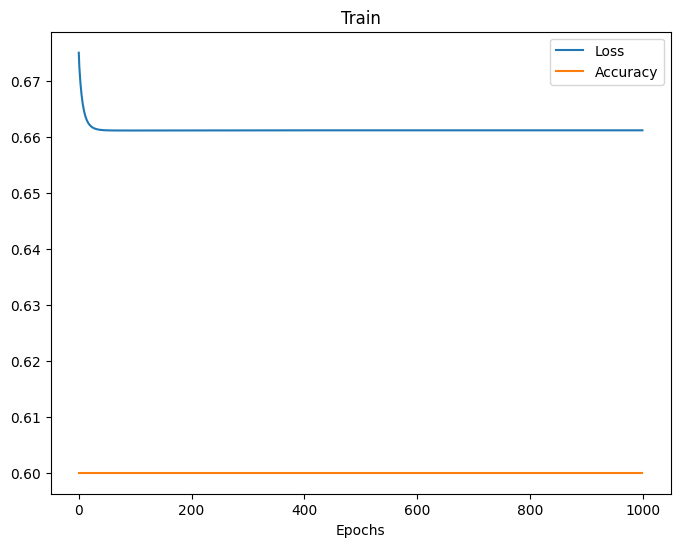

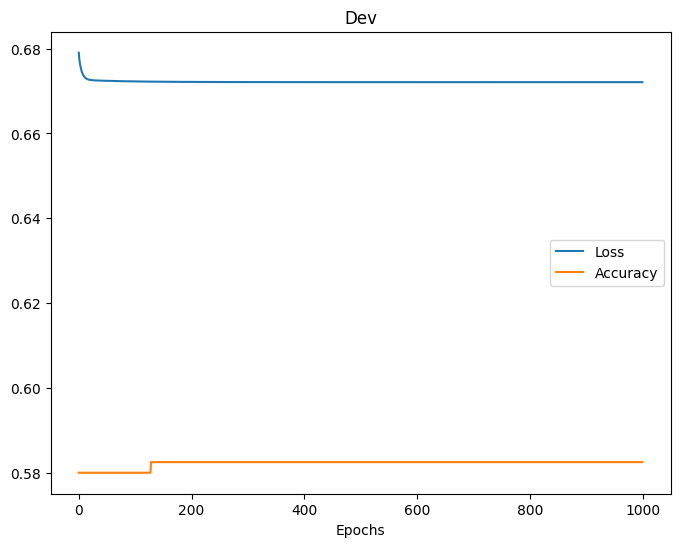


Training Model by lambda: 1e-05
disable norm 
Epoch 10/1000, Loss: 0.6544, Accuracy: 0.6000, Dev Loss: 0.6657, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6362, Accuracy: 0.6000, Dev Loss: 0.6540, Dev Accuracy: 0.5950
Epoch 30/1000, Loss: 0.6207, Accuracy: 0.6000, Dev Loss: 0.6439, Dev Accuracy: 0.6425
Epoch 40/1000, Loss: 0.6074, Accuracy: 0.6000, Dev Loss: 0.6352, Dev Accuracy: 0.6725
Epoch 50/1000, Loss: 0.5958, Accuracy: 0.6000, Dev Loss: 0.6276, Dev Accuracy: 0.7025
Epoch 60/1000, Loss: 0.5857, Accuracy: 0.6000, Dev Loss: 0.6209, Dev Accuracy: 0.7150
Epoch 70/1000, Loss: 0.5767, Accuracy: 0.8000, Dev Loss: 0.6149, Dev Accuracy: 0.7275
Epoch 80/1000, Loss: 0.5687, Accuracy: 0.8000, Dev Loss: 0.6096, Dev Accuracy: 0.7325
Epoch 90/1000, Loss: 0.5616, Accuracy: 0.8000, Dev Loss: 0.6048, Dev Accuracy: 0.7375
Epoch 100/1000, Loss: 0.5551, Accuracy: 0.8000, Dev Loss: 0.6005, Dev Accuracy: 0.7275
Epoch 110/1000, Loss: 0.5493, Accuracy: 0.8000, Dev Loss: 0.5965, Dev Accuracy: 0.7225
Epoch

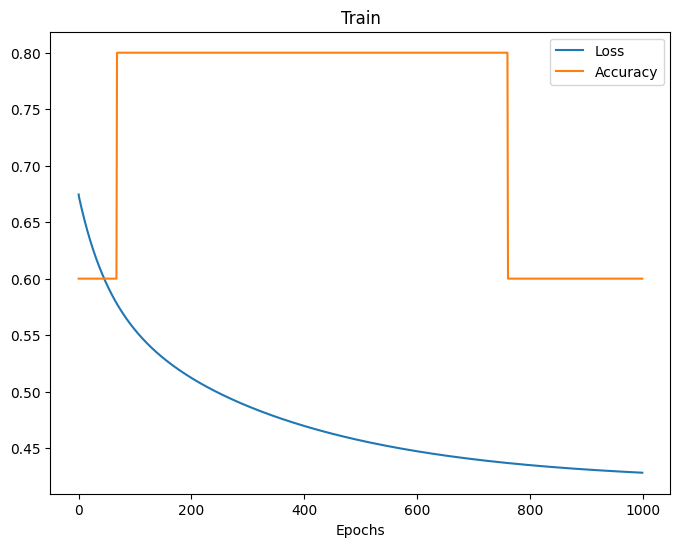

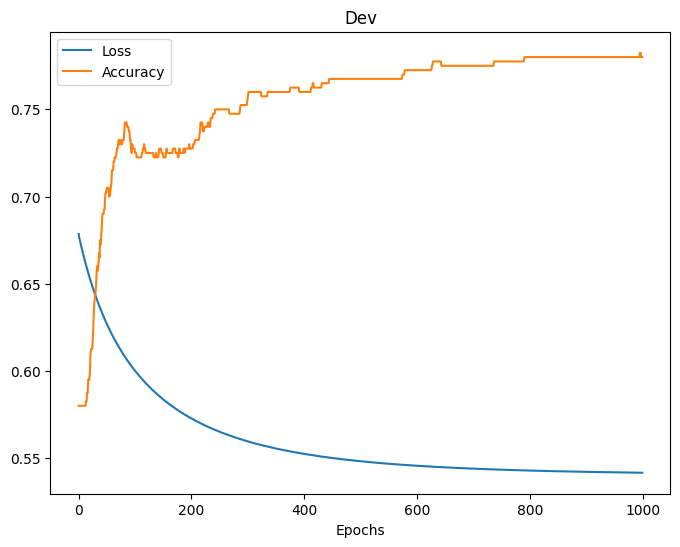


Training Model by lambda: 1e-05
disable norm 
Epoch 10/1000, Loss: 0.6543, Accuracy: 0.6000, Dev Loss: 0.6655, Dev Accuracy: 0.5800
Epoch 20/1000, Loss: 0.6357, Accuracy: 0.6000, Dev Loss: 0.6535, Dev Accuracy: 0.5950
Epoch 30/1000, Loss: 0.6196, Accuracy: 0.6000, Dev Loss: 0.6430, Dev Accuracy: 0.6450
Epoch 40/1000, Loss: 0.6055, Accuracy: 0.6000, Dev Loss: 0.6338, Dev Accuracy: 0.6700
Epoch 50/1000, Loss: 0.5931, Accuracy: 0.6000, Dev Loss: 0.6255, Dev Accuracy: 0.7025
Epoch 60/1000, Loss: 0.5821, Accuracy: 0.6000, Dev Loss: 0.6181, Dev Accuracy: 0.7150
Epoch 70/1000, Loss: 0.5722, Accuracy: 0.8000, Dev Loss: 0.6113, Dev Accuracy: 0.7300
Epoch 80/1000, Loss: 0.5633, Accuracy: 0.8000, Dev Loss: 0.6052, Dev Accuracy: 0.7425
Epoch 90/1000, Loss: 0.5551, Accuracy: 0.8000, Dev Loss: 0.5996, Dev Accuracy: 0.7250
Epoch 100/1000, Loss: 0.5477, Accuracy: 0.8000, Dev Loss: 0.5945, Dev Accuracy: 0.7225
Epoch 110/1000, Loss: 0.5408, Accuracy: 0.8000, Dev Loss: 0.5897, Dev Accuracy: 0.7225
Epoch

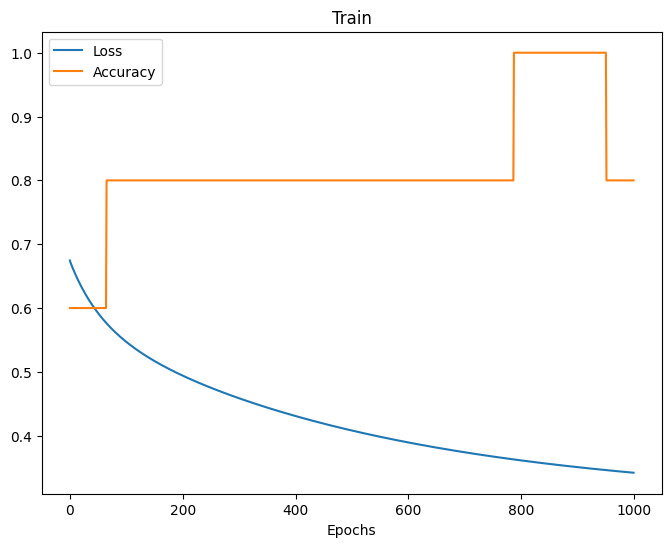

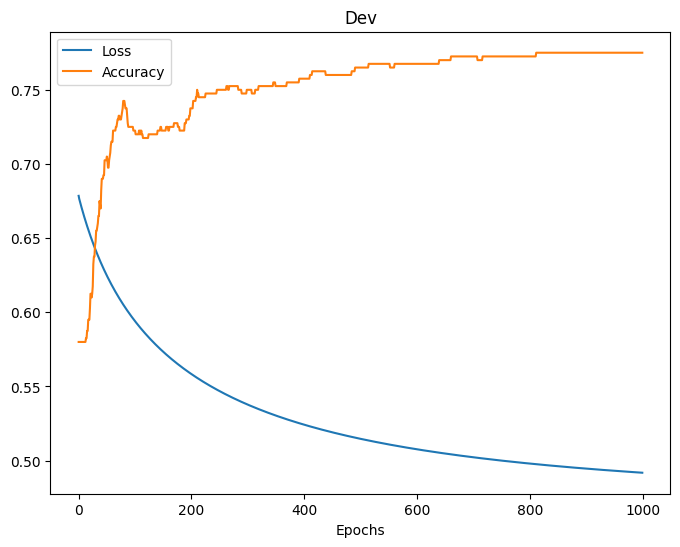

In [ ]:
lambdas = [ 1, 0.1, 0.001, 0.00001]
bests, train_accuracies, train_losses , dev_accuracies, dev_losses = [], [], [], [], []

for l in lambdas:
  print(f"\nTraining Model by lambda: {lr}")
  best = logistic_regression_classifier(train, dev, batch_size = 16, epochs = 1000, learning_rate = 0.01, norm = False, lambda_l2_reg = l)

  bests.append(best)
  train_accuracies.append(best["Train Acc"])
  train_losses.append(best["Train Loss"])
  dev_accuracies.append(best["Dev Acc"])
  dev_losses.append(best["Dev Loss"])

In [ ]:
results_Q8_l2 = {
    "Lambdas": lambdas,
    "Train Acc": [train_accuracies[i][-1] for i in range(len(lambdas))],
    "Train Loss": [train_losses[i][-1] for i in range(len(lambdas))],
    "Dev Acc": [dev_accuracies[i][-1] for i in range(len(lambdas))],
    "Dev Loss": [dev_losses[i][-1] for i in range(len(lambdas))],
    "Best Dev Acc": [bests[i]["best_dev_acc"] for i in range(len(lambdas))],
    "Overflow": [1 if np.isnan(train_losses[i][-1]) or np.isnan(dev_losses[i][-1]) else 0 for i in range(len(lambdas))]
}

pd.DataFrame(results_Q8_l2)

Lambdas  Train Acc  Train Loss  Dev Acc  Dev Loss  Best Dev Acc  Overflow
0  1.00000        0.6    0.675630   0.5800  0.680541        0.5800         0
1  0.10000        0.6    0.661248   0.5825  0.672100        0.5825         0
2  0.00100        0.6    0.428199   0.7800  0.541607        0.7825         0
3  0.00001        0.8    0.342018   0.7750  0.491835        0.7750         0

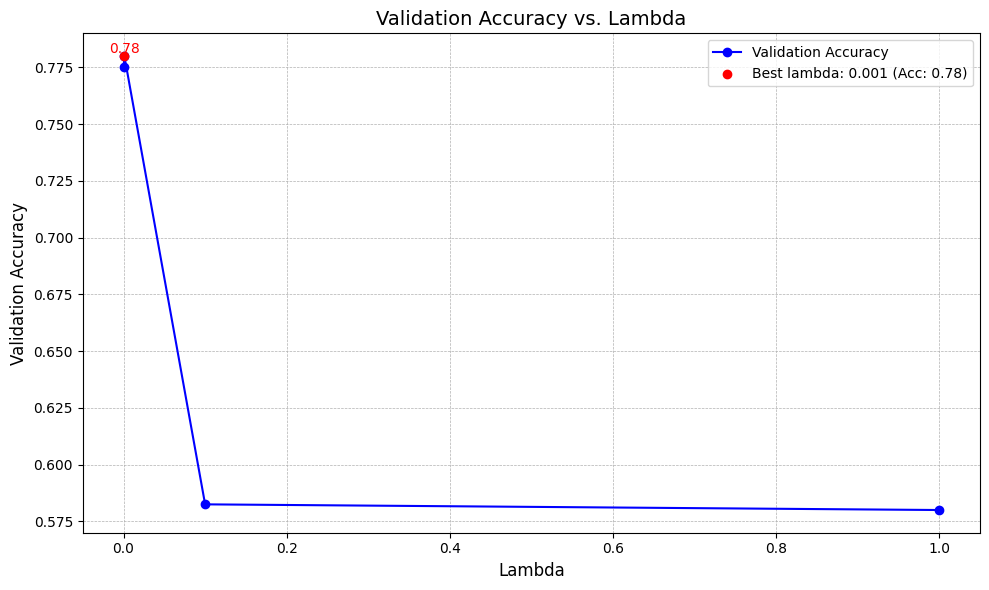

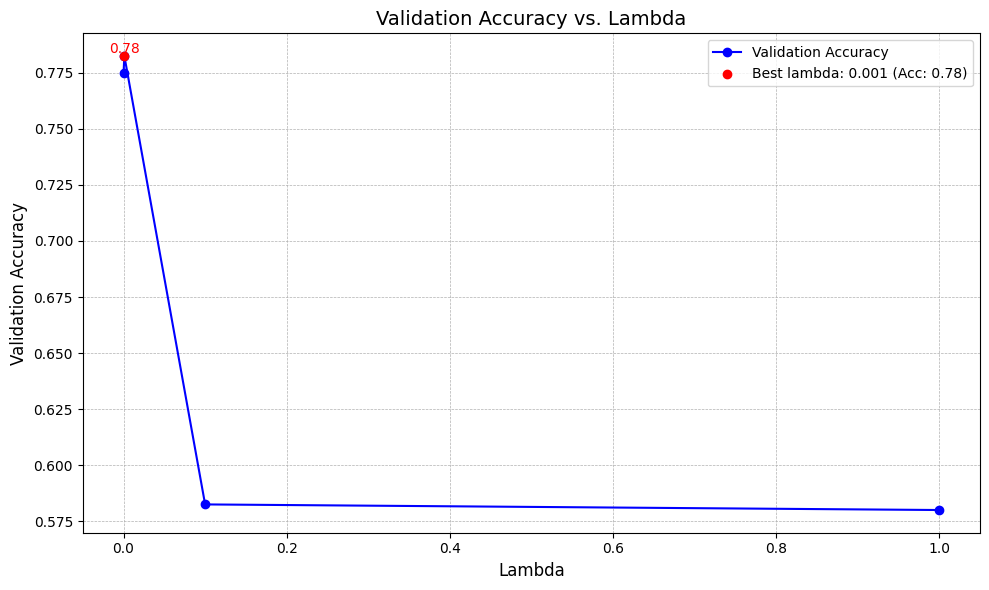

In [ ]:

best_lambda = best_lambda_by_dev_acc(results_Q8_l2["Lambdas"], results_Q8_l2["Dev Acc"])
best_lambda = best_lambda_by_dev_acc(results_Q8_l2["Lambdas"], results_Q8_l2["Best Dev Acc"])

In [ ]:
# preparing best model
best_model = next((entry for entry in bests if entry["best_lambda"] == best_lambda), None)
best_w = best_model["best_weights"]
best_b = best_model["best_bias"]

test_model(test_norm_embeddings, y_test, best_w, best_b)


Test Accuracy: 58.00%


0.58